In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import matplotlib.cm as cm
from matplotlib.ticker import MultipleLocator

method_path = "figs/QSSA/SIM_results/"
mechanism_name = "NH3_otomo"

case_name = "case_NH3_counterflow_KAUST"

color_arr = ('k','r','b','y','g', 'c','m')
symbol_arr = ('s','o','v','^','*')
# ─── Use generic serif font ───────────────────────────────────────────────────
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"]   = 6

# Compare the NP result with experiments

→ Saved cases/NH3_KAUST_NP_1bar/figs/exp_vs_sim_MF_grid.pdf and cases/NH3_KAUST_NP_1bar/figs/exp_vs_sim_MF_grid.png


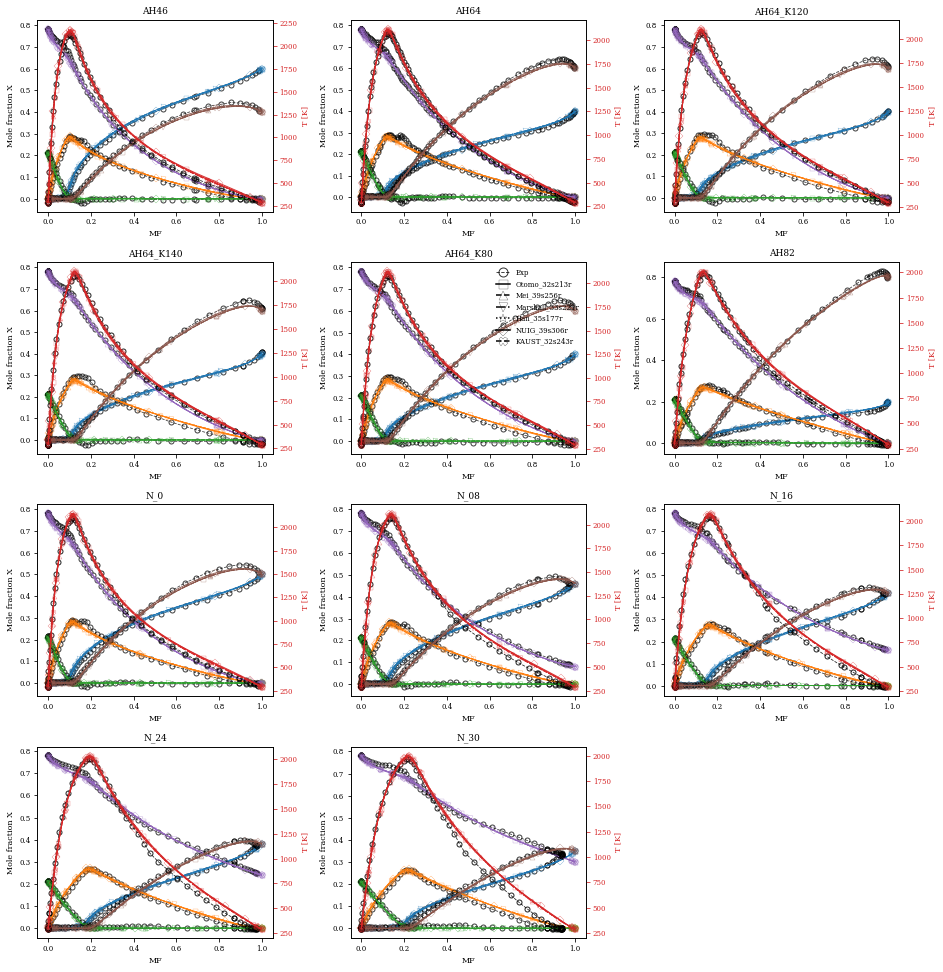

In [2]:
# %matplotlib inline
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from typing import List, Optional

# ────────────────────────── Plotting ──────────────────────────
def plot_case_grid(
    case_dir: str,
    exp_subdir: str = "Exp",
    sim_subdir: str = "Sim",
    mechs: Optional[List[str]] = None,      # e.g. ["Otomo_32s213r", "KAUST_32s243r"]
    mech_labels: Optional[List[str]] = None,
    species: Optional[List[str]] = None,    # X_ columns to plot
    fig_out: Optional[str] = None,          # path without extension; saved as .pdf and .png
):
    """
    Make a grid of panels. Each panel shows EXP scatter & SIM lines:
      - Left y-axis: selected species X_* vs MF
      - Right y-axis: T vs MF
    Assumes EXP CSVs already contain an 'MF' column.
    """
    if mechs is None:
        mechs = ["Otomo_32s213r"]
    if mech_labels is None:
        mech_labels = mechs
    if species is None:
        species = ["H2", "H2O", "O2", "N2", "NH3"]

    tab_colors = ["tab:{}".format(c) for c in ["blue","orange","green","purple","brown","pink","gray","olive","cyan"]]
    symbol_arr = ['s','^','v','*','D','X','o','P']
    line_arr   = ['-','--','-.',':']

    exp_path = os.path.join(case_dir, exp_subdir)
    sim_path = os.path.join(case_dir, sim_subdir)
    if not os.path.isdir(exp_path):
        raise FileNotFoundError("EXP directory not found: {}".format(exp_path))
    if not os.path.isdir(sim_path):
        raise FileNotFoundError("SIM directory not found: {}".format(sim_path))

    # cases present in EXP and (preferably) in at least one SIM mech
    exp_files = sorted([f for f in os.listdir(exp_path) if f.lower().endswith(".csv")])
    sim_cases = set()
    for mech in mechs:
        mdir = os.path.join(sim_path, mech)
        if os.path.isdir(mdir):
            sim_cases.update([f for f in os.listdir(mdir) if f.lower().endswith(".csv")])
    case_files = [f for f in exp_files if f in sim_cases] or exp_files

    n = len(case_files)
    cols = 3 if n >= 6 else (2 if n >= 3 else 1)
    rows = int(math.ceil(float(n) / float(cols))) if n > 0 else 1

    fig, axes = plt.subplots(rows, cols, figsize=(4.2*cols + 0.6, 3.4*rows), squeeze=False)
    center_ax = axes[min(rows-1, 1)][min(cols-1, 1)]  # central-ish panel for legend

    # Legend handles (exp + mechanisms)
    mech_handles = []
    exp_handle = Line2D([0], [0], color="k", linestyle="--", linewidth=0.9,
                        marker="o", markerfacecolor="none", markeredgecolor="k",
                        markersize=9, alpha=0.8, label="Exp")
    mech_handles.append(exp_handle)
    for j, lbl in enumerate(mech_labels):
        h = Line2D([0], [0], color="k",
                   marker=symbol_arr[j % len(symbol_arr)],
                   markerfacecolor="none", markeredgecolor="k",
                   markeredgewidth=0.25,
                   linestyle=line_arr[j % len(line_arr)],
                   markersize=9, label=lbl)
        mech_handles.append(h)

    # Panels
    for idx, fname in enumerate(case_files):
        r, c = divmod(idx, cols)
        ax = axes[r, c]
        ax_t = ax.twinx()
        title = os.path.splitext(fname)[0]

        # EXP read
        exp_csv = os.path.join(exp_path, fname)
        df_exp = pd.read_csv(exp_csv)

        if "MF" not in df_exp.columns:
            ax.set_title("{} (MF missing)".format(title), fontsize=9)
        else:
            ax.set_title(title, fontsize=9)

        # Species (left axis): EXP scatter + SIM lines
        for i, sp in enumerate(species):
            xcol = "X_{}".format(sp)
            if xcol not in df_exp.columns or "MF" not in df_exp.columns:
                continue
            color = tab_colors[i % len(tab_colors)]

            # EXP scatter
            ax.plot(
                df_exp["MF"].values, df_exp[xcol].values,
                color="k", linestyle="--", linewidth=0.8,
                marker="o", markerfacecolor="none", markeredgecolor="k",
                markersize=5, alpha=0.75
            )

            # SIM lines per mechanism
            for j, mech in enumerate(mechs):
                sim_csv = os.path.join(sim_path, mech, fname)
                if not os.path.isfile(sim_csv):
                    continue
                df_sim = pd.read_csv(sim_csv)
                if ("MF" not in df_sim.columns) or (xcol not in df_sim.columns):
                    continue
                ax.plot(
                    df_sim["MF"].values, df_sim[xcol].values,
                    color=color, linewidth=0.9,
                    marker=symbol_arr[j % len(symbol_arr)],
                    markerfacecolor="none", markeredgecolor=color,
                    markeredgewidth=0.25, markersize=5,
                    linestyle=line_arr[j % len(line_arr)],
                    markevery=max(len(df_sim)//15, 1),
                    alpha=0.95
                )

        # Temperature (right axis)
        if "MF" in df_exp.columns and "T" in df_exp.columns:
            ax_t.plot(
                df_exp["MF"].values, df_exp["T"].values,
                color="k", linestyle="--", linewidth=0.8,
                marker="o", markerfacecolor="none", markeredgecolor="k",
                markersize=5, alpha=0.85
            )
        for j, mech in enumerate(mechs):
            sim_csv = os.path.join(sim_path, mech, fname)
            if not os.path.isfile(sim_csv):
                continue
            df_sim = pd.read_csv(sim_csv)
            if ("MF" not in df_sim.columns) or ("T" not in df_sim.columns):
                continue
            ax_t.plot(
                df_sim["MF"].values, df_sim["T"].values,
                color="tab:red",
                linestyle=line_arr[j % len(line_arr)],
                linewidth=1.0, alpha=0.95,
                marker=symbol_arr[j % len(symbol_arr)],
                markerfacecolor="none", markeredgecolor="tab:red",
                markeredgewidth=0.25, markersize=5,
                markevery=max(len(df_sim)//15, 1)
            )

        ax.set_xlabel("MF", fontsize=8)
        ax.set_ylabel("Mole fraction X", fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=7)
        ax_t.set_ylabel("T [K]", fontsize=8, color="tab:red")
        ax_t.tick_params(axis='y', labelsize=7, colors="tab:red")

    # Hide unused axes
    for k in range(n, rows*cols):
        r, c = divmod(k, cols)
        axes[r, c].axis('off')

    # Legend
    center_ax.legend(handles=mech_handles, loc="upper right", fontsize=7, frameon=False)

    plt.tight_layout()
    if fig_out is None:
        fig_out = os.path.join(case_dir, "figs", "exp_vs_sim_MF_grid")
    os.makedirs(os.path.dirname(fig_out), exist_ok=True)
    # plt.savefig(fig_out + ".pdf", dpi=300)
    plt.savefig(fig_out + ".png", dpi=200)
    print("→ Saved {}.pdf and {}.png".format(fig_out, fig_out))
    plt.show()

# ─────────────────────── Params & Run (edit these) ───────────────────────
case_dir   = "cases/NH3_KAUST_NP_1bar"
exp_subdir = "Exp"
sim_subdir = "Sim"
mechs      = ["Otomo_32s213r", "Mei_39s256r","Marshall_33s221r", "Han_35s177r", "NUIG_39s306r", "KAUST_32s243r"]          # add more as available
mech_labels = None                      # or like ["Otomo", "KAUST"]
species    = ["H2", "H2O", "O2", "N2", "NH3"]
fig_out    = os.path.join(case_dir, "figs", "exp_vs_sim_MF_grid")

# plot
plot_case_grid(case_dir, exp_subdir, sim_subdir, mechs, mech_labels, species, fig_out)


# Compare Premixed Result with Exp

figure saved → figs/NH3_NP_CF/Fig2_Non_Premixed_Sim_EXP_QSSA.pdf


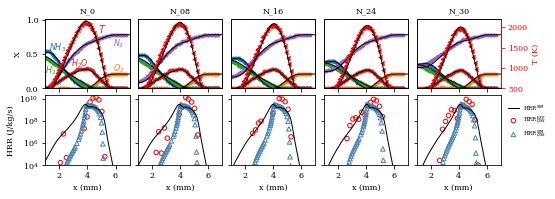

In [45]:

import re
from pathlib import Path
from typing import Sequence, Optional, Union, List, Dict, Tuple

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # optional if you keep a global legend

def _as_list(x, length):
    """Ensure that x is a list of given length.
    If x is already a sequence, return it directly (or repeat if shorter).
    If x is a scalar, replicate it to match the length."""
    if isinstance(x, (list, tuple)):
        if len(x) == length:
            return list(x)
        elif len(x) == 1:
            return list(x) * length
        else:
            raise ValueError(f"Length mismatch: expected {length}, got {len(x)}")
    else:
        return [x] * length



def plot_counterflow_full(
    mechanism:  str,
    exp_case_dir: str,
    exp_recon_dir: str,
    sim_case_dir: str,
    sim_recon_dir: str,
    fig_dir: str,
    target_cases: Sequence[str],
    #
    exp_shift: Union[float, Sequence[float]] = 0.0,
    sim_shift: Union[float, Sequence[float]] = 0.0,
    # figure sizing
    figsize: Optional[Tuple[float, float]] = None,
    fig_width: float = 8.73,
    row_height: float = 1.5,
    #
    top_species: Sequence[str] = ("X_NH3", "X_O2", "X_H2", "X_H2O", "X_N2"),
    data_species: Sequence[str] = ("X_OH", "X_O", "X_H", "X_NH2", "X_NO", "HRR"),
    #
    x_ranges: Optional[Sequence[Sequence[float]]] = None,
    t_range: Sequence[float] = (500, 2200),
    pdf_name: str = "1D_compact.pdf",
    #
    exp_color: str = "red",
    recon_color: str = "steelblue",
    sim_color: str = "black",
    #
    linewidth: float = 1.0,
    marker_size: float = 8,
    font_size: int = 8,
    legend_font_size: int = 8,
    #
    exp_marker: str = "o",
    qssa_marker: str = "s",
    species_axis: Optional[Dict[str, Dict[str, Union[str, Sequence[float]]]]] = None,
    top_adjust: float = 0.85,
    # Top-row labels instead of legend
    show_top_species_text: bool = True,
    top_species_text_pos: Optional[Dict[str, Tuple[float, float]]] = None,
    top_text_axes_coords: bool = True,
    top_species_text_kwargs: Optional[Dict] = None,
    # tab colors for top EXP markers & labels
    top_species_colors: Optional[Sequence[str]] = None,
    # “T” text on first subplot
    show_top_T_text: bool = True,
    top_T_text_pos: Tuple[float, float] = (0.93, 0.88),
    top_T_text_kwargs: Optional[Dict] = None,
    # legend on 2nd row, built from that subplot but drawn OUTSIDE the figure
    outside_legend: bool = True,
    legend_rows: int = 3,                        # ← exactly 3 rows
    legend_loc: str = "center left",             # where relative to bbox_to_anchor
    legend_bbox: Tuple[float, float] = (1.02, 0.5),  # (x, y) in figure coords
    legend_frameon: bool = False,
    right_adjust: float = 0.78,                  # shrink plotting area to leave room at right
    alpha_value: float = 0.78,                  # shrink plotting area to leave room at right
    


) -> None:
    import re
    import matplotlib.pyplot as plt
    from pathlib import Path
    import pandas as pd

    def _nice_label(sp: str) -> str:
        return sp.split('_', 1)[1] if sp.startswith('X_') else sp

    def _latex_label(raw: str) -> str:
        def repl(m):
            letter = m.group(1)
            digits = m.group(2)
            return f"{letter}_{{{digits}}}" if len(digits) > 1 else f"{letter}_{digits}"
        s = re.sub(r'([A-Za-z])(\d+)', repl, raw)
        return f"${s}$"

    # defaults
    if species_axis is None:
        species_axis = {"HRR": {"yscale": "log", "ylim": (1e6, 1e11)}}

    default_tab_colors = [
        "tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple",
        "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"
    ]
    if top_species_colors is None:
        top_species_colors = [default_tab_colors[i % len(default_tab_colors)] for i in range(len(top_species))]
    else:
        if len(top_species_colors) < len(top_species):
            raise ValueError("top_species_colors length must be >= len(top_species)")

    top_label_colors: Dict[str, str] = {}
    for i, sp in enumerate(top_species):
        lab_plain = _nice_label(sp)
        top_label_colors[lab_plain] = top_species_colors[i]

    if top_species_text_pos is None:
        labels = [_nice_label(sp) for sp in top_species]
        y0, dy = 0.92, 0.10
        top_species_text_pos = {lab: (0.05, y0 - i * dy) for i, lab in enumerate(labels)}
    if top_species_text_kwargs is None:
        top_species_text_kwargs = {"fontsize": font_size + 1, "weight": "bold"}

    if top_T_text_kwargs is None:
        top_T_text_kwargs = {"fontsize": font_size + 1, "weight": "bold", "color": "tab:red"}

    # precompute y-lims
    ymins = {sp: float('inf') for sp in top_species + list(data_species)}
    ymaxs = {sp: -float('inf') for sp in top_species + list(data_species)}
    for case in target_cases:
        sim_csv = Path(sim_case_dir) / mechanism / f"{case}.csv"
        exp_csv = Path(exp_case_dir) / f"{case}.csv"
        df_sim = pd.read_csv(sim_csv)
        df_exp = pd.read_csv(exp_csv)
        if exp_recon_dir:
            exp_recon_csv = Path(exp_recon_dir) / mechanism / case / "predicted_X.csv"
            df_exp_recon = pd.read_csv(exp_recon_csv) if exp_recon_csv.is_file() else None
        else:
            df_exp_recon = None
        if sim_recon_dir:
            sim_recon_csv = Path(sim_recon_dir) / mechanism / case / "predicted_X.csv"
            df_sim_recon = pd.read_csv(sim_recon_csv) if sim_recon_csv.is_file() else None
        else:
            df_sim_recon = None

        for sp in ymins:
            if sp in df_sim:
                arr = df_sim[sp].to_numpy()
                ymins[sp] = min(ymins[sp], float(arr.min()))
                ymaxs[sp] = max(ymaxs[sp], float(arr.max()) * 1.01)
            if sp in df_exp:
                arr = df_exp[sp].to_numpy()
                if sp == "X_NO":
                    arr = arr / 1e6
                ymins[sp] = min(ymins[sp], float(arr.min()))
                ymaxs[sp] = max(ymaxs[sp], float(arr.max()) * 1.01)
            if df_exp_recon is not None and sp in df_exp_recon.columns:
                arr = df_exp_recon[sp].to_numpy()
                ymins[sp] = min(ymins[sp], float(arr.min()))
                ymaxs[sp] = max(ymaxs[sp], float(arr.max()) * 1.01)

    n_cols = len(target_cases)
    exp_shift_l = _as_list(exp_shift, n_cols)
    sim_shift_l = _as_list(sim_shift, n_cols)
    n_rows = len(data_species) + 1

    if x_ranges is None:
        x_ranges = [[None, None]] * n_cols
    elif len(x_ranges) != n_cols:
        if len(x_ranges) == 1 and isinstance(x_ranges[0], (list, tuple)):
            x_ranges = [list(x_ranges[0])] * n_cols
        else:
            raise ValueError(f"x_ranges length ({len(x_ranges)}) must match n_cols ({n_cols})")

    plt.rcParams.update({"font.size": font_size})
        # decide final figure size
    if figsize is None:
        figsize = (fig_width, row_height * n_rows)

    fig, axs = plt.subplots(
        n_rows, n_cols,
        figsize=figsize,
        sharex=True, sharey=False
    )

    for col_idx, case in enumerate(target_cases):
        sim_csv = Path(sim_case_dir) / mechanism / f"{case}.csv"
        exp_csv = Path(exp_case_dir) / f"{case}.csv"
        df_sim = pd.read_csv(sim_csv)
        df_exp = pd.read_csv(exp_csv)
        if 'T' in df_sim.columns:
            # robust in case T has strings/NaNs
            Tmax = pd.to_numeric(df_sim['T'], errors='coerce').max(skipna=True)
            if pd.notna(Tmax) and Tmax < 500:
                print(f"case extinction!  [{case}] max(T)={Tmax:.1f} K")
                
        if exp_recon_dir:
            exp_recon_csv = Path(exp_recon_dir) / mechanism / case / "predicted_X.csv"
            df_exp_recon = pd.read_csv(exp_recon_csv) if exp_recon_csv.is_file() else None
        else:
            df_exp_recon = None
        if sim_recon_dir:
            sim_recon_csv = Path(sim_recon_dir) / mechanism / case / "predicted_X.csv"
            df_sim_recon = pd.read_csv(sim_recon_csv) if sim_recon_csv.is_file() else None
        else:
            df_sim_recon = None

        # x coords (prefer grid)
        if "grid" in df_sim.columns:
            x_sim = df_sim["grid"].to_numpy() * 1000 + sim_shift_l[col_idx]
        else:
            x_sim = df_sim["x"].to_numpy() * 1000 + sim_shift_l[col_idx]
        x_exp = df_exp.get("x", df_exp.columns[1]).to_numpy() + exp_shift_l[col_idx]

        # top row
        ax_top = axs[0, col_idx]
        for sp in top_species:
            lab_plain = _nice_label(sp)
            color = top_label_colors[lab_plain]
            ax_top.plot(x_sim, df_sim[sp].to_numpy(), '-', lw=linewidth, color=sim_color)
            ax_top.scatter(x_exp, df_exp[sp].to_numpy(), s=8, marker=exp_marker,
                           lw=linewidth, color=color)
        ax_top.set_ylim(0, 1.01)
        ax_top.set_title(case, fontsize=8)
        # ax_top.set_xticklabels([])
        if col_idx == 0:
            ax_top.set_ylabel('X')
        else:
            ax_top.set_yticks([])
        if x_ranges[col_idx][0] is not None:
            ax_top.set_xlim(*x_ranges[col_idx])

        # temperature on top row (right axis)
        if 'T' in df_sim.columns:
            ax_top_t = ax_top.twinx()
            ax_top_t.plot(x_sim, df_sim['T'].to_numpy(), '-', lw=linewidth, color='black')
            if 'T' in df_exp.columns:
                ax_top_t.scatter(x_exp, df_exp['T'].to_numpy(), s=marker_size, marker=8,lw=linewidth, color='red')
            ax_top_t.set_ylim(t_range)
            if col_idx == n_cols - 1:
                ax_top_t.set_ylabel('T (K)', color='red')
                ax_top_t.spines['right'].set_color('red')
                ax_top_t.tick_params(axis='y', colors='red')
            else:
                ax_top_t.set_yticks([])



        # top species text on first subplot + "T" text
        if col_idx == 0 and show_top_species_text:
            if not top_text_axes_coords:
                ax_top.set_ylim(0, 1.01)
            for sp in top_species:
                lab_plain = _nice_label(sp)
                lab_tex = _latex_label(lab_plain)
                if lab_plain in top_species_text_pos:
                    x_pos, y_pos = top_species_text_pos[lab_plain]
                    text_kwargs = dict(top_species_text_kwargs)
                    text_kwargs.setdefault("color", top_label_colors[lab_plain])
                    if top_text_axes_coords:
                        ax_top.text(x_pos, y_pos, lab_tex, transform=ax_top.transAxes, **text_kwargs)
                    else:
                        ax_top.text(x_pos, y_pos, lab_tex, **text_kwargs)
            if show_top_T_text:
                t_kwargs = dict(top_T_text_kwargs)
                t_kwargs.setdefault("color", "tab:red")
                ax_top.text(top_T_text_pos[0], top_T_text_pos[1], f"$T$",
                            transform=ax_top.transAxes, **t_kwargs)

        # data rows
        for r, sp in enumerate(data_species, start=1):
            ax = axs[r, col_idx]
            if sp in df_sim:
                y_sim = df_sim[sp].to_numpy()
                ax.plot(
                    x_sim, y_sim, '-', lw=linewidth, color=sim_color,
                    label=('HRR$^{SIM}$' if (r == 1 and col_idx == 0) else '')
                )
            if df_exp_recon is not None and sp in df_exp_recon:
                exp_x_rec = df_exp_recon["x"].to_numpy() + exp_shift_l[col_idx]
                exp_y_rec = df_exp_recon[sp].to_numpy()

                ax.scatter(exp_x_rec[::2], exp_y_rec[::2], s=marker_size, marker=exp_marker,
                           facecolors='none', edgecolors=exp_color, lw=linewidth, alpha = alpha_value,
                           label=('HRR$^{EXP}_{QSS}$' if (r == 1 and col_idx == 0) else ''))
                
            if df_sim_recon is not None and sp in df_sim_recon:
                if "grid" in df_sim_recon.columns:
                    sim_x_rec = df_sim_recon["grid"].to_numpy() * 1000 + sim_shift_l[col_idx]
                else:
                    sim_x_rec = df_sim_recon["x"].to_numpy() * 1000 + sim_shift_l[col_idx]
                sim_y_rec = df_sim_recon[sp].to_numpy()
                ax.scatter(sim_x_rec[::2], sim_y_rec[::2], s=marker_size, marker=qssa_marker,
                           facecolors='none', edgecolors=recon_color, lw=linewidth,
                           label=('HRR$^{SIM}_{QSS}$' if (r == 1 and col_idx == 0) else ''))

            cfg = (species_axis or {}).get(sp, {})
            ax.set_yscale("log" if cfg.get("yscale", "linear") == "log" else "linear")
            ylim = cfg.get("ylim", None)
            if ylim is not None:
                ax.set_ylim(*ylim)
            else:
                ax.set_ylim(ymins[sp], ymaxs[sp])

            if sp == 'X_OH' and 'T' in df_sim.columns:
                ax_t = ax.twinx()
                ax_t.plot(x_sim, df_sim['T'], ':', color='tab:red')
                ax_t.set_ylim(t_range)
                if col_idx == n_cols - 1:
                    ax_t.set_ylabel('T (K)', color='tab:red')
                else:
                    ax_t.set_yticks([])
                ax_t.spines['right'].set_color('tab:red')
                ax_t.tick_params(axis='y', colors='tab:red')

            if col_idx == 0:
                if sp == 'HRR':
                    ax.set_ylabel('HRR (J/kg/s)', fontsize=font_size)
                elif sp.startswith('X_'):
                    sub = sp.split('_', 1)[1]
                    ax.set_ylabel(f"$X_{{{sub}}}$", fontsize=font_size)
                else:
                    ax.set_ylabel(sp, fontsize=font_size)
            else:
                ax.set_yticklabels([])

            if r == len(data_species):
                ax.set_xlabel('x (mm)')
                ax.tick_params(labelbottom=True)   # ensure visible for bottom row
            else:
                ax.tick_params(labelbottom=False)  # hide for non-bottom rows

    # ---- Figure-level legend from the 2nd row, 1st column subplot ----
    if outside_legend and len(data_species) >= 1:
        leg_ax = axs[1, 0]  # second row, first column
        handles, labels = leg_ax.get_legend_handles_labels()
        # Filter out empty labels (''), just in case
        handles_labels = [(h, l) for h, l in zip(handles, labels) if l]
        if handles_labels:
            handles, labels = zip(*handles_labels)
            import math
            n_items = len(handles)
            # Arrange into exactly `legend_rows` rows => set ncol accordingly
            ncol = math.ceil(n_items / float(legend_rows))
            fig.legend(
                handles, labels,
                loc=legend_loc,
                bbox_to_anchor=legend_bbox,
                ncol=ncol,
                fontsize=legend_font_size,
                frameon=legend_frameon,
            )

    fig.subplots_adjust(top=top_adjust, right=0.85, wspace=0.1, hspace=0.1)
    Path(fig_dir).mkdir(parents=True, exist_ok=True)
    out = Path(fig_dir) / pdf_name
    fig.savefig(out, dpi=300, bbox_inches='tight')
    print(f"figure saved → {out}")

plot_counterflow_full(
    mechanism= "Han_35s177r",#"Otomo_32s213r",##"Otomo_32s213r",
    exp_case_dir="cases/NH3_KAUST_NP_1bar/Exp",
    exp_recon_dir="cases/NH3_KAUST_NP_1bar/Exp_QSSA",
    sim_case_dir="cases/NH3_KAUST_NP_1bar/Sim",
    sim_recon_dir="cases/NH3_KAUST_NP_1bar/Sim_QSSA",
    fig_dir="figs/NH3_NP_CF",
    target_cases=["N_0", "N_08", "N_16", "N_24", "N_30"],
    exp_shift=[2.4, 2.5, 2.65, 2.76, 2.85],      # mm
    sim_shift=[-2.0, -2.0, -2.0, -2.0, -2.0],    # mm
    top_species=["X_NH3", "X_O2", "X_H2", "X_H2O", "X_N2"],
    data_species=["HRR"],
    x_ranges=[[1, 7]] * 5,
    pdf_name="Fig2_Non_Premixed_Sim_EXP_QSSA.pdf",
    exp_marker="o",
    qssa_marker="^",
    species_axis={"HRR": {"yscale": "log", "ylim": (1e4, 2e10)}},
    top_adjust=0.80,
    t_range=(500, 2200),
    fig_width= 8.73,
    row_height = 1.5,
    # positions in axes coordinates for the first subplot
    show_top_species_text=True,
    top_text_axes_coords=True,
    top_species_text_pos={
        "NH3": (0.04, 0.55),
        "O2":  (0.8, 0.25),
        "H2":  (0, 0.22),
        "H2O": (0.3, 0.32),
        "N2":  (0.8, 0.6),
    },
    top_species_text_kwargs={"fontsize": 8, "weight": "bold"},
    # "T" label controls
    show_top_T_text=True,
    top_T_text_pos=(0.63, 0.8),
    top_T_text_kwargs={"fontsize": 10, "weight": "bold", "color": "tab:red"},
    legend_rows = 3,                        # ← exactly 3 rows
    legend_loc = "center right",             # where relative to bbox_to_anchor
    legend_bbox = (0.93, 0.325),  # (x, y) in figure coords
    right_adjust = 0.78,                  # shrink plotting area to leave room at right
    legend_font_size= 5.5,
    marker_size = 20,
    alpha_value = 1,

)

In [ ]:
plot_counterflow_full(
    mechanism= "Otomo_32s213r",#"Otomo_32s213r",##"Han_35s177r",
    exp_case_dir="cases/NH3_KAUST_Premixed_1bar/Exp",
    exp_recon_dir="cases/NH3_KAUST_Premixed_1bar/Exp_QSSA",
    sim_case_dir="cases/NH3_KAUST_Premixed_1bar/Sim_plot",
    sim_recon_dir="cases/NH3_KAUST_Premixed_1bar/Sim_QSSA_plot",
    # sim_case_dir="cases/NH3_KAUST_Premixed_1bar/Sim_plot",
    # sim_recon_dir="cases/NH3_KAUST_Premixed_1bar/Sim_QSSA_plot",
    fig_dir="figs/NH3_KAUST_Premixed_1bar",
    target_cases=["CA43_phi08", "CA43_phi10", "CA43_phi12"],
    exp_shift=[0, 0, 0],      # mm
    sim_shift=[-1.8, -1.5, -2.85],    # mm (after mirroring)
    top_species=["X_NH3", "X_O2", "X_H2", "X_H2O", "X_N2"],
    data_species=["HRR"],
    # match number of target_cases:
    x_ranges=[[-1.5, 4]] * 3,
    pdf_name="Fig1_Premixed_Sim_EXP_QSSA.pdf",
    exp_marker="o",
    qssa_marker="^",
    # Per-species axis config: match your original HRR behavior
    species_axis={"HRR": {"yscale": "log", "ylim": (1e2, 2e10)}},
    top_adjust=0.80,    # lift the title/legend up
    t_range=(500, 2200),
    fig_width= 6.73,
    row_height = 1.5,

    # positions in axes coordinates for the first subplot
    show_top_species_text=True,
    top_text_axes_coords=True,
    top_species_text_pos={
        "NH3": (0.02, 0.35),
        "O2":  (0.8, 0.25),
        "H2":  (0.02, 0.22),
        "H2O": (0.3, 0.32),
        "N2":  (0.8, 0.58),
    },
    top_species_text_kwargs={"fontsize": 8, "weight": "bold"},
    # "T" label controls
    show_top_T_text=True,
    top_T_text_pos=(0.45, 0.8),
    top_T_text_kwargs={"fontsize": 10, "weight": "bold", "color": "tab:red"},
    legend_rows = 3,                        # ← exactly 3 rows
    legend_loc = "center left",             # where relative to bbox_to_anchor
    legend_bbox = (0.85, 0.325),  # (x, y) in figure coords
    right_adjust = 0.78,                  # shrink plotting area to leave room at right
    legend_font_size= 5.5
)
# 或许需要调一下拉伸率？

FileNotFoundError: [Errno 2] No such file or directory: 'cases/NH3_KAUST_Premixed_1bar/Sim_plot/NUIG_39s306r/CA43_phi10.csv'

# figure 3 (a): Compare mechanism on premixed flames and non-premixed flames  (可能要换成CA火焰的mechanism对比)

<ipython-input-40-1f4942328192>:57: UserWarning: You passed a edgecolor/edgecolors ((0.8901960784313725, 0.4666666666666667, 0.7607843137254902)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(xv[idx], yv[idx], **kw)
<ipython-input-40-1f4942328192>:57: UserWarning: You passed a edgecolor/edgecolors ((0.8901960784313725, 0.4666666666666667, 0.7607843137254902)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(xv[idx], yv[idx], **kw)
<ipython-input-40-1f4942328192>:57: UserWarning: You passed a edgecolor/edgecolors ((0.8901960784313725, 0.4666666666666667, 0.7607843137254902)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(xv[idx], yv[idx], **kw)
<ipython-input-40-1f4942328192>:57: UserWar

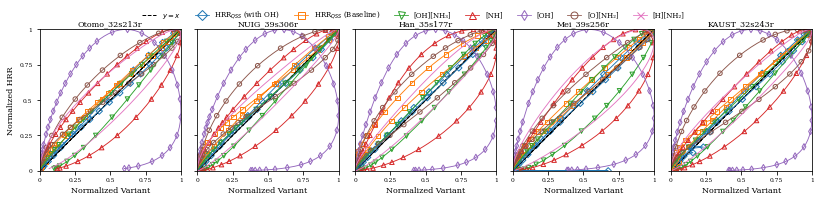

→ Saved figure at: figs/validation/fig3_HRR_vs_variants_by_mechanism.pdf


In [40]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import FixedLocator, FixedFormatter

# ─── User‐adjustable settings ──────────────────────────────────────────────────
data_path    = "cases"
sim_case     = "NH3_premixed_matrix_1bar/Sim"
qssa_case    = "NH3_premixed_matrix_1bar/Sim_QSSA"
qssa_oh_case = "NH3_premixed_matrix_1bar/Sim_QSSA_withOH"  # <─ added
target_case  = "NH3_0.80_0.20_phi1.15_p1.0"
# target_case  = "NH3_1.00_0.00_phi1.15_p1.0"

mechs        = [
    "Otomo_32s213r",
    "NUIG_39s306r",
    "Han_35s177r",
    "Mei_39s256r",
    "KAUST_32s243r",
    # "Marshall_33s221r"
]
marker_stride = 4  # plot only every Nth marker (set to None or 0/1 to show all)

# ─── Colors & mapping ──────────────────────────────────────────────────────────
tab10 = plt.get_cmap("tab10").colors
series_colors = {
    "$y = x$":                     "k",         # black
    "HRR$_{QSS}$ (with OH)":         tab10[0],    # blue/green
    "HRR$_{QSS}$ (Baseline)":        tab10[1],    # orange
    "[OH][NH₃]":                   tab10[2],    # green
    "[NH]":                        tab10[3],    # red
    "[OH]":                        tab10[4],    # purple
    "[O][NH₂]":                    tab10[5],    # brown
    "[H][NH₂]":                    tab10[6],    # pink-ish
}

# (label, linestyle, color, marker)
series_info = [
    ("$y = x$",                    "--", series_colors["$y = x$"],                 None),
    ("HRR$_{QSS}$ (with OH)",        "-",  series_colors["HRR$_{QSS}$ (with OH)"],     "D"),
    ("HRR$_{QSS}$ (Baseline)",       "-",  series_colors["HRR$_{QSS}$ (Baseline)"],    "s"),
    ("[OH][NH₃]",                  "-",  series_colors["[OH][NH₃]"],               "v"),
    ("[NH]",                       "-",  series_colors["[NH]"],                    "^"),
    ("[OH]",                       "-",  series_colors["[OH]"],                    "d"),
    ("[O][NH₂]",                   "-",  series_colors["[O][NH₂]"],                "o"),
    ("[H][NH₂]",                   "-",  series_colors["[H][NH₂]"],                "x"),
]


def _scatter_every(ax, xv, yv, stride, **kw):
    """Scatter only every `stride`-th point (fall back to all if stride <= 1/None)."""
    if stride is None or stride <= 1:
        ax.scatter(xv, yv, **kw); return
    idx = np.arange(len(xv))[::int(stride)]
    ax.scatter(xv[idx], yv[idx], **kw)

def _safe_read(path):
    return pd.read_csv(path, comment="#") if os.path.isfile(path) else None

# ─── Function to plot one mechanism ────────────────────────────────────────────
def plot_one_mech(ax, mech, marker_stride=5):
    # Load SIM
    sim_csv = os.path.join(data_path, sim_case, mech, f"{target_case}.csv")
    df_sim  = pd.read_csv(sim_csv, comment="#")

    # Load QSSA (baseline)
    qssa_csv = os.path.join(data_path, qssa_case, mech, target_case, "predicted_X.csv")
    df_qssa  = _safe_read(qssa_csv)

    # Load QSSA (with OH)
    qssa_oh_csv = os.path.join(data_path, qssa_oh_case, mech, target_case, "predicted_X.csv")
    df_qsoh = _safe_read(qssa_oh_csv)

    # Normalize HRR (parity plot uses normalized shapes)
    sim_hrr_norm = df_sim["HRR"].to_numpy(dtype=float)
    sim_hrr_norm /= np.nanmax(sim_hrr_norm)

    qssa_hrr_norm = None
    if df_qssa is not None and "HRR" in df_qssa.columns and len(df_qssa) == len(df_sim):
        qssa_hrr_norm = df_qssa["HRR"].to_numpy(dtype=float)
        qssa_hrr_norm /= np.nanmax(qssa_hrr_norm)

    qssa_oh_hrr_norm = None
    if df_qsoh is not None and "HRR" in df_qsoh.columns and len(df_qsoh) == len(df_sim):
        qssa_oh_hrr_norm = df_qsoh["HRR"].to_numpy(dtype=float)
        qssa_oh_hrr_norm /= np.nanmax(qssa_oh_hrr_norm)

    # Variants from SIM, each normalized to its own max
    def norm(v): 
        return v / np.nanmax(v) if v is not None and np.nanmax(v) > 0 else v
    def X(name):
        return df_sim[name].to_numpy(dtype=float) if name in df_sim.columns else None

    oh_nh3 = norm(X("X_OH") * X("X_NH3")) if X("X_OH") is not None and X("X_NH3") is not None else None
    nh     = norm(X("X_NH"))
    oh     = norm(X("X_OH"))
    o_nh2  = norm(X("X_O") * X("X_NH2")) if X("X_O") is not None and X("X_NH2") is not None else None
    h_nh2  = norm(X("X_H") * X("X_NH2")) if X("X_H") is not None and X("X_NH2") is not None else None

    # x-series (variants) vs y-series (SIM HRR) for parity plot
    variants = [
        (sim_hrr_norm,    sim_hrr_norm),   # y=x
        (qssa_oh_hrr_norm,sim_hrr_norm),   # QSSA with OH vs SIM
        (qssa_hrr_norm,   sim_hrr_norm),   # QSSA vs SIM
        (oh_nh3,          sim_hrr_norm),   # [OH][NH3]
        (nh,              sim_hrr_norm),   # [NH]
        (oh,              sim_hrr_norm),   # [OH]
        (o_nh2,           sim_hrr_norm),   # [O][NH2]
        (h_nh2,           sim_hrr_norm),   # [H][NH2]
    ]

    # Plot each series with its style (skip if missing)
    for (label, ls, color, marker), (xv, yv) in zip(series_info, variants):
        if xv is None:
            continue
        ax.plot(xv, yv, linestyle=ls, color=color, linewidth=1 if marker is None else 0.9)
        if marker is not None:
            _scatter_every(ax, xv, yv, marker_stride,
                           s=20, marker=marker, facecolors='none',
                           edgecolors=color, label=label)

    # Formatting
    ax.set_xlim(0, 1); ax.set_ylim(0, 1)
    ax.set_aspect('equal', adjustable='box')
    ticks = [0, 0.25, 0.5, 0.75, 1]
    ax.xaxis.set_major_locator(FixedLocator(ticks))
    ax.yaxis.set_major_locator(FixedLocator(ticks))
    ax.xaxis.set_major_formatter(FixedFormatter([str(t) for t in ticks]))
    ax.yaxis.set_major_formatter(FixedFormatter([str(t) for t in ticks]))
    ax.tick_params(axis='both', which='major', labelsize=6)

    if mech == mechs[0]:
        ax.set_ylabel("Normalized HRR", fontsize=8)
    else:
        ax.tick_params(axis='y', labelleft=False)

    ax.set_xlabel("Normalized Variant", fontsize=8)
    ax.set_title(mech, fontsize=8, pad=4)

# ─── Figure setup ──────────────────────────────────────────────────────────────
fig, axes = plt.subplots(
    1, len(mechs),
    figsize=(2.8 * len(mechs), 2.6),
    sharex=True, sharey=True,
    gridspec_kw={'wspace': 0.05}
)
axes = axes.flatten()

for ax, mech in zip(axes, mechs):
    plot_one_mech(ax, mech, marker_stride=marker_stride)

# ─── Shared legend ─────────────────────────────────────────────────────────────
handles = []
for label, ls, color, marker in series_info:
    if marker is None:
        h = Line2D([0],[0], linestyle=ls, color=color, linewidth=1)
    else:
        h = Line2D([0],[0], linestyle=ls, color=color,
                   marker=marker, markerfacecolor='none',
                   markeredgecolor=color, markersize=7, linewidth=0.8)
    handles.append(h)

fig.legend(handles, [s[0] for s in series_info],
           loc='upper center', ncol=len(handles),
           frameon=False, fontsize=7, bbox_to_anchor=(0.5,1.02))

fig.tight_layout(rect=[0,0,1,0.95])
os.makedirs("figs/validation", exist_ok=True)
out = "figs/validation/fig3_HRR_vs_variants_by_mechanism.pdf"
plt.savefig(out, dpi=300, bbox_inches='tight')
plt.show()

print(f"→ Saved figure at: {out}")

# Figure 4: Compare mechanims on non-premixed 

<ipython-input-37-bb9bb77f5c49>:52: UserWarning: You passed a edgecolor/edgecolors ((0.8901960784313725, 0.4666666666666667, 0.7607843137254902)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(xv, yv, **kw)
<ipython-input-37-bb9bb77f5c49>:52: UserWarning: You passed a edgecolor/edgecolors ((0.8901960784313725, 0.4666666666666667, 0.7607843137254902)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(xv, yv, **kw)
<ipython-input-37-bb9bb77f5c49>:52: UserWarning: You passed a edgecolor/edgecolors ((0.8901960784313725, 0.4666666666666667, 0.7607843137254902)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(xv, yv, **kw)
<ipython-input-37-bb9bb77f5c49>:52: UserWarning: You passed a edgecolor/e

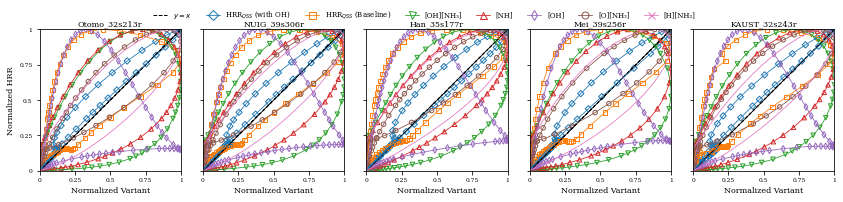

→ Saved figure at: figs/validation/fig4_HRR_vs_variants_by_mechanism_nonpremixed.pdf


In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import FixedLocator, FixedFormatter

# ─── User‐adjustable settings ──────────────────────────────────────────────────
data_path    = "cases"
sim_case     = "NH3_nonpremixed_matrix_1bar/Sim_DD_k40"
qssa_case    = "NH3_nonpremixed_matrix_1bar/Sim_DD_QSSA_k40"
qssa_oh_case = "NH3_nonpremixed_matrix_1bar/Sim_DD_QSSA_k40_withOH"  # <─ added
target_case  = "N_CF_NH3_0.80_H2_0.20_N2_0.00"

mechs = [
    "Otomo_32s213r",
    "NUIG_39s306r",
    "Han_35s177r",
    "Mei_39s256r",
    "KAUST_32s243r",
]
marker_stride = 1  # plot only every Nth marker

# ─── Colors & mapping ──────────────────────────────────────────────────────────
tab10 = plt.get_cmap("tab10").colors
series_colors = {
    "$y = x$":                     "k",         # black
    "HRR$_{QSS}$ (with OH)":         tab10[0],    # blue/green
    "HRR$_{QSS}$ (Baseline)":        tab10[1],    # orange
    "[OH][NH₃]":                   tab10[2],    # green
    "[NH]":                        tab10[3],    # red
    "[OH]":                        tab10[4],    # purple
    "[O][NH₂]":                    tab10[5],    # brown
    "[H][NH₂]":                    tab10[6],    # pink-ish
}

# (label, linestyle, color, marker)
series_info = [
    ("$y = x$",                    "--", series_colors["$y = x$"],                 None),
    ("HRR$_{QSS}$ (with OH)",        "-",  series_colors["HRR$_{QSS}$ (with OH)"],     "D"),
    ("HRR$_{QSS}$ (Baseline)",       "-",  series_colors["HRR$_{QSS}$ (Baseline)"],    "s"),
    ("[OH][NH₃]",                  "-",  series_colors["[OH][NH₃]"],               "v"),
    ("[NH]",                       "-",  series_colors["[NH]"],                    "^"),
    ("[OH]",                       "-",  series_colors["[OH]"],                    "d"),
    ("[O][NH₂]",                   "-",  series_colors["[O][NH₂]"],                "o"),
    ("[H][NH₂]",                   "-",  series_colors["[H][NH₂]"],                "x"),
]

def _scatter_every(ax, xv, yv, stride, **kw):
    """Scatter only every `stride`-th point (fall back to all if stride <= 1/None)."""
    if stride is None or stride <= 1:
        ax.scatter(xv, yv, **kw)
        return
    idx = np.arange(len(xv))[::int(stride)]
    ax.scatter(xv[idx], yv[idx], **kw)

def _safe_load_csv(path):
    return pd.read_csv(path, comment="#") if os.path.isfile(path) else None

# ─── Function to plot one mechanism ─────────────────────────────────────────
def plot_one_mech(ax, mech, marker_stride=5):
    # Load SIM
    sim_csv = os.path.join(data_path, sim_case, mech, f"{target_case}.csv")
    df_sim  = pd.read_csv(sim_csv, comment="#")

    # Load QSSA (baseline)
    qssa_csv = os.path.join(data_path, qssa_case, mech, target_case, "predicted_X.csv")
    df_qssa = _safe_load_csv(qssa_csv)

    # Load QSSA (with OH)  <─ added
    qssa_oh_csv = os.path.join(data_path, qssa_oh_case, mech, target_case, "predicted_X.csv")
    df_qssa_oh = _safe_load_csv(qssa_oh_csv)

    # Normalize HRR (to compare shapes)
    sim_hrr_norm  = df_sim["HRR"].to_numpy(dtype=float)
    sim_hrr_norm /= np.nanmax(sim_hrr_norm)

    qssa_hrr_norm = None
    if df_qssa is not None and "HRR" in df_qssa.columns and len(df_qssa) == len(df_sim):
        qssa_hrr_norm = df_qssa["HRR"].to_numpy(dtype=float)
        qssa_hrr_norm /= np.nanmax(qssa_hrr_norm)

    qssa_oh_hrr_norm = None
    if df_qssa_oh is not None and "HRR" in df_qssa_oh.columns and len(df_qssa_oh) == len(df_sim):
        qssa_oh_hrr_norm = df_qssa_oh["HRR"].to_numpy(dtype=float)
        qssa_oh_hrr_norm /= np.nanmax(qssa_oh_hrr_norm)

    # Build variant correlations from SIM fields, each normalized to its own max
    def norm(v): 
        return v / np.nanmax(v) if v is not None and np.nanmax(v) > 0 else v

    def X(name):
        return df_sim[name].to_numpy(dtype=float) if name in df_sim.columns else None

    oh_nh3 = norm(X("X_OH") * X("X_NH3")) if X("X_OH") is not None and X("X_NH3") is not None else None
    nh     = norm(X("X_NH"))
    oh     = norm(X("X_OH"))
    o_nh2  = norm(X("X_O") * X("X_NH2")) if X("X_O") is not None and X("X_NH2") is not None else None
    h_nh2  = norm(X("X_H") * X("X_NH2")) if X("X_H") is not None and X("X_NH2") is not None else None

    # Pair each x-series with y = normalized SIM HRR (parity-style)
    variants = [
        (sim_hrr_norm,   sim_hrr_norm),   # y=x
        (qssa_oh_hrr_norm, sim_hrr_norm), # QSSA with OH vs SIM    <─ added
        (qssa_hrr_norm,  sim_hrr_norm),   # QSSA baseline vs SIM
        (oh_nh3,         sim_hrr_norm),   # [OH][NH3]
        (nh,             sim_hrr_norm),   # [NH]
        (oh,             sim_hrr_norm),   # [OH]
        (o_nh2,          sim_hrr_norm),   # [O][NH2]
        (h_nh2,          sim_hrr_norm),   # [H][NH2]
    ]

    # Plot each series (skip if missing)
    for (label, ls, color, marker), (xv, yv) in zip(series_info, variants):
        if xv is None:
            continue
        ax.plot(xv, yv, linestyle=ls, color=color, linewidth=1 if marker is None else 0.8)
        if marker is not None:
            _scatter_every(ax, xv, yv, marker_stride,
                           s=20, marker=marker,
                           facecolors='none', edgecolors=color,
                           label=label)

    # Formatting
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal', adjustable='box')

    ticks = [0, 0.25, 0.5, 0.75, 1]
    ax.xaxis.set_major_locator(FixedLocator(ticks))
    ax.yaxis.set_major_locator(FixedLocator(ticks))
    ax.xaxis.set_major_formatter(FixedFormatter([str(t) for t in ticks]))
    ax.yaxis.set_major_formatter(FixedFormatter([str(t) for t in ticks]))
    ax.tick_params(axis='both', which='major', labelsize=6)

    if mech == mechs[0]:
        ax.set_ylabel("Normalized HRR", fontsize=8)
    else:
        ax.tick_params(axis='y', labelleft=False)

    ax.set_xlabel("Normalized Variant", fontsize=8)
    ax.set_title(mech, fontsize=8, pad=4)

# ─── Figure setup ──────────────────────────────────────────────────────────────
fig, axes = plt.subplots(
    1, len(mechs),
    figsize=(2.9 * len(mechs), 2.6),
    sharex=True, sharey=True,
    gridspec_kw={'wspace': 0.05}
)
axes = axes.flatten()

for ax, mech in zip(axes, mechs):
    plot_one_mech(ax, mech, marker_stride=marker_stride)

# ─── Shared legend ─────────────────────────────────────────────────────────────
handles = []
for label, ls, color, marker in series_info:
    if marker is None:
        h = Line2D([0], [0], linestyle=ls, color=color, linewidth=1)
    else:
        h = Line2D([0], [0], linestyle=ls, color=color,
                   marker=marker, markerfacecolor='none',
                   markeredgecolor=color, markersize=7, linewidth=0.8)
    handles.append(h)

fig.legend(handles, [s[0] for s in series_info],
           loc='upper center', ncol=len(handles),
           frameon=False, fontsize=7, bbox_to_anchor=(0.5, 1.02))

fig.tight_layout(rect=[0, 0, 1, 0.95])
os.makedirs("figs/validation", exist_ok=True)
out = "figs/validation/fig4_HRR_vs_variants_by_mechanism_nonpremixed.pdf"
plt.savefig(out, dpi=300, bbox_inches='tight')
plt.show()

print(f"→ Saved figure at: {out}")

# Plot normalized HRR over X 

<ipython-input-2-8d007ff83cea>:156: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.98])


→ Saved figure at: figs/validation/HRR_over_x_Otomo_32s213r.png


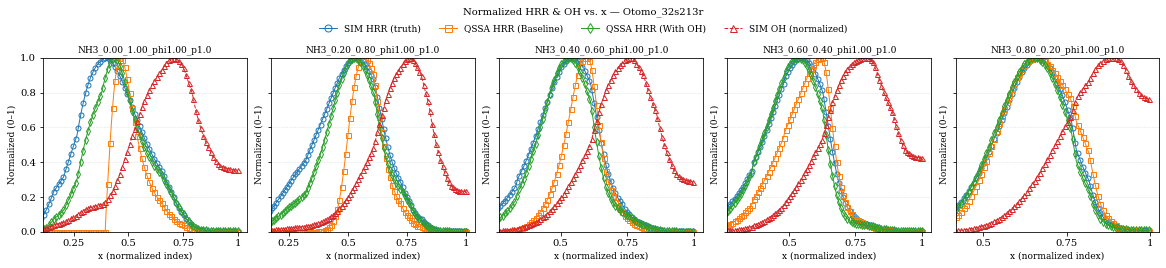

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter

# ─── User-adjustable settings ──────────────────────────────────────────────────
data_path    = "cases"
sim_case     = "NH3_premixed_matrix_1bar/Sim"
qssa_case    = "NH3_premixed_matrix_1bar/Sim_QSSA"
qssa_oh_case = "NH3_premixed_matrix_1bar/Sim_QSSA_withOH"
mechanism    = "Otomo_32s213r"   # single mechanism

target_cases = [
    "NH3_0.00_1.00_phi1.00_p1.0",
    "NH3_0.20_0.80_phi1.00_p1.0",
    "NH3_0.40_0.60_phi1.00_p1.0",
    "NH3_0.60_0.40_phi1.00_p1.0",
    "NH3_0.80_0.20_phi1.00_p1.0",
]

normalize_x   = True
marker_stride = 2
linewidth     = 1.0
markersize    = 5

# ─── Series styles (now 4) ─────────────────────────────────────────────────────
tab10 = plt.get_cmap("tab10").colors
series_info = [
    ("SIM HRR (truth)",       "-", tab10[0], "o"),
    ("QSSA HRR (Baseline)",   "-", tab10[1], "s"),
    ("QSSA HRR (With OH)",    "-", tab10[2], "d"),
    ("SIM OH (normalized)",   "--", tab10[3], "^"),  # NEW: normalized OH from SIM
]

# ─── Helpers ───────────────────────────────────────────────────────────────────
def _find_x_column(df):
    for c in ["x", "X", "pos", "position", "Position", "s", "z", "Z", "r", "y"]:
        if c in df.columns:
            return df[c].to_numpy(dtype=float), c
    return None, None

def _norm(v):
    v = np.asarray(v, dtype=float)
    if v.size == 0: return v
    vmax = np.nanmax(v)
    return v / vmax if np.isfinite(vmax) and vmax > 0 else v

def _scatter_every(ax, x, y, stride, **kw):
    if stride is None or stride <= 1:
        ax.plot(x, y, linestyle="none", **kw)
        return
    idx = np.arange(len(x))[::int(stride)]
    ax.plot(x[idx], y[idx], linestyle="none", **kw)

def load_sim(case):
    fn = os.path.join(data_path, sim_case, mechanism, f"{case}.csv")
    return pd.read_csv(fn, comment="#")

def load_qssa(case):
    fn = os.path.join(data_path, qssa_case, mechanism, case, "predicted_X.csv")
    return pd.read_csv(fn, comment="#") if os.path.isfile(fn) else None

def load_qssa_with_oh(case):
    fn = os.path.join(data_path, qssa_oh_case, mechanism, case, "predicted_X.csv")
    return pd.read_csv(fn, comment="#") if os.path.isfile(fn) else None

# ─── Plotting per case ─────────────────────────────────────────────────────────
def plot_case(ax, case):
    df_sim   = load_sim(case)
    df_qssa  = load_qssa(case)
    df_qsoh  = load_qssa_with_oh(case)

    # x coordinate
    x, xname = _find_x_column(df_sim)
    if x is None:
        x = np.linspace(0, 1, len(df_sim))
        x_label = "x (normalized index)"
    else:
        if normalize_x:
            xmin, xmax = np.nanmin(x), np.nanmax(x)
            x = (x - xmin) / (xmax - xmin + 1e-12)
            x_label = f"{xname} (normalized)"
        else:
            x_label = xname

    # Build curves (3 HRR + 1 OH)
    sim_hrr  = _norm(df_sim["HRR"].to_numpy()) if "HRR" in df_sim.columns else None
    qssa_hrr = _norm(df_qssa["HRR"].to_numpy()) if (df_qssa is not None and "HRR" in df_qssa.columns and len(df_qssa)==len(df_sim)) else None
    qsoh_hrr = _norm(df_qsoh["HRR"].to_numpy()) if (df_qsoh is not None and "HRR" in df_qsoh.columns and len(df_qsoh)==len(df_sim)) else None
    sim_oh   = _norm(df_sim["X_OH"].to_numpy()) if "X_OH" in df_sim.columns else None  # NEW

    curves = [sim_hrr, qssa_hrr, qsoh_hrr, sim_oh]

    # plot
    for (label, ls, color, marker), y in zip(series_info, curves):
        if y is None or len(y) != len(x):
            continue
        ax.plot(x, y, linestyle=ls, color=color, linewidth=linewidth, label=label)
        _scatter_every(ax, x, y, marker_stride,
                       marker=marker, markersize=markersize,
                       markerfacecolor='none', markeredgecolor=color, color=color)

    # unified 0–1 range (so OH isn’t clipped)
    ax.set_ylim(0.0, 1.0)

    # dynamic x-range based on visible curves
    x_min, x_max = None, None
    for y in [c for c in curves if c is not None]:
        mask = y >= 0.2
        if mask.any():
            x_min = np.min(x[mask]) if x_min is None else min(x_min, np.min(x[mask]))
            x_max = np.max(x[mask]) if x_max is None else max(x_max, np.max(x[mask]))
    if x_min is not None and x_max is not None:
        span = x_max - x_min
        ax.set_xlim(x_min - 0.05*span, x_max + 0.05*span)

    # labels / grid
    ax.set_title(case, fontsize=9)
    ax.set_ylabel("Normalized (0–1)", fontsize=9)   # updated label
    ax.set_xlabel(x_label, fontsize=9)
    ax.grid(True, axis="y", linestyle=":", linewidth=0.6, alpha=0.6)

    if "normalized" in x_label or "index" in x_label:
        ticks = [0.0, 0.25, 0.5, 0.75, 1.0]
        ax.xaxis.set_major_locator(FixedLocator(ticks))
        ax.xaxis.set_major_formatter(FixedFormatter([f"{t:g}" for t in ticks]))

# ─── Figure layout & render ────────────────────────────────────────────────────
def plot_hrr_over_x_by_cases(cases, out_png):
    n = len(cases)
    fig, axes = plt.subplots(1, n, figsize=(4.0 * n, 3.2), sharey=True,
                             gridspec_kw={"wspace": 0.12})
    if n == 1:
        axes = [axes]

    for ax, case in zip(axes, cases):
        try:
            plot_case(ax, case)
        except FileNotFoundError:
            ax.text(0.5, 0.5, f"Missing data\n{case}", ha="center", va="center", fontsize=9)
            ax.set_axis_off()

    # legend for the 4 series
    handles = []
    for label, ls, color, marker in series_info:
        h, = plt.plot([], [], color=color, linestyle=ls, marker=marker,
                      markerfacecolor='none', markeredgecolor=color,
                      linewidth=linewidth, markersize=7, label=label)
        handles.append(h)
    fig.legend(handles, [s[0] for s in series_info],
               loc="upper center", ncol=len(series_info),
               frameon=False, fontsize=9, bbox_to_anchor=(0.5, 1.06))

    fig.suptitle(f"Normalized HRR & OH vs. x — {mechanism}", y=1.10, fontsize=10)
    fig.tight_layout(rect=[0, 0, 1, 0.98])

    os.makedirs("figs/validation", exist_ok=True)
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    print(f"→ Saved figure at: {out_png}")

# ─── Run ───────────────────────────────────────────────────────────────────────
plot_hrr_over_x_by_cases(
    cases=target_cases,
    out_png=f"figs/validation/HRR_over_x_{mechanism}.png",
)

# HRR_vs_variants_premixed_H2ratio

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import FixedLocator, FixedFormatter

# ─── User-adjustable settings ─────────────────────────────────────────────────
data_path = "cases"
# Premixed folders (fixed)
sim_case  = "NH3_premixed_matrix_1bar/Sim"
qssa_case = "NH3_premixed_matrix_1bar/Sim_QSSA"

# Mechanism fixed to Otomo
mech = "Han_35s177r"

# Panels: one per case
target_cases = [
    "NH3_0.20_0.80_phi0.80_p1.0",
    "NH3_0.40_0.60_phi0.80_p1.0",
    "NH3_0.60_0.40_phi0.80_p1.0",
    "NH3_0.80_0.20_phi0.80_p1.0",
    "NH3_1.00_0.00_phi0.80_p1.0",
]

marker_stride = 1  # plot every Nth marker (1 = all)

# ─── Colors & series styles ───────────────────────────────────────────────────
tab10 = plt.get_cmap("tab10").colors
series_colors = {
    "$y = x$":             "k",
    "QSSA HRR (Baseline)": tab10[0],
    "[OH][NH₃]":           tab10[1],
    "[NH]":                tab10[2],
    "[OH]":                tab10[3],
}
series_info = [
    ("$y = x$",             "--", series_colors["$y = x$"],             None),
    ("QSSA HRR (Baseline)", "-",  series_colors["QSSA HRR (Baseline)"], "s"),
    ("[OH][NH₃]",            "-",  series_colors["[OH][NH₃]"],           "v"),
    ("[NH]",                 "-",  series_colors["[NH]"],                "^"),
    ("[OH]",                 "-",  series_colors["[OH]"],                "d"),
]

def _scatter_every(ax, xv, yv, stride, **kw):
    if stride is None or stride <= 1:
        ax.scatter(xv, yv, **kw)
    else:
        idx = np.arange(len(xv))[::int(stride)]
        ax.scatter(xv[idx], yv[idx], **kw)


def _parse_case_title(case: str) -> str:
    """
    Extract NH3 and H2 fractions (omit pressure) from a case string like:
        NH3_0.20_0.80_phi0.80_p1.0
    Output example:
        NH₃:0.20   H₂:0.80
    """
    import re
    m = re.match(
        r"^NH3_(?P<nh3>[0-9.]+)_(?P<h2>[0-9.]+)_phi(?P<phi>[0-9.]+)_p(?P<p>[0-9.]+)$",
        case
    )
    if not m:
        return case
    return (
        rf"$\mathrm{{NH_3}}:{m.group('nh3')}\;\ "
        rf"\mathrm{{H_2}}:{m.group('h2')}$"
    )

def plot_one_case(ax, case_name, is_first_col=False, marker_stride=1):
    # Load SIM
    sim_csv = os.path.join(data_path, sim_case, mech, f"{case_name}.csv")
    df_sim  = pd.read_csv(sim_csv, comment="#")

    # Load QSSA (baseline)
    qssa_csv = os.path.join(data_path, qssa_case, mech, case_name, "predicted_X.csv")
    df_qssa  = pd.read_csv(qssa_csv, comment="#")

    # Normalize HRR
    sim_hrr_norm  = df_sim["HRR"].to_numpy(dtype=float)
    sim_hrr_norm /= np.nanmax(sim_hrr_norm)

    qssa_hrr_norm = df_qssa["HRR"].to_numpy(dtype=float)
    qssa_hrr_norm /= np.nanmax(qssa_hrr_norm)

    def _norm(v):
        if v is None:
            return None
        vmax = np.nanmax(v)
        return v / vmax if np.isfinite(vmax) and vmax > 0 else v

    X_OH  = _norm(df_sim["X_OH"].to_numpy())  if "X_OH"  in df_sim.columns else None
    X_NH3 = _norm(df_sim["X_NH3"].to_numpy()) if "X_NH3" in df_sim.columns else None
    X_NH  = _norm(df_sim["X_NH"].to_numpy())  if "X_NH"  in df_sim.columns else None

    oh_nh3 = _norm(X_OH * X_NH3) if (X_OH is not None and X_NH3 is not None) else None

    variants = [
        (sim_hrr_norm, sim_hrr_norm),
        (qssa_hrr_norm, sim_hrr_norm),
        (oh_nh3,        sim_hrr_norm),
        (X_NH,          sim_hrr_norm),
        (X_OH,          sim_hrr_norm),
    ]

    for (label, ls, color, marker), (xv, yv) in zip(series_info, variants):
        if xv is None or yv is None:
            continue
        ax.plot(xv, yv, linestyle=ls, color=color, linewidth=1 if marker is None else 0.8)
        if marker is not None:
            _scatter_every(ax, xv, yv, marker_stride,
                           s=18, marker=marker, facecolors='none',
                           edgecolors=color, label=label)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal', adjustable='box')
    ticks = [0, 0.25, 0.5, 0.75, 1]
    ax.xaxis.set_major_locator(FixedLocator(ticks))
    ax.yaxis.set_major_locator(FixedLocator(ticks))
    ax.xaxis.set_major_formatter(FixedFormatter([str(t) for t in ticks]))
    ax.yaxis.set_major_formatter(FixedFormatter([str(t) for t in ticks]))
    ax.tick_params(axis='both', which='major', labelsize=7)

    ax.set_xlabel("Normalized predictor", fontsize=8)
    if is_first_col:
        ax.set_ylabel("Normalized HRR", fontsize=8)

    ax.set_title(_parse_case_title(case_name), fontsize=8, pad=4)

# ─── Figure setup ─────────────────────────────────────────────────────────────
fig, axes = plt.subplots(
    1, len(target_cases),
    figsize=(2.9 * len(target_cases), 2.8),
    sharex=True, sharey=True,
    gridspec_kw={'wspace': 0.08}
)
axes = np.atleast_1d(axes)

for idx, (ax, case) in enumerate(zip(axes, target_cases)):
    plot_one_case(ax, case, is_first_col=(idx == 0), marker_stride=marker_stride)

# ─── Shared legend ────────────────────────────────────────────────────────────
handles, labels = [], []
for label, ls, color, marker in series_info:
    if marker is None:
        h = Line2D([0],[0], linestyle=ls, color=color, linewidth=1)
    else:
        h = Line2D([0],[0], linestyle=ls, color=color,
                   marker=marker, markerfacecolor='none',
                   markeredgecolor=color, markersize=6.5, linewidth=0.8)
    handles.append(h); labels.append(label)

fig.legend(handles, labels, loc='upper center', ncol=len(handles),
           frameon=False, fontsize=8, bbox_to_anchor=(0.5, 1.02))

fig.tight_layout(rect=[0,0,1,0.93])
os.makedirs("figs/validation", exist_ok=True)
out = "figs/validation/HRR_vs_variants_by_case_premixed_Otomo.png"
plt.savefig(out, dpi=300, bbox_inches='tight')
plt.show()

print(f"→ Saved figure at: {out}")

# Figure 5: Combine Premixed Figures 

→ Saved NMSE grid figure at: figs/validation/Fig5_NMSE_vs_phi_grid_ALL.pdf


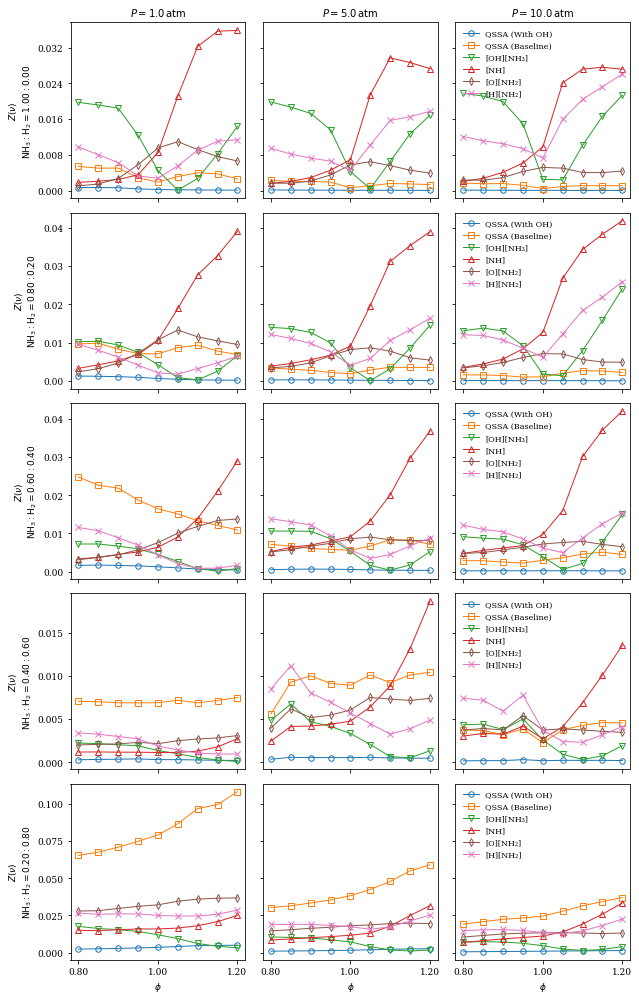

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FixedLocator, FormatStrFormatter
import matplotlib as mpl

# ─── Settings ─────────────────────────────────────────────────────────────────
data_path    = "cases"
sim_case     = "NH3_premixed_matrix_1bar/Sim"
qssa_case    = "NH3_premixed_matrix_1bar/Sim_QSSA"
qssa_oh_case = "NH3_premixed_matrix_1bar/Sim_QSSA_withOH"

mech       = "Han_35s177r"
base_cases = [
    "NH3_1.00_0.00",
    "NH3_0.80_0.20",
    "NH3_0.60_0.40",
    "NH3_0.40_0.60",
    "NH3_0.20_0.80",
    # "NH3_0.00_1.00",  # ← removed (pure H2)
]
phis       = ["0.80", "0.85", "0.90", "0.95", "1.00", "1.05", "1.10", "1.15", "1.20"]
pressures  = ["1.0", "5.0", "10.0"]
temp_threshold = 300.0  # K

# ─── Global styling ───────────────────────────────────────────────────────────
mpl.rcParams['xtick.labelsize'] = 9
mpl.rcParams['ytick.labelsize'] = 9

# ─── Helpers ─────────────────────────────────────────────────────────────────
def norm(arr):
    arr = np.asarray(arr, dtype=float)
    if arr.size == 0:
        return arr
    m = np.nanmax(arr)
    return arr / m if m and np.isfinite(m) and m > 0 else arr

def nmse(a, b):
    if a is None or b is None:
        return np.nan
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    if a.size == 0 or b.size == 0 or a.shape != b.shape:
        return np.nan
    return np.nanmean((a - b) ** 2)

def build_temp_mask(sim_df, thr=temp_threshold):
    if "T" not in sim_df.columns:
        return None
    T = pd.to_numeric(sim_df["T"], errors="coerce").to_numpy()
    if T.size == 0:
        return None
    mask = np.isfinite(T) & (T > float(thr))
    return mask if np.any(mask) else None

def norm_masked(series, mask):
    if series is None:
        return None
    a = np.asarray(series, dtype=float)
    if a.shape[0] != mask.shape[0]:
        return None
    a = a[mask]
    return norm(a) if a.size > 0 else None

# ─── Loaders ─────────────────────────────────────────────────────────────────
def load_sim(case_name):
    fn = os.path.join(data_path, sim_case, mech, case_name + ".csv")
    return pd.read_csv(fn, comment="#")

def load_qssa(case_name):
    fn = os.path.join(data_path, qssa_case, mech, case_name, "predicted_X.csv")
    return pd.read_csv(fn, comment="#")

def load_qssa_with_oh(case_name):
    fn = os.path.join(data_path, qssa_oh_case, mech, case_name, "predicted_X.csv")
    return pd.read_csv(fn, comment="#")

# ─── Series universe ─────────────────────────────────────────────────────────
tab10 = plt.get_cmap("tab10").colors
ALL_LABELS = [
    "QSSA (With OH)",
    "QSSA (Baseline)",
    "[OH][NH₃]",
    "[NH]",
    "[O][NH₂]",
    "[H][NH₂]",
    "[OH]",      # SIM normalized OH (used only for pure H2 row if present)
    "[HO2]",     # SIM normalized HO2 (used only for pure H2 row if present)
]

STYLE = {
    "QSSA (With OH)" : dict(ls="-", marker="o", color=tab10[0]),
    "QSSA (Baseline)": dict(ls="-", marker="s", color=tab10[1]),
    "[OH][NH₃]"      : dict(ls="-", marker="v", color=tab10[2]),
    "[NH]"           : dict(ls="-", marker="^", color=tab10[3]),
    "[O][NH₂]"       : dict(ls="-", marker="d", color=tab10[5]),
    "[H][NH₂]"       : dict(ls="-", marker="x", color=tab10[6]),
    "[OH]"           : dict(ls="-", marker="D", color=tab10[4]),
    "[HO2]"          : dict(ls="-", marker="P", color=tab10[9]),
}

# ─── Error kernel ─────────────────────────────────────────────────────────────
def method_errors(sim_df, qssa_df, qssa_oh_df):
    out = {k: np.nan for k in ALL_LABELS}
    if sim_df is None or "HRR" not in sim_df.columns:
        return out

    mask = build_temp_mask(sim_df, temp_threshold)
    if mask is None:
        return out

    sim_hrr_masked = norm_masked(sim_df["HRR"].to_numpy(), mask)

    Tmax = pd.to_numeric(sim_df.get("T", pd.Series([np.inf])), errors="coerce").max(skipna=True)
    if pd.notna(Tmax) and Tmax < 400:
        return out

    qssa_norm_masked    = norm_masked(qssa_df["HRR"].to_numpy(), mask)    if (qssa_df is not None and "HRR" in qssa_df.columns) else None
    qssa_oh_norm_masked = norm_masked(qssa_oh_df["HRR"].to_numpy(), mask) if (qssa_oh_df is not None and "HRR" in qssa_oh_df.columns) else None

    # SIM species columns if present
    def col(name):
        return sim_df[name].to_numpy() if name in sim_df.columns else None

    X_OH   = col("X_OH")
    X_HO2  = col("X_HO2")
    X_NH3  = col("X_NH3")
    X_NH   = col("X_NH")
    X_O    = col("X_O")
    X_NH2  = col("X_NH2")
    X_H    = col("X_H")

    oh_nh3 = (X_OH * X_NH3) if (X_OH is not None and X_NH3 is not None) else None
    o_nh2  = (X_O  * X_NH2) if (X_O  is not None and X_NH2 is not None) else None
    h_nh2  = (X_H  * X_NH2) if (X_H  is not None and X_NH2 is not None) else None

    out.update({
        "QSSA (With OH)" : nmse(sim_hrr_masked, qssa_oh_norm_masked),
        "QSSA (Baseline)": nmse(sim_hrr_masked, qssa_norm_masked),
        "[OH][NH₃]"      : nmse(sim_hrr_masked, norm_masked(oh_nh3, mask) if oh_nh3 is not None else None),
        "[NH]"           : nmse(sim_hrr_masked, norm_masked(X_NH,  mask) if X_NH  is not None else None),
        "[O][NH₂]"       : nmse(sim_hrr_masked, norm_masked(o_nh2,  mask) if o_nh2 is not None else None),
        "[H][NH₂]"       : nmse(sim_hrr_masked, norm_masked(h_nh2,  mask) if h_nh2 is not None else None),
        "[OH]"           : nmse(sim_hrr_masked, norm_masked(X_OH,   mask) if X_OH  is not None else None),
        "[HO2]"          : nmse(sim_hrr_masked, norm_masked(X_HO2,  mask) if X_HO2 is not None else None),
    })
    return out

# ─── Row label helper ────────────────────────────────────────────────────────
def blend_ylabel(case_str):
    try:
        _, nh3, h2 = case_str.split("_")
        return r"$Z(\nu)$""\n" + rf"$\mathrm{{NH_3}}:\mathrm{{H_2}}={nh3}:{h2}$"
    except Exception:
        return  r"$Z(\nu)$"

# ─── Compute errors for one base_case ─────────────────────────────────────────
def compute_errors_for_base(base_case):
    errors = {p: {name: [] for name in ALL_LABELS} for p in pressures}
    for p in pressures:
        for phi in phis:
            case = f"{base_case}_phi{phi}_p{p}"
            try:
                sim = load_sim(case)
            except FileNotFoundError:
                for name in ALL_LABELS:
                    errors[p][name].append(np.nan)
                continue
            try:
                qssa = load_qssa(case)
            except FileNotFoundError:
                qssa = None
            try:
                qssa_oh = load_qssa_with_oh(case)
            except FileNotFoundError:
                qssa_oh = None
            errs = method_errors(sim, qssa, qssa_oh)
            for name in ALL_LABELS:
                errors[p][name].append(errs[name])
    return errors

# ─── Plot all blends × pressures ──────────────────────────────────────────────
def plot_nmse_grid(base_cases, out_path, width_per_col=2.7, height_per_row=2.9):
    """
    Pure-H2 row removed. All rows use the standard set:
      QSSA(With OH), QSSA(Baseline), [OH][NH3], [NH], [O][NH2], [H][NH2]
    """
    n_rows = len(base_cases)
    n_cols = len(pressures)
    fig_w  = width_per_col * n_cols
    fig_h  = height_per_row * n_rows

    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(fig_w, fig_h), sharex=True, sharey='row'
    )
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes[np.newaxis, :]
    elif n_cols == 1:
        axes = axes[:, np.newaxis]

    x = [float(phi) for phi in phis]
    tick_phi = [0.80, 1.00, 1.20]

    # Column titles (pressures)
    for j, p in enumerate(pressures):
        ax = axes[0, j]
        ax.set_title(rf"$P={p}\,\mathrm{{atm}}$", fontsize=10, fontfamily='serif')

    # Plot rows
    for i, base_case in enumerate(base_cases):
        errors = compute_errors_for_base(base_case)
        labels_to_plot = ["QSSA (With OH)", "QSSA (Baseline)", "[OH][NH₃]", "[NH]", "[O][NH₂]", "[H][NH₂]"]

        for j, p in enumerate(pressures):
            ax = axes[i, j]
            for name in labels_to_plot:
                y = errors[p][name]
                st = STYLE[name]
                ax.plot(
                    x, y,
                    label=name,
                    linestyle=st["ls"],
                    marker=st["marker"],
                    markersize=5.5,
                    linewidth=1.0,
                    color=st["color"],
                    markerfacecolor='none',
                    markeredgecolor=st["color"],
                )

            # Axes cosmetics
            ax.xaxis.set_major_locator(FixedLocator(tick_phi))
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

            if i == n_rows - 1:
                ax.set_xlabel(r"$\phi$", fontsize=9)
            if j == 0:
                ax.set_ylabel(blend_ylabel(base_case), fontsize=9)

            # Legend on the last subplot of EACH ROW
            if j == n_cols - 1:
                handles, labels_leg = ax.get_legend_handles_labels()
                ax.legend(handles, labels_leg, loc='upper left', frameon=False, fontsize=8)

    plt.tight_layout()
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    print(f"→ Saved NMSE grid figure at: {out_path}")

# ─── Run ─────────────────────────────────────────────────────────────────────
plot_nmse_grid(
    base_cases=base_cases,
    out_path="figs/validation/Fig5_NMSE_vs_phi_grid_ALL.pdf",
    width_per_col=3.0,
    height_per_row=2.8,
)

# Tabel for Premixed-Flames

In [7]:
# ─── Table: per-blend summary at p=1.0 atm ───────────────────────────────────
FLAME_MARKERS_FOR_TABLE = [
    "QSSA (With OH)",
    "QSSA (Baseline)",
    "[OH][NH₃]",
    "[NH]",
    "[O][NH₂]",
    "[H][NH₂]",
]

def _parse_blend_label(base_case: str) -> str:
    try:
        _, nh3, h2 = base_case.split("_")
        return rf"$\mathrm{{NH_3}}:{nh3},\;\mathrm{{H_2}}:{h2}$"
    except Exception:
        return base_case

def _blend_frac(base_case: str) -> float:
    try:
        _, nh3, h2 = base_case.split("_")
        nh3 = float(nh3); h2 = float(h2)
        return h2/(nh3+h2) if (nh3+h2) > 0 else 0.0
    except Exception:
        return np.nan

def build_summary_table_for_p(base_cases, pressure="1.0", metric_mode="nmse_max"):
    """
    metric_mode:
      - 'nmse_max' : report max NMSE over φ (matches plotted curves)
      - 'Zmax'     : report max Z(ν)=1-NMSE over φ  (= 1 - min NMSE)
    """
    rows, labels, h2_fracs = [], [], []
    for base in base_cases:
        errs = compute_errors_for_base(base)  # {p: {marker: [nmse(phi_i), ...]}}
        nmse_dict = errs.get(pressure, {})
        row = {}
        for marker in FLAME_MARKERS_FOR_TABLE:
            vals = np.asarray(nmse_dict.get(marker, []), dtype=float)
            if vals.size == 0 or np.all(np.isnan(vals)):
                row[marker] = np.nan
            else:
                if metric_mode == "nmse_max":
                    row[marker] = np.nanmax(vals)
                elif metric_mode == "Zmax":
                    row[marker] = 1.0 - np.nanmin(vals)
                else:
                    raise ValueError("metric_mode must be 'nmse_max' or 'Zmax'")
        rows.append(row)
        labels.append(_parse_blend_label(base))
        h2_fracs.append(_blend_frac(base))

    # Build DF and sort by H2 fraction
    df = pd.DataFrame(rows, index=labels, columns=FLAME_MARKERS_FOR_TABLE)
    order = np.argsort(h2_fracs)
    df = df.iloc[order]

    # Column display names for LaTeX
    df = df.rename(columns={
        "QSSA (With OH)": r"QSSA (with OH)",
        "QSSA (Baseline)": r"QSSA (baseline)",
        "[OH][NH₃]"      : r"$[\mathrm{OH}][\mathrm{NH_3}]$",
        "[NH]"           : r"$[\mathrm{NH}]$",
        "[O][NH₂]"       : r"$[\mathrm{O}][\mathrm{NH_2}]$",
        "[H][NH₂]"       : r"$[\mathrm{H}][\mathrm{NH_2}]$",
    })
    return df

# ---- Build & save (choose the mode below) ----
TABLE_MODE = "nmse_max"   # use "Zmax" if you truly want Z(ν)=1−NMSE
df_summary = build_summary_table_for_p(base_cases, pressure="1.0", metric_mode=TABLE_MODE)

print(f"\nSummary table at p=1.0 atm ({TABLE_MODE} over φ):")
print(df_summary.round(3))

# Write LaTeX (no jinja2 required)
os.makedirs("figs/tables", exist_ok=True)
latex_path = f"figs/tables/p1.0_{TABLE_MODE}_table.tex"
with open(latex_path, "w", encoding="utf-8") as f:
    f.write(df_summary.to_latex(
        na_rep="--",
        float_format=lambda x: f"{x:.3f}",
        escape=False,
        column_format="l" + "c"*df_summary.shape[1]
    ))
print(f"→ wrote LaTeX table to: {latex_path}")


Summary table at p=1.0 atm (nmse_max over φ):
                                          QSSA (with OH)  QSSA (baseline)  \
$\mathrm{NH_3}:1.00,\;\mathrm{H_2}:0.00$           0.001            0.005   
$\mathrm{NH_3}:0.80,\;\mathrm{H_2}:0.20$           0.001            0.010   
$\mathrm{NH_3}:0.60,\;\mathrm{H_2}:0.40$           0.002            0.025   
$\mathrm{NH_3}:0.40,\;\mathrm{H_2}:0.60$           0.000            0.007   
$\mathrm{NH_3}:0.20,\;\mathrm{H_2}:0.80$           0.005            0.108   

                                          $[\mathrm{OH}][\mathrm{NH_3}]$  \
$\mathrm{NH_3}:1.00,\;\mathrm{H_2}:0.00$                           0.020   
$\mathrm{NH_3}:0.80,\;\mathrm{H_2}:0.20$                           0.010   
$\mathrm{NH_3}:0.60,\;\mathrm{H_2}:0.40$                           0.007   
$\mathrm{NH_3}:0.40,\;\mathrm{H_2}:0.60$                           0.002   
$\mathrm{NH_3}:0.20,\;\mathrm{H_2}:0.80$                           0.018   

                                 

#  Figure 6:  Combine different figures for H2


→ Saved NMSE grid figure at: figs/validation/Fig6_Z_vs_phi_grid_H2.pdf


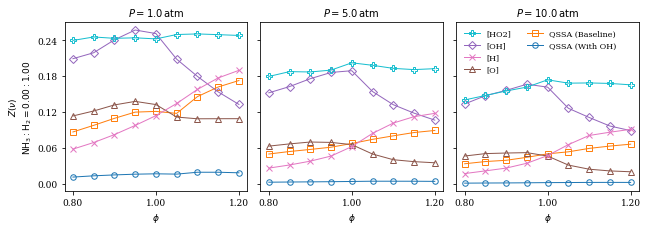

In [55]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FixedLocator, FormatStrFormatter
import matplotlib as mpl
from matplotlib.lines import Line2D

# ─── Settings ─────────────────────────────────────────────────────────────────
data_path    = "cases"
sim_case     = "NH3_premixed_matrix_1bar/Sim"
qssa_case    = "NH3_premixed_matrix_1bar/Sim_QSSA"
qssa_oh_case = "NH3_premixed_matrix_1bar/Sim_QSSA_withOH"

mech       = "Han_35s177r"
base_cases = [
    "NH3_0.00_1.00",   # pure H2 only
]
phis       = ["0.80", "0.85", "0.90", "0.95", "1.00", "1.05", "1.10", "1.15", "1.20"]
pressures  = ["1.0", "5.0", "10.0"]
temp_threshold = 300.0  # K

# ─── Global styling ───────────────────────────────────────────────────────────
mpl.rcParams['xtick.labelsize'] = 9
mpl.rcParams['ytick.labelsize'] = 9

# ─── Helpers ─────────────────────────────────────────────────────────────────
def norm(arr):
    arr = np.asarray(arr, dtype=float)
    if arr.size == 0:
        return arr
    m = np.nanmax(arr)
    return arr / m if m and np.isfinite(m) and m > 0 else arr

def nmse(a, b):
    if a is None or b is None:
        return np.nan
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    if a.size == 0 or b.size == 0 or a.shape != b.shape:
        return np.nan
    return np.nanmean((a - b) ** 2)

def build_temp_mask(sim_df, thr=temp_threshold):
    if "T" not in sim_df.columns:
        return None
    T = pd.to_numeric(sim_df["T"], errors="coerce").to_numpy()
    if T.size == 0:
        return None
    mask = np.isfinite(T) & (T > float(thr))
    return mask if np.any(mask) else None

def norm_masked(series, mask):
    if series is None:
        return None
    a = np.asarray(series, dtype=float)
    if a.shape[0] != mask.shape[0]:
        return None
    a = a[mask]
    return norm(a) if a.size > 0 else None

# ─── Loaders ─────────────────────────────────────────────────────────────────
def load_sim(case_name):
    fn = os.path.join(data_path, sim_case, mech, case_name + ".csv")
    return pd.read_csv(fn, comment="#")

def load_qssa(case_name):
    fn = os.path.join(data_path, qssa_case, mech, case_name, "predicted_X.csv")
    return pd.read_csv(fn, comment="#")

def load_qssa_with_oh(case_name):
    fn = os.path.join(data_path, qssa_oh_case, mech, case_name, "predicted_X.csv")
    return pd.read_csv(fn, comment="#")

# ─── Series universe (H2-only markers) ───────────────────────────────────────
tab10 = plt.get_cmap("tab10").colors
ALL_LABELS = [
    "QSSA (With OH)",
    "QSSA (Baseline)",
    "[O]",       # SIM normalized atomic oxygen
    "[OH]",      # SIM normalized hydroxyl
    "[HO2]",     # SIM normalized hydroperoxyl
    "[H]",       # SIM normalized hydrogen radical
]

STYLE = {
    "QSSA (With OH)" : dict(ls="-", marker="o", color=tab10[0]),
    "QSSA (Baseline)": dict(ls="-", marker="s", color=tab10[1]),
    "[O]"            : dict(ls="-", marker="^", color=tab10[5]),
    "[OH]"           : dict(ls="-", marker="D", color=tab10[4]),
    "[HO2]"          : dict(ls="-", marker="P", color=tab10[9]),
    "[H]"            : dict(ls="-", marker="x", color=tab10[6]),
}

# ─── Error kernel (computes NMSE vs. SIM HRR for requested markers) ──────────
def method_errors(sim_df, qssa_df, qssa_oh_df):
    out = {k: np.nan for k in ALL_LABELS}
    if sim_df is None or "HRR" not in sim_df.columns:
        return out

    mask = build_temp_mask(sim_df, temp_threshold)
    if mask is None:
        return out

    sim_hrr_masked = norm_masked(sim_df["HRR"].to_numpy(), mask)

    Tmax = pd.to_numeric(sim_df.get("T", pd.Series([np.inf])), errors="coerce").max(skipna=True)
    if pd.notna(Tmax) and Tmax < 400:
        return out

    qssa_norm_masked    = norm_masked(qssa_df["HRR"].to_numpy(), mask)    if (qssa_df is not None and "HRR" in qssa_df.columns) else None
    qssa_oh_norm_masked = norm_masked(qssa_oh_df["HRR"].to_numpy(), mask) if (qssa_oh_df is not None and "HRR" in qssa_oh_df.columns) else None

    # SIM species columns (robust to missing)
    def col(name):
        return sim_df[name].to_numpy() if name in sim_df.columns else None

    X_O   = col("X_O")
    X_OH  = col("X_OH")
    X_HO2 = col("X_HO2")
    X_H   = col("X_H")

    out.update({
        "QSSA (With OH)" : nmse(sim_hrr_masked, qssa_oh_norm_masked),
        "QSSA (Baseline)": nmse(sim_hrr_masked, qssa_norm_masked),
        "[O]"            : nmse(sim_hrr_masked, norm_masked(X_O,   mask) if X_O   is not None else None),
        "[OH]"           : nmse(sim_hrr_masked, norm_masked(X_OH,  mask) if X_OH  is not None else None),
        "[HO2]"          : nmse(sim_hrr_masked, norm_masked(X_HO2, mask) if X_HO2 is not None else None),
        "[H]"            : nmse(sim_hrr_masked, norm_masked(X_H,   mask) if X_H   is not None else None),
    })
    return out

# ─── Row label helper ────────────────────────────────────────────────────────
def blend_ylabel(case_str):
    try:
        _, nh3, h2 = case_str.split("_")
        return r"$Z(\nu)$" + "\n" + rf"$\mathrm{{NH_3}}:\mathrm{{H_2}}={nh3}:{h2}$"
    except Exception:
        return r"$Z(\nu)$"

# ─── Compute errors for one base_case ─────────────────────────────────────────
def compute_errors_for_base(base_case):
    errors = {p: {name: [] for name in ALL_LABELS} for p in pressures}
    for p in pressures:
        for phi in phis:
            case = f"{base_case}_phi{phi}_p{p}"
            try:
                sim = load_sim(case)
            except FileNotFoundError:
                for name in ALL_LABELS:
                    errors[p][name].append(np.nan)
                continue
            try:
                qssa = load_qssa(case)
            except FileNotFoundError:
                qssa = None
            try:
                qssa_oh = load_qssa_with_oh(case)
            except FileNotFoundError:
                qssa_oh = None
            errs = method_errors(sim, qssa, qssa_oh)
            for name in ALL_LABELS:
                errors[p][name].append(errs[name])
    return errors

# ─── Uneven legend helper: supports any [left_count, right_count] ────────────
def uneven_legend(ax, handles, labels, left_count, right_count, **legkw):
    """
    Build a 2-column legend with uneven rows per column (e.g., [4,2]).
    The first 'left_count' items appear in the left column; remaining go right.
    """
    assert left_count + right_count == len(handles) == len(labels), "counts must match data"
    rows = max(left_count, right_count)
    dummy = Line2D([], [], linewidth=0, alpha=0)   # invisible pad

    left_h  = handles[:left_count] + [dummy] * (rows - left_count)
    left_l  = labels[:left_count]  + ['']    * (rows - left_count)

    right_h = handles[left_count:] + [dummy] * (rows - right_count)
    right_l = labels[left_count:]  + ['']    * (rows - right_count)

    HH = left_h + right_h  # column-major block
    LL = left_l + right_l

    leg = ax.legend(HH, LL, ncol=2, **legkw)   # note: ncol (not ncols)
    leg.set_in_layout(False)
    return leg

# ─── Plot grid (pure H2 row only) ────────────────────────────────────────────
def plot_nmse_grid(base_cases, out_path, width_per_col=2.7, height_per_row=3.2):
    """
    Pure H2: plot QSSA (Baseline), QSSA (With OH), and SIM markers [O], [OH], [HO2], [H].
    """
    n_rows = len(base_cases)
    n_cols = len(pressures)
    fig_w  = width_per_col * n_cols
    fig_h  = height_per_row * n_rows

    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(fig_w, fig_h), sharex=True, sharey='row'
    )
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes[np.newaxis, :]
    elif n_cols == 1:
        axes = axes[:, np.newaxis]

    x = [float(phi) for phi in phis]
    tick_phi = [0.80, 1.00, 1.20]

    # Column titles (pressures)
    for j, p in enumerate(pressures):
        ax = axes[0, j]
        ax.set_title(rf"$P={p}\,\mathrm{{atm}}$", fontsize=10, fontfamily='serif')

    # Only one row (pure H2)
    for i, base_case in enumerate(base_cases):
        errors = compute_errors_for_base(base_case)
        labels_to_plot = ["QSSA (With OH)", "QSSA (Baseline)", "[O]", "[OH]", "[HO2]", "[H]"]

        for j, p in enumerate(pressures):
            ax = axes[i, j]
            for name in labels_to_plot:
                y = errors[p][name]
                st = STYLE[name]
                ax.plot(
                    x, y,
                    label=name,
                    linestyle=st["ls"],
                    marker=st["marker"],
                    markersize=5.5,
                    linewidth=1.0,
                    color=st["color"],
                    markerfacecolor='none',
                    markeredgecolor=st["color"],
                )

            # Axes cosmetics
            ax.xaxis.set_major_locator(FixedLocator(tick_phi))
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

            ax.set_xlabel(r"$\phi$", fontsize=9)
            if j == 0:
                ax.set_ylabel(blend_ylabel(base_case), fontsize=9)

            # Uneven legend on the last subplot: [4,2]
            # Left column (4 items) in the order: [HO2, OH, H, O]
            if j == n_cols - 1:
                all_handles, all_labels = ax.get_legend_handles_labels()
                handle_map = {lab: h for h, lab in zip(all_handles, all_labels)}

                left_labels  = ["[HO2]", "[OH]", "[H]", "[O]"]
                right_labels = ["QSSA (Baseline)", "QSSA (With OH)"]

                # Ensure all requested labels exist
                left_handles  = [handle_map[l] for l in left_labels if l in handle_map]
                right_handles = [handle_map[l] for l in right_labels if l in handle_map]

                # Guard: only proceed if we have the full set (4+2)
                if len(left_handles) == 4 and len(right_handles) == 2:
                    handles_ordered = left_handles + right_handles
                    labels_ordered  = left_labels  + right_labels

                    leg = uneven_legend(
                        ax,
                        handles_ordered, labels_ordered,
                        left_count=4, right_count=2,
                        loc='upper left',
                        frameon=False,
                        fontsize=8,
                        # Optional spacing knobs:
                        # labelspacing=0.3, columnspacing=1.0, handletextpad=0.4,
                        # bbox_to_anchor=(0.0, 1.0)
                    )
                    leg.set_zorder(10)
                else:
                    # Fallback: regular legend if some labels are missing
                    ax.legend(all_handles, all_labels, loc='upper left', frameon=False, fontsize=8, ncol=2)

    plt.tight_layout()
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    print(f"→ Saved NMSE grid figure at: {out_path}")

# ─── Run ─────────────────────────────────────────────────────────────────────
plot_nmse_grid(
    base_cases=base_cases,
    out_path="figs/validation/Fig6_Z_vs_phi_grid_H2.pdf",
    width_per_col=3.0,
    height_per_row=3.2,
)

In [10]:
# ─── Table for pure H2 at p = 1.0 atm ────────────────────────────────────────
FLAME_MARKERS_H2 = [
    "QSSA (With OH)",
    "QSSA (Baseline)",
    "[O]",
    "[OH]",
    "[HO2]",
    "[H]",
]

def _parse_blend_label_h2(base_case: str) -> str:
    # base_case like "NH3_0.00_1.00"
    try:
        _, nh3, h2 = base_case.split("_")
        return rf"$\mathrm{{NH_3}}:{nh3},\;\mathrm{{H_2}}:{h2}$"
    except Exception:
        return base_case

def build_summary_table_for_p_H2(base_cases, pressure="1.0", metric_mode="nmse_max"):
    """
    metric_mode:
      - 'nmse_max' : report max NMSE over φ (matches plotted curves)
      - 'Zmax'     : report max Z(ν)=1−NMSE over φ (= 1 − min NMSE)
    """
    rows, labels = [], []
    for base in base_cases:
        errs = compute_errors_for_base(base)  # {p: {marker: [nmse(phi_i), ...]}}
        nmse_dict = errs.get(pressure, {})
        row = {}
        for marker in FLAME_MARKERS_H2:
            vals = np.asarray(nmse_dict.get(marker, []), dtype=float)
            if vals.size == 0 or np.all(np.isnan(vals)):
                row[marker] = np.nan
            else:
                if metric_mode == "nmse_max":
                    row[marker] = np.nanmax(vals)
                elif metric_mode == "Zmax":
                    row[marker] = 1.0 - np.nanmin(vals)
                else:
                    raise ValueError("metric_mode must be 'nmse_max' or 'Zmax'")
        rows.append(row)
        labels.append(_parse_blend_label_h2(base))

    df = pd.DataFrame(rows, index=labels, columns=FLAME_MARKERS_H2)

    # Pretty column names for LaTeX
    df = df.rename(columns={
        "QSSA (With OH)" : r"QSSA (with OH)",
        "QSSA (Baseline)": r"QSSA (baseline)",
        "[O]"            : r"$[\mathrm{O}]$",
        "[OH]"           : r"$[\mathrm{OH}]$",
        "[HO2]"          : r"$[\mathrm{HO_2}]$",
        "[H]"            : r"$[\mathrm{H}]$",
    })
    return df

# ------- build & save (choose the mode) -------
TABLE_MODE_H2 = "nmse_max"  # or "Zmax"
df_h2 = build_summary_table_for_p_H2(base_cases, pressure="1.0", metric_mode=TABLE_MODE_H2)

print(f"\nPure H2 table at p=1.0 atm ({TABLE_MODE_H2} over φ):")
print(df_h2.round(3))

# robust LaTeX writer: try pandas.to_latex, fallback to a simple writer
def _write_latex_tabular_basic(df, path, colfmt=None, digits=3):
    import math
    if colfmt is None:
        colfmt = "l" + "c"*df.shape[1]
    def fmt(x):
        if x is None or (isinstance(x, float) and (math.isnan(x) or math.isinf(x))):
            return "--"
        return f"{x:.{digits}f}" if isinstance(x, float) else str(x)
    lines = [r"\begin{tabular}{"+colfmt+r"}", r"\toprule"]
    # header
    lines.append(" & ".join(["Blend"] + [str(c) for c in df.columns]) + r" \\")
    lines.append(r"\midrule")
    # rows
    for idx, row in df.iterrows():
        lines.append(" & ".join([str(idx)] + [fmt(v) for v in row.to_list()]) + r" \\")
    lines.append(r"\bottomrule")
    lines.append(r"\end{tabular}")
    with open(path, "w", encoding="utf-8") as f:
        f.write("\n".join(lines))

os.makedirs("figs/tables", exist_ok=True)
latex_h2_path = f"figs/tables/p1.0_{TABLE_MODE_H2}_H2_table.tex"

try:
    with open(latex_h2_path, "w", encoding="utf-8") as f:
        f.write(df_h2.to_latex(
            na_rep="--",
            float_format=lambda x: f"{x:.3f}",
            escape=False,
            column_format="l" + "c"*df_h2.shape[1]
        ))
except Exception:
    # fallback (no jinja2 required)
    _write_latex_tabular_basic(df_h2, latex_h2_path, colfmt="l" + "c"*df_h2.shape[1], digits=3)

print(f"→ wrote LaTeX table to: {latex_h2_path}")


Pure H2 table at p=1.0 atm (nmse_max over φ):
                                          QSSA (with OH)  QSSA (baseline)  \
$\mathrm{NH_3}:0.00,\;\mathrm{H_2}:1.00$            0.02            0.173   

                                          $[\mathrm{O}]$  $[\mathrm{OH}]$  \
$\mathrm{NH_3}:0.00,\;\mathrm{H_2}:1.00$           0.138            0.257   

                                          $[\mathrm{HO_2}]$  $[\mathrm{H}]$  
$\mathrm{NH_3}:0.00,\;\mathrm{H_2}:1.00$               0.25            0.19  
→ wrote LaTeX table to: figs/tables/p1.0_nmse_max_H2_table.tex


# Figure 8: Flux Analysis

→ saved figure: figs/reaction_flux/Han_35s177r_fluxshares_phi1.00_p1.0_groupN_HO2block_smooth_splitLegends.pdf
→ saved figure: figs/reaction_flux/Han_35s177r_fluxshares_phi1.00_p1.0_groupN_HO2block_smooth_splitLegends.png


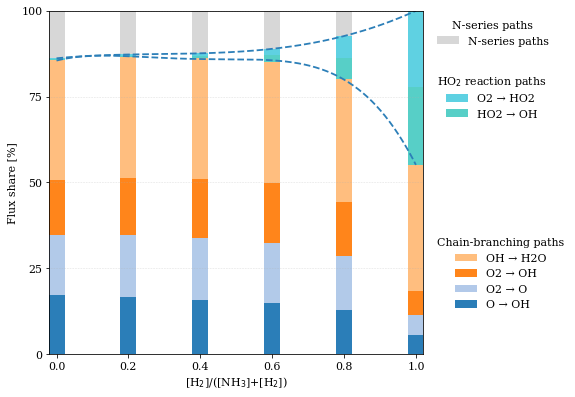

{'figure': <Figure size 720x396 with 1 Axes>,
 'axis': <Axes: xlabel='[H$_2$]/([NH$_3$]+[H$_2$])', ylabel='Flux share [%]'>,
 'x_points': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 'ho2_lower': array([0.85542484, 0.86527228, 0.86381109, 0.85133162, 0.80176208,
        0.55084126]),
 'ho2_upper': array([0.86154248, 0.87276029, 0.87575252, 0.88944356, 0.92624148,
        1.        ]),
 'lower_smooth': (array([0.        , 0.00250627, 0.00501253, 0.0075188 , 0.01002506,
         0.01253133, 0.01503759, 0.01754386, 0.02005013, 0.02255639,
         0.02506266, 0.02756892, 0.03007519, 0.03258145, 0.03508772,
         0.03759398, 0.04010025, 0.04260652, 0.04511278, 0.04761905,
         0.05012531, 0.05263158, 0.05513784, 0.05764411, 0.06015038,
         0.06265664, 0.06516291, 0.06766917, 0.07017544, 0.0726817 ,
         0.07518797, 0.07769424, 0.0802005 , 0.08270677, 0.08521303,
         0.0877193 , 0.09022556, 0.09273183, 0.0952381 , 0.09774436,
         0.10025063, 0.10275689, 0.10526316, 0.10

In [59]:
# -*- coding: utf-8 -*-
from typing import Tuple, List, Dict, Optional
import os, re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ─── Global styling ───────────────────────────────────────────────────────────
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11

def plot_flux_contrib_bars_groupN_HO2block_smooth(
    species_interest: List[str],
    edges: Optional[List[Tuple[str, str]]] = None,
    root_dir: str = "cases/NH3_premixed_matrix_1bar/Sim_QSSA",
    mech: str = "Han_35s177r",
    dot_name: str = "O_rxnpath.dot",
    phi_target: float = 1.00,
    p_target: float = 1.0,
    out_path: str = "figs/reaction_flux/flux_shares_vs_H2frac_groupN_HO2block_smooth.pdf",
    figsize: Tuple[float, float] = (10.0, 5.5),
    xlabel: str = r"[H$_2$]/([NH$_3$]+[H$_2$])",
    ylabel: str = "Flux share (normalized)",
    title: Optional[str] = r"$\phi=1.00,\;p=1.0\ \mathrm{atm}$",
    bar_width: float = 0.045,
    use_percent_y: bool = True,
    min_edge_mag: float = 0.0,

    # Pure directed label value only
    pure_label_only: bool = True,
    flux_metric: str = "label",
    debug: bool = False,
    dpi: int = 300,
    save_formats: Tuple[str, ...] = ("pdf","png"),
    show: bool = True,

    # N-series styling / behavior
    n_series_label: str = "N-series paths",
    n_series_color: str = "lightgray",          # used when expand_N_series=False
    expand_N_series: bool = False,              # expand N edges individually
    n_series_colors: Optional[List[str]] = None,# used when expand_N_series=True

    # HO2 colors in fixed order (HO2→OH, HO2→O2, OH→HO2, O2→HO2)
    ho2_colors: Optional[List[str]] = None,
    ho2_min_contrib: float = 1e-12,             # NEW: threshold to keep/show a HO2 edge

    # Boundary lines
    smooth_method: str = "poly",
    ma_window_frac: float = 0.35,
    smooth_degree: int = 4,
    smooth_points: int = 400,
    ho2_line_color: str = "#2c7fb8",
    ho2_line_width: float = 1.8,
    ho2_line_style: str = "--",

    # Three legends + positions
    n_legend_title: str = "N-series paths",
    n_legend_loc: str = "upper left",
    n_legend_bbox: Tuple[float, float] = (1.02, 1.00),

    ho2_legend_title: str = "HO$_2$ reaction paths",
    ho2_legend_loc: str = "center left",
    ho2_legend_bbox: Tuple[float, float] = (1.02, 0.75),

    other_legend_title: str = "Chain-branching paths",
    other_legend_loc: str = "lower left",
    other_legend_bbox: Tuple[float, float] = (1.02, 0.10),

    reverse_legend_order: bool = True,
):
    # -------------------- helpers --------------------
    def parse_case_name_premixed(case_name: str):
        m = re.match(r'^NH3_([0-9.]+)_([0-9.]+)_phi([0-9.]+)_p([0-9.]+)$', case_name)
        if not m: return None
        nh3 = float(m.group(1)); h2 = float(m.group(2))
        phi = float(m.group(3)); p  = float(m.group(4))
        return nh3, h2, phi, p

    num_rx = r'([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)'
    dot_species_map_cache: Dict[str, Dict[str, str]] = {}

    def species_to_node(dot_path: str, species: str) -> Optional[str]:
        if dot_path not in dot_species_map_cache:
            if not os.path.isfile(dot_path): return None
            with open(dot_path, "r", encoding="utf-8", errors="ignore") as f:
                text = f.read()
            node_rx = re.compile(
                r'^\s*([A-Za-z0-9_]+)\s*\[.*?label\s*=\s*"([^"]+)"\s*\];',
                re.MULTILINE | re.DOTALL
            )
            mapping: Dict[str, str] = {}
            for m in node_rx.finditer(text):
                mapping[m.group(2).strip()] = m.group(1).strip()
            dot_species_map_cache[dot_path] = mapping
        return dot_species_map_cache[dot_path].get(species, None)

    def grab_label_only(dot_path: str, src_node: str, dst_node: str):
        if not os.path.isfile(dot_path):
            return 0.0, False
        with open(dot_path, "r", encoding="utf-8", errors="ignore") as f:
            text = f.read()
        edge_rx = re.compile(rf'{re.escape(src_node)}\s*->\s*{re.escape(dst_node)}\s*\[(.*?)\];', re.DOTALL)
        em = edge_rx.search(text)
        if not em:
            return 0.0, False
        body = em.group(1)
        lab_m = re.search(r'label\s*=\s*"(.*?)"', body, re.DOTALL)
        if not lab_m: return 0.0, False
        first_num = re.search(num_rx, lab_m.group(1))
        if not first_num: return 0.0, False
        try:
            return float(first_num.group(1)), True
        except ValueError:
            return 0.0, False

    def grab_flux(dot_path: str, src_node: str, dst_node: str):
        if not os.path.isfile(dot_path):
            return 0.0, None, None, None, False, None
        with open(dot_path, "r", encoding="utf-8", errors="ignore") as f:
            text = f.read()
        edge_rx = re.compile(rf'{re.escape(src_node)}\s*->\s*{re.escape(dst_node)}\s*\[(.*?)\];', re.DOTALL)
        em = edge_rx.search(text)
        if not em: return 0.0, None, None, None, False, None
        body = em.group(1)
        label_val = None
        lab_m = re.search(r'label\s*=\s*"(.*?)"', body, re.DOTALL)
        if lab_m:
            first_num = re.search(num_rx, lab_m.group(1))
            if first_num:
                try: label_val = float(first_num.group(1))
                except ValueError: label_val = None
        fwd = rev = None
        fwd_m = re.search(rf'fwd:\s*{num_rx}', body)
        rev_m = re.search(rf'rev:\s*{num_rx}', body)
        if fwd_m: fwd = float(fwd_m.group(1))
        if rev_m: rev = float(rev_m.group(1))
        if flux_metric == "label":
            val = label_val if (label_val is not None) else ((fwd - rev) if (fwd is not None and rev is not None) else 0.0)
        else:
            val = (fwd - rev) if (fwd is not None and rev is not None) else (label_val if label_val is not None else 0.0)
        return val, label_val, fwd, rev, True, None

    def is_n_species(s: str) -> bool:
        return ('N' in s)

    def is_n_edge(e: Tuple[str, str]) -> bool:
        return is_n_species(e[0]) or is_n_species(e[1])

    # HO2 edges in fixed order (all directed; no ⇄ symbols)
    HO2_ORDER: List[Tuple[str, str]] = [
        ("HO2", "OH"),
        ("HO2", "O2"),
        ("OH",  "HO2"),
        ("O2",  "HO2"),
    ]
    HO2_SET = set(HO2_ORDER)
    def is_ho2_edge(e: Tuple[str, str]) -> bool:
        return (e[0], e[1]) in HO2_SET

    def _smooth_curve(xs, ys, method="poly", deg=4, num=400, ma_frac=0.35):
        xs = np.asarray(xs, float); ys = np.asarray(ys, float)
        mask = np.isfinite(xs) & np.isfinite(ys)
        xs, ys = xs[mask], ys[mask]
        if xs.size < 2: return xs, ys
        order = np.argsort(xs)
        xs, ys = xs[order], ys[order]
        if method == "ma":
            n = max(3, int(np.ceil(ma_frac*xs.size)) | 1)
            kernel = np.ones(n)/n
            ys_pad = np.pad(ys, (n//2, n//2), mode="edge")
            ys_s = np.convolve(ys_pad, kernel, mode="valid")
            xd = np.linspace(xs.min(), xs.max(), max(50, num))
            yd = np.interp(xd, xs, ys_s)
            return xd, np.clip(yd, 0.0, 1.0)
        d = int(max(1, min(deg, xs.size-1)))
        p = np.poly1d(np.polyfit(xs, ys, d))
        xd = np.linspace(xs.min(), xs.max(), max(50, num))
        yd = p(xd)
        return xd, np.clip(yd, 0.0, 1.0)

    # -------------------- collect data --------------------
    if edges is None:
        edges = [(a, b) for a in species_interest for b in species_interest if a != b]

    mech_dir = os.path.join(root_dir, mech)
    if not os.path.isdir(mech_dir):
        raise FileNotFoundError(f"Mechanism dir not found: {mech_dir}")

    data_by_edge: Dict[Tuple[str, str], List[Tuple[float, float]]] = {e: [] for e in edges}
    xs_all: List[float] = []

    for case in sorted(os.listdir(mech_dir)):
        d = os.path.join(mech_dir, case)
        if not os.path.isdir(d): continue
        parsed = parse_case_name_premixed(case)
        if parsed is None: continue
        nh3, h2, phi, p = parsed
        if abs(phi - phi_target) > 1e-6 or abs(p - p_target) > 1e-6: continue

        denom = nh3 + h2
        x = (h2/denom) if denom > 0 else 0.0
        dot_path = os.path.join(d, dot_name)

        sp2node = {sp: species_to_node(dot_path, sp) for sp in species_interest}

        for (src_sp, dst_sp) in edges:
            s_node = sp2node.get(src_sp); d_node = sp2node.get(dst_sp)
            if not (s_node and d_node):
                continue

            if pure_label_only:
                val, found = grab_label_only(dot_path, s_node, d_node)
                if found:
                    data_by_edge[(src_sp, dst_sp)].append((x, float(val)))
                    xs_all.append(x)
            else:
                v = grab_flux(dot_path, s_node, d_node)
                val, _, _, _, found, _ = v
                if not found:
                    rs = sp2node.get(dst_sp); rd = sp2node.get(src_sp)
                    if rs and rd:
                        v2 = grab_flux(dot_path, rs, rd)
                        if v2[4]:
                            val = -v2[0]; found = True
                if found and val is not None:
                    data_by_edge[(src_sp, dst_sp)].append((x, float(val)))
                    xs_all.append(x)

    if len(xs_all) == 0:
        raise RuntimeError("No matching cases found for the given filters.")

    xs_unique = np.unique(np.round(xs_all, 6))

    # matrix (rows: x, cols: edges)
    M = np.zeros((len(xs_unique), len(edges)), dtype=float)
    for j, e in enumerate(edges):
        pts = np.array(data_by_edge[e], dtype=float) if data_by_edge[e] else np.empty((0,2))
        if pts.size == 0: continue
        for i, xi in enumerate(xs_unique):
            mask = np.isclose(pts[:,0], xi)
            if np.any(mask): M[i, j] = np.nanmean(pts[mask, 1])

    # masks
    n_mask_full     = np.array([is_n_edge(e)  for e in edges], dtype=bool)
    ho2_mask_full   = np.array([is_ho2_edge(e) for e in edges], dtype=bool)
    other_mask_full = (~n_mask_full) & (~ho2_mask_full)

    # keep filter only on "others"
    total_abs_full = np.nansum(np.abs(M), axis=0)
    others_keep = (total_abs_full > min_edge_mag) & other_mask_full

    M_other = M[:, others_keep]
    edges_other = [e for e, keep in zip(edges, others_keep) if keep]

    # HO2 fixed order
    def col_for_edge(edge_tuple: Tuple[str,str]) -> Optional[int]:
        try: return edges.index(edge_tuple)
        except ValueError: return None
    ho2_cols = [col_for_edge(e) for e in HO2_ORDER]
    M_ho2 = np.zeros((len(xs_unique), len(HO2_ORDER)), dtype=float)
    for k, c in enumerate(ho2_cols):
        if c is not None: M_ho2[:, k] = M[:, c]

    # N-series
    M_N = M[:, n_mask_full]             # all N columns (may be 0)
    edges_N = [e for e, m in zip(edges, n_mask_full) if m]

    # shares
    A_other = np.abs(M_other); A_ho2 = np.abs(M_ho2); A_N = np.abs(M_N)
    totals = (A_other.sum(axis=1, keepdims=True) if A_other.size else 0.0) + \
             (A_ho2.sum(axis=1, keepdims=True)   if A_ho2.size   else 0.0) + \
             (A_N.sum(axis=1, keepdims=True)     if A_N.size     else 0.0)
    with np.errstate(invalid='ignore', divide='ignore'):
        shares_other_cols = np.where(totals > 0, A_other / totals, 0.0)
        shares_ho2_cols   = np.where(totals > 0, (A_ho2 / totals) if A_ho2.size else 0.0, 0.0)
        # for N: either aggregate or expand
        if expand_N_series and A_N.size:
            shares_N_cols = np.where(totals > 0, A_N / totals, 0.0)  # per-N-edge shares
            share_N_agg   = None
        else:
            shares_N_cols = None
            share_N_agg   = np.where(totals[:,0] > 0, (A_N.sum(axis=1) if A_N.size else 0.0) / totals[:,0], 0.0)

    # labels & colors
    def lab(e): return f"{e[0]} \u2192 {e[1]}"
    def build_big_palette(n: int) -> List[str]:
        base = []
        for cmap in ["tab20","tab20b","tab20c"]:
            base.extend([plt.get_cmap(cmap)(i) for i in range(20)])
        if n > len(base):
            reps = int(np.ceil(n/len(base))); base = (base*reps)[:n]
        else:
            base = base[:n]
        return base

    colors_other = build_big_palette(len(edges_other))
    if ho2_colors is None:
        ho2_colors = ["#4ecdc4","#5fa8d3","#48bfe3","#56cfe1"]

    # N-series colors (when expanded)
    if expand_N_series:
        if n_series_colors is None:
            n_series_colors = build_big_palette(len(edges_N))

    # -------------------- HO2 keep list (exist & contribute) --------------------
    ho2_keep_idx: List[int] = []
    for k, c in enumerate(ho2_cols):
        if c is None:
            continue
        col_vals = M[:, c]
        if np.all(~np.isfinite(col_vals)) or np.all(np.isclose(col_vals, 0.0, atol=ho2_min_contrib)):
            continue
        ho2_keep_idx.append(k)

    if debug:
        dropped = [lab(HO2_ORDER[k]) for k in range(len(HO2_ORDER)) if k not in ho2_keep_idx]
        if dropped:
            print("HO2 edges with no visible contribution:", ", ".join(dropped))

    # -------------------- plot --------------------
    fig, ax = plt.subplots(figsize=figsize)
    bottoms = np.zeros(len(xs_unique), dtype=float)

    handles_other, labels_other = [], []
    handles_ho2,   labels_ho2   = [], []
    handles_n,     labels_n     = [], []

    # OTHER edges
    for j_k in range(len(edges_other)):
        heights = shares_other_cols[:, j_k]
        bar = ax.bar(xs_unique, heights, bottom=bottoms, width=bar_width,
                     color=colors_other[j_k], alpha=0.95, edgecolor='none',
                     label=lab(edges_other[j_k]))
        bottoms += heights
        handles_other.append(bar[0]); labels_other.append(lab(edges_other[j_k]))

    ho2_lower = bottoms.copy()

    # HO2 edges (plot only kept indices; directed labels only)
    for idx_in_keep, k in enumerate(ho2_keep_idx):
        heights = shares_ho2_cols[:, k]
        bar = ax.bar(xs_unique, heights, bottom=bottoms, width=bar_width,
                     color=ho2_colors[k % len(ho2_colors)], alpha=0.95, edgecolor='none',
                     label=lab(HO2_ORDER[k]))
        bottoms += heights
        handles_ho2.append(bar[0]); labels_ho2.append(lab(HO2_ORDER[k]))

    ho2_upper = bottoms.copy()

    # N-series (aggregate or expanded)
    if expand_N_series and (shares_N_cols is not None):
        for j_k in range(shares_N_cols.shape[1]):
            heights = shares_N_cols[:, j_k]
            color = n_series_colors[j_k % len(n_series_colors)]
            bar = ax.bar(xs_unique, heights, bottom=bottoms, width=bar_width,
                         color=color, alpha=0.9, edgecolor='none',
                         label=lab(edges_N[j_k]))
            bottoms += heights
            handles_n.append(bar[0]); labels_n.append(lab(edges_N[j_k]))
    else:
        if share_N_agg is not None and np.any(share_N_agg > 0):
            barN = ax.bar(xs_unique, share_N_agg, bottom=bottoms, width=bar_width,
                          color=n_series_color, alpha=0.9, edgecolor='none',
                          label=n_series_label)
            bottoms += share_N_agg
            handles_n.append(barN[0]); labels_n.append(n_series_label)

    ax.set_xlim(-0.02, 1.02); ax.set_ylim(0, 1.0)
    ax.set_xlabel(xlabel, fontsize=11)
    if use_percent_y:
        ax.set_ylabel("Flux share [%]", fontsize=11)
        ax.set_yticks([0,0.25,0.5,0.75,1.0]); ax.set_yticklabels([0,25,50,75,100])
    else:
        ax.set_ylabel(ylabel, fontsize=11)
    ax.grid(True, axis='y', linestyle=':', linewidth=0.6, alpha=0.6)

    # Smooth dashed boundaries around HO2 block
    def _smooth(xs, ys):
        return _smooth_curve(xs, ys, method=smooth_method, deg=smooth_degree,
                             num=smooth_points, ma_frac=ma_window_frac)
    x_s, lower_s = _smooth(xs_unique, ho2_lower)
    _,   upper_s = _smooth(xs_unique, ho2_upper)
    ax.plot(x_s, lower_s, ho2_line_style, color=ho2_line_color, linewidth=ho2_line_width)
    ax.plot(x_s, upper_s, ho2_line_style, color=ho2_line_color, linewidth=ho2_line_width)

    # -------------------- THREE SEPARATE LEGENDS --------------------
    def maybe_reverse(hlist, llist):
        return (hlist[::-1], llist[::-1]) if reverse_legend_order else (hlist, llist)

    # 1) N-series legend (expanded or aggregated)
    if handles_n:
        hn, ln = maybe_reverse(handles_n, labels_n)
        leg_n = ax.legend(hn, ln, title=n_legend_title, loc=n_legend_loc,
                          bbox_to_anchor=n_legend_bbox, frameon=False,
                          fontsize=11, title_fontsize=11)
        ax.add_artist(leg_n)

    # 2) HO2 legend (only kept edges)
    if handles_ho2:
        hh, lh = maybe_reverse(handles_ho2, labels_ho2)
        leg_ho2 = ax.legend(hh, lh, title=ho2_legend_title, loc=ho2_legend_loc,
                            bbox_to_anchor=ho2_legend_bbox, frameon=False,
                            fontsize=11, title_fontsize=11)
        ax.add_artist(leg_ho2)

    # 3) Other edges
    if handles_other:
        ho, lo = maybe_reverse(handles_other, labels_other)
        ax.legend(ho, lo, title=other_legend_title, loc=other_legend_loc,
                  bbox_to_anchor=other_legend_bbox, frameon=False,
                  fontsize=11, title_fontsize=11)

    plt.tight_layout(rect=(0,0,0.80,1))

    # save
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    base, _ = os.path.splitext(out_path)
    for ext in save_formats:
        fig.savefig(f"{base}.{ext}", dpi=dpi, bbox_inches="tight")
        print("→ saved figure:", f"{base}.{ext}")

    if show: plt.show()
    else: plt.close(fig)

    return {
        "figure": fig, "axis": ax,
        "x_points": xs_unique,
        "ho2_lower": ho2_lower, "ho2_upper": ho2_upper,
        "lower_smooth": (x_s, lower_s), "upper_smooth": (x_s, upper_s),
    }


# ========================== Configuration & Run ==============================

SPECIES_INTEREST = [
    "O", "O2", "OH", "H2O", "HO2",
    "NO", "NO2", "N2O", "HNO", "H2NO"
]

OUT_DIR = "figs/reaction_flux"
os.makedirs(OUT_DIR, exist_ok=True)

MECH = "Han_35s177r"

plot_flux_contrib_bars_groupN_HO2block_smooth(
    species_interest=SPECIES_INTEREST,
    edges=None,
    root_dir="cases/NH3_premixed_matrix_1bar/Sim_QSSA",
    mech=MECH,
    dot_name="O_rxnpath.dot",
    phi_target=1.00,
    p_target=1.0,
    out_path=os.path.join(OUT_DIR, f"{MECH}_fluxshares_phi1.00_p1.0_groupN_HO2block_smooth_splitLegends.pdf"),
    figsize=(10.0, 5.5),
    bar_width=0.045,
    min_edge_mag=0.0,
    use_percent_y=True,
    flux_metric="label",
    show=True,
    # HO2 colors and smoothing
    ho2_colors=["#4ecdc4","#5fa8d3","#48bfe3","#56cfe1"],
    smooth_degree=4, smooth_points=400, smooth_method="poly",
    ho2_line_color="#2c7fb8", ho2_line_width=1.8, ho2_line_style="--",
    # Legends (locations are configurable)
    n_legend_title="N-series paths",
    n_legend_loc="upper left",   n_legend_bbox=(1.01, 1.00),
    ho2_legend_title="HO$_2$ reaction paths",
    ho2_legend_loc="center left", ho2_legend_bbox=(1.01, 0.75),
    other_legend_title="Chain-branching paths",
    other_legend_loc="lower left", other_legend_bbox=(1.01, 0.10),
    # Behavior
    expand_N_series=False,    # True -> show each N edge and legendize individually
    ho2_min_contrib=1e-12,    # bump up if you want to hide tiny HO2 slices
    debug=False,
)

# Why H₂ makes baseline QSSA worse (esp. for OH → HRR)
	1.	Radical-pool loop becomes dominant (not QSS).
As H₂ increases, the classic H/O/OH loop takes over:
	•	OH + H₂ → H₂O + H
	•	H + O₂ → O + OH
	•	O + H₂ → OH + H
These reactions tightly couple OH with H and O. OH stops being a small, “slaved” intermediate: its net production/consumption and \frac{d[\mathrm{OH}]}{dt} become large, so the QSSA balance P \approx L fails and HRR (which is highly OH-sensitive) deviates.
	2.	HO₂/H competition & thermo-pressure sensitivity.
More H₂ → more H → stronger low-T branching/termination:
	•	H + O₂ (+M) ⇌ HO₂ (+M)
	•	HO₂ + (H/NO/…) ⇌ OH + …
The HO₂⇄OH exchange adds additional time scales. When HO₂ is appreciable (often with higher H₂ or pressure), OH responds dynamically; eliminating OH by steady-state misses this transient storage/release.
	3.	Transport matters more with H₂ (Le ≪ 1; thinner flames).
H₂ and radicals diffuse fast. H₂-rich mixtures have lower effective Lewis numbers and thinner reaction zones → larger spatial gradients and diffusive flux divergence of OH. Baseline QSSA is local (0-D) and effectively neglects \nabla\!\cdot\!J_{\mathrm{OH}}. As H₂ rises, the transport term becomes comparable to chemistry, violating QSS.
	4.	Composition shift weakens “NH₃-driven” cancellations.
In NH₃-dominant blends, OH sources/sinks with NH_x/NO_x (e.g., OH + NH₃ → NH₂ + H₂O; NO + HO₂ ⇌ NO₂ + OH; OH + HNO …) can partially cancel. Raising H₂ reduces fuel-nitrogen control, changes the balance of OH terms, and removes the cancellations QSSA depends on.
	5.	Inputs omit the controlling radicals.
Your recovery uses majors {NH₃, H₂, O₂, H₂O, N₂, T, p}. In H₂-rich flames H and HO₂ control OH, but they’re not inputs. The algebraic OH estimate inferred from majors alone becomes biased, and HRR (∝ rates involving OH) suffers.


# Is OH increase when the H2 increase for premixed flames?
not the key reason

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FixedLocator, FormatStrFormatter
import matplotlib as mpl

# ─── Settings ─────────────────────────────────────────────────────────────────
data_path    = "cases"
sim_case     = "NH3_premixed_matrix_1bar/Sim"
mech         = "Han_35s177r"  # or "Otomo_32s213r"

# Blends (each will be one line in the plot), pressure fixed to 1 atm
base_cases = [
    "NH3_1.00_0.00",
    "NH3_0.80_0.20",
    "NH3_0.60_0.40",
    "NH3_0.40_0.60",
    "NH3_0.20_0.80",
]
pressure_fixed = "1.0"

# ϕ sweep
phis = ["0.80", "0.85", "0.90", "0.95", "1.00", "1.05", "1.10", "1.15", "1.20"]
xticks_phi = [0.8, 1.0, 1.2]

# Global fonts
mpl.rcParams['xtick.labelsize'] = 9
mpl.rcParams['ytick.labelsize'] = 9

# ─── Helpers ─────────────────────────────────────────────────────────────────
def load_sim(case_name):
    fn = os.path.join(data_path, sim_case, mech, case_name + ".csv")
    if not os.path.isfile(fn):
        return None
    try:
        return pd.read_csv(fn, comment="#")
    except Exception:
        return None

def max_abs_oh(sim_df):
    """
    Return max absolute OH (mole fraction) from a SIM dataframe.
    Falls back to NaN if column missing or DF is invalid/empty.
    """
    if sim_df is None or "X_OH" not in sim_df.columns:
        return np.nan
    a = pd.to_numeric(sim_df["X_OH"], errors="coerce").to_numpy()
    if a.size == 0:
        return np.nan
    return np.nanmax(np.abs(a))

# ─── Plot: max |OH| vs phi for each NH3:H2 blend ─────────────────────────────
def plot_max_oh_vs_phi(base_cases, out_path, pressure="1.0", title_suffix=None):
    # x as floats
    x = np.array([float(p) for p in phis], dtype=float)

    # style
    tab10 = plt.get_cmap("tab10").colors
    colors = [tab10[i % 10] for i in range(len(base_cases))]
    markers = ["o", "s", "v", "^", "D", "P", "X", "*"]

    fig, ax = plt.subplots(figsize=(4.8, 4.2))

    for i, base_case in enumerate(base_cases):
        y = []
        for phi in phis:
            case = f"{base_case}_phi{phi}_p{pressure}"
            sim_df = load_sim(case)
            y.append(max_abs_oh(sim_df))
        y = np.array(y, dtype=float)

        # parse label like NH3_0.80_0.20 -> NH3:0.80  H2:0.20
        try:
            _, nh3, h2 = base_case.split("_")
            label = rf"$\mathrm{{NH_3}}:{nh3}\;\;\mathrm{{H_2}}:{h2}$"
        except Exception:
            label = base_case

        ax.plot(
            x, y,
            linestyle="-", linewidth=1.2,
            marker=markers[i % len(markers)], markersize=6,
            color=colors[i], markerfacecolor="none", markeredgecolor=colors[i],
            label=label
        )

    # axes cosmetics
    ax.set_xlabel(r"$\phi$", fontsize=10)
    ax.set_ylabel(r"max $|X_{\mathrm{OH}}|$ (dimensionless)", fontsize=10)

    ax.xaxis.set_major_locator(FixedLocator(xticks_phi))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.grid(True, which="both", axis="y", ls=":", lw=0.6, alpha=0.6)

    if title_suffix is None:
        title_suffix = rf"$P={pressure}\,\mathrm{{atm}}$, {mech}"
    ax.set_title(f"Peak OH vs ϕ for different NH₃:H₂ blends\n{title_suffix}", fontsize=11)

    ax.legend(loc="best", frameon=False, fontsize=8, ncol=1)

    plt.tight_layout()
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    print(f"→ Saved figure: {out_path}")

# ─── Run ──────────────────────────────────────────────────────────────────────
plot_max_oh_vs_phi(
    base_cases=base_cases,
    out_path="figs/diagnostics/max_OH_vs_phi_by_blend.png",
    pressure=pressure_fixed,
    title_suffix=None,  # or provide your own string
)




# Is it because of DD effect? 

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FixedLocator, FormatStrFormatter
import matplotlib as mpl

# ─── Settings ─────────────────────────────────────────────────────────────────
data_path    = "cases"
sim_case     = "NH3_premixed_matrix_1bar/Sim_noDD"
qssa_case    = "NH3_premixed_matrix_1bar/Sim_QSSA_noDD"
qssa_oh_case = "NH3_premixed_matrix_1bar/Sim_QSSA_withOH"

mech       =  "Han_35s177r"#"Han_35s177r"
base_cases = [
    "NH3_1.00_0.00",
    "NH3_0.80_0.20",
    "NH3_0.60_0.40",
    "NH3_0.40_0.60",
    "NH3_0.20_0.80",
]
phis       = ["0.80", "0.85", "0.90", "0.95", "1.00", "1.05", "1.10", "1.15", "1.20"]
pressures  = ["1.0", "5.0", "10.0"]
temp_threshold = 300.0  # K

mpl.rcParams['xtick.labelsize'] = 9
mpl.rcParams['ytick.labelsize'] = 9

# ─── Helpers ─────────────────────────────────────────────────────────────────
def norm(arr):
    arr = np.asarray(arr, dtype=float)
    if arr.size == 0:
        return arr
    m = np.nanmax(arr)
    return arr / m if m and np.isfinite(m) and m > 0 else arr

def nmse(a, b):
    if a is None or b is None:
        return np.nan
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    if a.size == 0 or b.size == 0 or a.shape != b.shape:
        return np.nan
    return np.nanmean((a - b) ** 2)

def build_temp_mask(sim_df, thr=temp_threshold):
    if "T" not in sim_df.columns:
        return None
    T = pd.to_numeric(sim_df["T"], errors="coerce").to_numpy()
    if T.size == 0:
        return None
    mask = np.isfinite(T) & (T > float(thr))
    return mask if np.any(mask) else None

def norm_masked(series, mask):
    if series is None:
        return None
    a = np.asarray(series, dtype=float)
    if a.shape[0] != mask.shape[0]:
        return None
    a = a[mask]
    return norm(a) if a.size > 0 else None

def load_sim(case_name):
    fn = os.path.join(data_path, sim_case, mech, case_name + ".csv")
    return pd.read_csv(fn, comment="#")

def load_qssa(case_name):
    fn = os.path.join(data_path, qssa_case, mech, case_name, "predicted_X.csv")
    return pd.read_csv(fn, comment="#")

def load_qssa_with_oh(case_name):
    fn = os.path.join(data_path, qssa_oh_case, mech, case_name, "predicted_X.csv")
    return pd.read_csv(fn, comment="#")

labels = [
    "QSSA (With OH)",
    "QSSA (Baseline)",
    "[OH][NH₃]",
    "[NH]",
    "[O][NH₂]",
    "[H][NH₂]",
]
linestyles = ["-"] * len(labels)
markers    = ["o", "s", "v", "^", "d", "x"]
tab10 = plt.get_cmap("tab10").colors
colors = [
    tab10[0], tab10[1], tab10[2], tab10[3], tab10[5], tab10[6]
]

def method_errors(sim_df, qssa_df, qssa_oh_df):
    if "HRR" not in sim_df.columns:
        return {k: np.nan for k in labels}
    mask = build_temp_mask(sim_df, temp_threshold)
    if mask is None:
        return {k: np.nan for k in labels}
    sim_hrr_masked = norm_masked(sim_df["HRR"].to_numpy(), mask)

    Tmax = pd.to_numeric(sim_df.get("T", pd.Series([np.inf])), errors="coerce").max(skipna=True)
    if pd.notna(Tmax) and Tmax < 400:
        return {k: np.nan for k in labels}

    qssa_norm_masked    = norm_masked(qssa_df["HRR"].to_numpy(), mask)    if (qssa_df is not None and "HRR" in qssa_df.columns) else None
    qssa_oh_norm_masked = norm_masked(qssa_oh_df["HRR"].to_numpy(), mask) if (qssa_oh_df is not None and "HRR" in qssa_oh_df.columns) else None

    def col(name):
        return sim_df[name].to_numpy() if name in sim_df.columns else None

    X_OH  = col("X_OH")
    X_NH3 = col("X_NH3")
    X_NH  = col("X_NH")
    X_O   = col("X_O")
    X_NH2 = col("X_NH2")
    X_H   = col("X_H")

    oh_nh3 = (X_OH * X_NH3) if (X_OH is not None and X_NH3 is not None) else None
    o_nh2  = (X_O  * X_NH2) if (X_O  is not None and X_NH2 is not None) else None
    h_nh2  = (X_H  * X_NH2) if (X_H  is not None and X_NH2 is not None) else None

    return {
        "QSSA (With OH)":   nmse(sim_hrr_masked, qssa_oh_norm_masked),
        "QSSA (Baseline)":  nmse(sim_hrr_masked, qssa_norm_masked),
        "[OH][NH₃]":        nmse(sim_hrr_masked, norm_masked(oh_nh3, mask) if oh_nh3 is not None else None),
        "[NH]":             nmse(sim_hrr_masked, norm_masked(X_NH, mask) if X_NH is not None else None),
        "[O][NH₂]":         nmse(sim_hrr_masked, norm_masked(o_nh2, mask) if o_nh2 is not None else None),
        "[H][NH₂]":         nmse(sim_hrr_masked, norm_masked(h_nh2, mask) if h_nh2 is not None else None),
    }

def blend_ylabel(case_str):
    try:
        _, nh3, h2 = case_str.split("_")
        return "NMSE error\n" + rf"$\mathrm{{NH_3}}:\mathrm{{H_2}}={nh3}:{h2}$"
    except Exception:
        return "NMSE error"

def compute_errors_for_base(base_case):
    errors = {p: {name: [] for name in labels} for p in pressures}
    for p in pressures:
        for phi in phis:
            case = f"{base_case}_phi{phi}_p{p}"
            try:
                sim = load_sim(case)
            except FileNotFoundError:
                for name in labels:
                    errors[p][name].append(np.nan)
                continue
            try:
                qssa = load_qssa(case)
            except FileNotFoundError:
                qssa = None
            try:
                qssa_oh = load_qssa_with_oh(case)
            except FileNotFoundError:
                qssa_oh = None
            errs = method_errors(sim, qssa, qssa_oh)
            for name in labels:
                errors[p][name].append(errs[name])
    return errors

# --- Now with figure width/height scaling as function parameters --------------
def plot_nmse_grid(base_cases, out_path, width_per_col=2.7, height_per_row=2.9):
    """
    width_per_col : float  -> width (inches) per column
    height_per_row: float  -> height (inches) per row
    """
    n_rows = len(base_cases)
    n_cols = len(pressures)
    fig_w  = width_per_col * n_cols
    fig_h  = height_per_row * n_rows

    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(fig_w, fig_h), sharex=True, sharey='row'
    )
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes[np.newaxis, :]
    elif n_cols == 1:
        axes = axes[:, np.newaxis]

    x = [float(phi) for phi in phis]
    tick_phi = [0.80, 1.00, 1.20]

    # Column titles
    for j, p in enumerate(pressures):
        ax = axes[0, j]
        ax.set_title(rf"$P={p}\,\mathrm{{atm}}$", fontsize=10, fontfamily='serif')

    # Plot each row (blend)
    for i, base_case in enumerate(base_cases):
        errors = compute_errors_for_base(base_case)
        for j, p in enumerate(pressures):
            ax = axes[i, j]
            for name, ls, mk, col in zip(labels, linestyles, markers, colors):
                y = errors[p][name]
                ax.plot(
                    x, y,
                    label=name,
                    linestyle=ls,
                    marker=mk,
                    markersize=5.5,
                    linewidth=1,
                    color=col,
                    markerfacecolor='none',
                    markeredgecolor=col,
                )
            ax.xaxis.set_major_locator(FixedLocator(tick_phi))
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
            if i == n_rows - 1:
                ax.set_xlabel(r"$\phi$", fontsize=9)
            if j == 0:
                ax.set_ylabel(blend_ylabel(base_case), fontsize=9)
            if j == n_cols - 1:
                handles, labels_leg = ax.get_legend_handles_labels()
                ax.legend(handles, labels_leg, loc='upper left', frameon=False, fontsize=8)

    plt.tight_layout()
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    print(f"→ Saved NMSE grid figure at: {out_path}")

# Example call with custom sizing
plot_nmse_grid(
    base_cases=base_cases,
    out_path="figs/validation/Fig5_NMSE_vs_phi_grid_ALL.pdf",
    width_per_col=3,      # <-- change these values as needed
    height_per_row=2.8
)

# FIgure 9: Adding Species for NMSE on premixed flames 

Saved figure to: figs/validation/fig9_relL2_vs_phi_by_blend_at_1atm_with_species_markers_linestyles.pdf


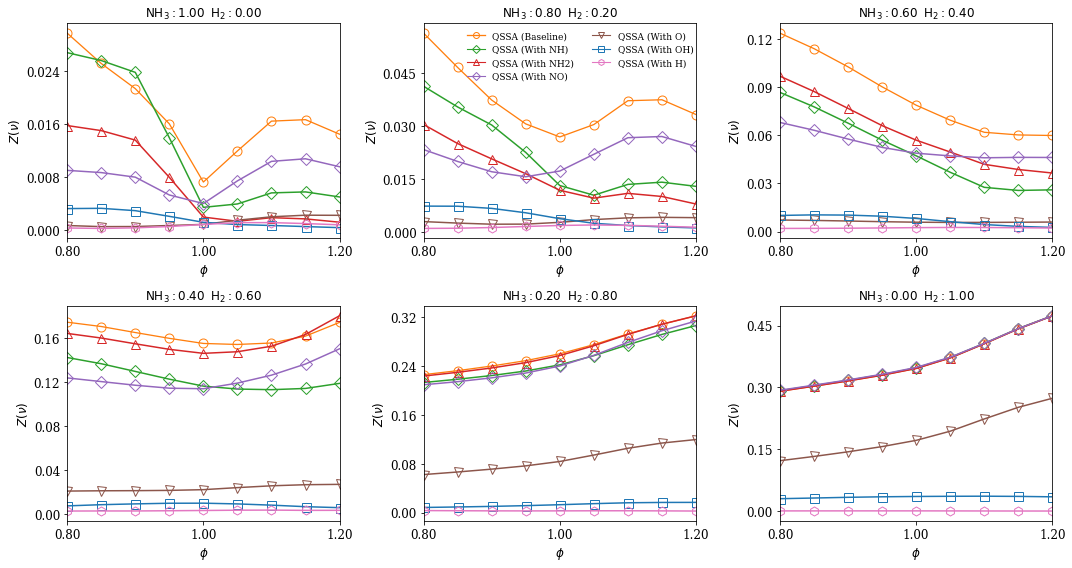

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FixedLocator, FormatStrFormatter
import matplotlib as mpl
from collections import OrderedDict
from itertools import cycle
from matplotlib.lines import Line2D

plt.rcParams["font.family"] = "serif"

# ── Settings ──────────────────────────────────────────────────────────────────
data_path    = "cases"
sim_case     = "NH3_premixed_matrix_1bar/Sim"
qssa_case    = "NH3_premixed_matrix_1bar/Sim_QSSA"
mech         = "Han_35s177r"

qssa_roots_with = OrderedDict({
    # "HO2": "NH3_premixed_matrix_1bar/Sim_QSSA_withHO2",
    # "HNO": "NH3_premixed_matrix_1bar/Sim_QSSA_withHNO",
    "NH":  "NH3_premixed_matrix_1bar/Sim_QSSA_withNH",
    "NH2": "NH3_premixed_matrix_1bar/Sim_QSSA_withNH2",
    "NO":  "NH3_premixed_matrix_1bar/Sim_QSSA_withNO",
    "O":   "NH3_premixed_matrix_1bar/Sim_QSSA_withO",
    "OH":  "NH3_premixed_matrix_1bar/Sim_QSSA_withOH",
    "H":   "NH3_premixed_matrix_1bar/Sim_QSSA_withH",
})

base_cases = [
    "NH3_1.00_0.00",
    "NH3_0.80_0.20",
    "NH3_0.60_0.40",
    "NH3_0.40_0.60",
    "NH3_0.20_0.80",
    "NH3_0.00_1.00",
]
pressure_fixed = "1.0"
phis = ["0.80","0.85","0.90","0.95","1.00","1.05","1.10","1.15","1.20"]
xticks_phi = [0.8, 1.0, 1.2]

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

# ── Paths & IO ────────────────────────────────────────────────────────────────
def path_sim(case): return os.path.join(data_path, sim_case, mech, case + ".csv")
def path_qssa_baseline(case): return os.path.join(data_path, qssa_case, mech, case, "predicted_X.csv")
def path_qssa_with(sp, case): return os.path.join(data_path, qssa_roots_with[sp], mech, case, "predicted_X.csv")

def safe_read_csv(p):
    try:
        return pd.read_csv(p, comment="#")
    except Exception:
        return None

# ── Integration-based error metrics ───────────────────────────────────────────
def _pick_x(df):
    """
    Pick the coordinate column and return sorted (x, order).
    Uses 'grid' as the primary coordinate, falling back to common alternatives.
    """
    for col in ["grid", "x", "X", "z", "Z", "pos", "position", "s"]:
        if col in df.columns:
            x = np.asarray(df[col], float)
            order = np.argsort(x)
            return x[order], order
    # fallback: use index as pseudo-uniform grid
    x = np.arange(len(df), dtype=float)
    return x, slice(None)

def _norm_arr(y):
    y = np.asarray(y, float)
    m = np.nanmax(y)
    return y/m if np.isfinite(m) and m > 0 else y

def l2_integral(a_df, b_df, col="HRR", normalize=True, interp_to="a"):
    """
    Compute ∫(a-b)^2 dx (trapz). Also returns:
      - L: domain length,
      - rel_L2: ∫(a-b)^2 / ∫a^2  (dimensionless),
      - mean_per_length: (1/L) ∫(a-b)^2.
    Interpolates one profile onto the other's x-grid to avoid shape mismatches.
    """
    if a_df is None or b_df is None or col not in a_df.columns or col not in b_df.columns:
        return np.nan, np.nan, np.nan, np.nan

    xa, ord_a = _pick_x(a_df); ya = np.asarray(a_df[col], float)[ord_a]
    xb, ord_b = _pick_x(b_df); yb = np.asarray(b_df[col], float)[ord_b]

    if normalize:
        ya = _norm_arr(ya)
        yb = _norm_arr(yb)

    if interp_to == "a":
        yb_on_a = np.interp(xa, xb, yb, left=np.nan, right=np.nan)
        mask = np.isfinite(ya) & np.isfinite(yb_on_a) & np.isfinite(xa)
        x = xa[mask]; da = ya[mask]; db = yb_on_a[mask]
    else:
        ya_on_b = np.interp(xb, xa, ya, left=np.nan, right=np.nan)
        mask = np.isfinite(ya_on_b) & np.isfinite(yb) & np.isfinite(xb)
        x = xb[mask]; da = ya_on_b[mask]; db = yb[mask]

    if x.size < 2:
        return np.nan, np.nan, np.nan, np.nan

    diff2 = (da - db)**2
    integral = np.trapz(diff2, x)
    L = float(x[-1] - x[0]) if x.size > 1 else np.nan
    mean_per_length = (integral / L) if (np.isfinite(L) and L != 0) else np.nan

    denom = np.trapz(da**2, x)
    rel_L2 = (integral / denom) if (np.isfinite(denom) and denom > 0) else np.nan
    return integral, L, rel_L2, mean_per_length

# ── Metric computation per case ───────────────────────────────────────────────
def compute_method_errors(sim_df, qssa_baseline_df, qssa_with_dfs):
    """
    Returns an OrderedDict mapping method -> error metric.
    Uses relative L2 error between HRR profiles as the plotted metric.
    Skips extinct cases with Tmax < 400 K if 'T' is present.
    """
    if sim_df is None or "HRR" not in sim_df.columns:
        return None

    Tmax = pd.to_numeric(sim_df.get("T", pd.Series([np.inf])), errors="coerce").max(skipna=True)
    if pd.notna(Tmax) and Tmax < 400:  # extinction guard
        return None

    out = OrderedDict()

    # Baseline
    if qssa_baseline_df is not None and "HRR" in qssa_baseline_df.columns:
        _, _, rel, _ = l2_integral(sim_df, qssa_baseline_df, col="HRR", normalize=True, interp_to="a")
    else:
        rel = np.nan
    out["QSSA (Baseline)"] = rel

    # Variants
    for sp, qdf in qssa_with_dfs.items():
        if qdf is not None and "HRR" in qdf.columns:
            _, _, rel, _ = l2_integral(sim_df, qdf, col="HRR", normalize=True, interp_to="a")
        else:
            rel = np.nan
        out[f"QSSA (With {sp})"] = rel

    return out

variant_labels = [f"QSSA (With {sp})" for sp in qssa_roots_with.keys()]
labels = ["QSSA (Baseline)"] + variant_labels

# ── Colors & Markers ─────────────────────────────────────────────────────────
tab10 = plt.get_cmap("tab10").colors

def build_method_colors():
    """
    Force:
      - QSSA (Baseline) -> tab10[1] (orange)
      - QSSA (With OH)  -> tab10[0] (blue)
      - other species   -> remaining tab10 colors [2..9] in a stable order
    """
    colors = {"QSSA (Baseline)": tab10[1]}
    remaining = [2, 3, 4, 5, 6, 7, 8, 9]
    for sp in qssa_roots_with:
        key = f"QSSA (With {sp})"
        if sp == "OH":
            colors[key] = tab10[0]
        else:
            idx = remaining.pop(0) if remaining else ((list(qssa_roots_with.keys()).index(sp)) % 10)
            colors[key] = tab10[idx]
    return colors

method_colors = build_method_colors()

species_marker_map = {
    "OH":"s","NH2":"^","O":"v","HNO":"P","HO2":"v","H":"h","N":"X","NH":"D","NO":"D"
}
marker_cycle = cycle(["o","s","^","v","D","P","X","*"])
def marker_for(label):
    if label == "QSSA (Baseline)":
        return "o"
    if label.startswith("QSSA (With "):
        sp = label[11:-1]
        return species_marker_map.get(sp, next(marker_cycle))
    return "o"

def linestyle_for(label):
    return "-"
    # return "-" if label == "QSSA (Baseline)" else "--"

# ── Plot 2×3 grid with internal legend ────────────────────────────────────────
def plot_error_grid_with_internal_legend(base_cases, out_path, pressure="1.0"):
    x = [float(phi) for phi in phis]
    n_rows, n_cols = 2, 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8), sharey=False)
    axes = axes.flatten()

    for i, base_case in enumerate(base_cases):
        ax = axes[i]
        curves = {name: [] for name in labels}

        for phi in phis:
            case = f"{base_case}_phi{phi}_p{pressure}"
            sim_df   = safe_read_csv(path_sim(case))
            qb_df    = safe_read_csv(path_qssa_baseline(case))
            qwith_df = {sp: safe_read_csv(path_qssa_with(sp, case)) for sp in qssa_roots_with}

            errs = compute_method_errors(sim_df, qb_df, qwith_df)
            if errs is None:
                for name in labels:
                    curves[name].append(np.nan)
                continue

            for name in labels:
                curves[name].append(errs.get(name, np.nan))

        # Plot
        for name in labels:
            ax.plot(
                x, curves[name],
                linestyle=linestyle_for(name),
                marker=marker_for(name),
                markersize=9,
                linewidth=1.3 if name == "QSSA (Baseline)" else 1.5,
                color=method_colors[name],
                markerfacecolor='none',
                markeredgecolor=method_colors[name],
                label=name
            )

        # Titles/axes
        try:
            _, nh3, h2 = base_case.split("_")
        except ValueError:
            nh3, h2 = "?", "?"
        ax.set_title(rf"$\mathrm{{NH_3}}:{nh3}\;\; \mathrm{{H_2}}:{h2}$", fontsize=12)
        ax.set_xlabel(r"$\phi$", fontsize=12)
        ax.set_ylabel(r"$Z(\nu)$", fontsize=12)
        ax.xaxis.set_major_locator(FixedLocator(xticks_phi))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.set_xlim(min(x), max(x))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

    # Legend inside second subplot (2 columns), nudged slightly outside
    handles = [
        Line2D([0], [0],
               linestyle=linestyle_for(name),
               marker=marker_for(name),
               color=method_colors[name],
               markerfacecolor='none',
               markeredgecolor=method_colors[name],
               linewidth=1.3 if name == "QSSA (Baseline)" else 1.1,
               markersize=6)
        for name in labels
    ]
    leg = axes[1].legend(
        handles, labels,
        loc="upper right",
        fontsize=9,
        frameon=False,
        ncol=2,
        bbox_to_anchor=(1.02, 1.0),
        bbox_transform=axes[1].transAxes
    )
    leg.set_in_layout(False)
    leg.set_zorder(10)

    plt.tight_layout()
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.savefig(out_path, dpi=300)
    print(f"Saved figure to: {out_path}")

# ── Run ───────────────────────────────────────────────────────────────────────
plot_error_grid_with_internal_legend(
    base_cases=base_cases,
    out_path="figs/validation/fig9_relL2_vs_phi_by_blend_at_1atm_with_species_markers_linestyles.pdf",
    pressure=pressure_fixed,
)

# Influence of Strain Rate?

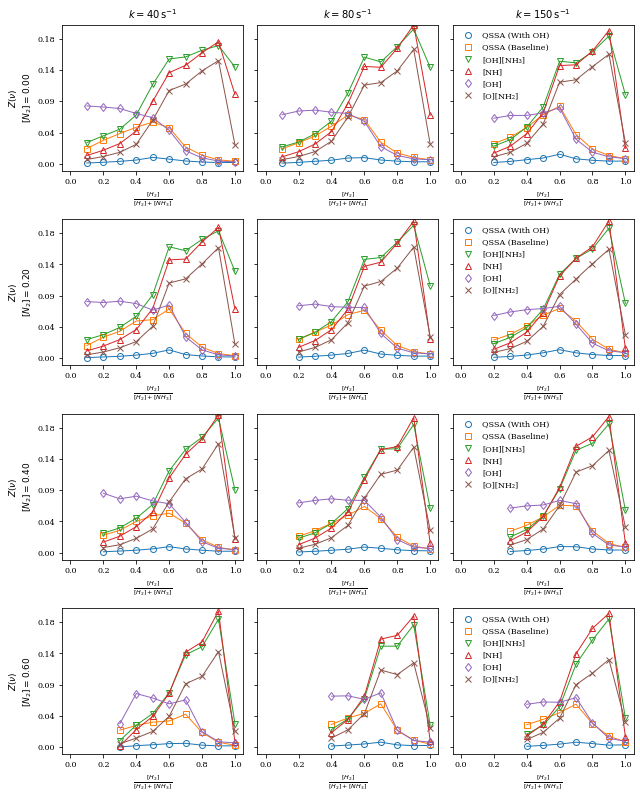

→ Saved NMSE‐blend figure at: figs/validation/fig10_Z_vs_H2blend_by_k_and_N2_Han_35s177r.pdf


In [16]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FormatStrFormatter

# ─── Configuration ────────────────────────────────────────────────────────────
root_base     = "cases/NH3_nonpremixed_matrix_1bar"
k_values      = [40, 80, 150]                 # now go on COLUMNS
mech          = "Han_35s177r"#"Otomo_32s213r"                    # mechanism subfolder present under each root
marker_stride = 1                                   # mark every N points (1 => all)

# Colors & styles
labels     = [
    "QSSA (With OH)",
    "QSSA (Baseline)",
    "[OH][NH₃]",
    "[NH]",
    "[OH]",
    "[O][NH₂]",
]
linestyles = ["-"] * len(labels)
markers    = ["o", "s", "v", "^", "d", "x"]
tab10 = plt.get_cmap("tab10").colors
method_colors = {
    "QSSA (With OH)":   tab10[0],
    "QSSA (Baseline)":  tab10[1],
    "[OH][NH₃]":        tab10[2],
    "[NH]":             tab10[3],
    "[OH]":             tab10[4],
    "[O][NH₂]":         tab10[5],
}

# ─── Helpers ──────────────────────────────────────────────────────────────────
def norm(arr):
    arr = np.asarray(arr, dtype=float)
    if arr.size == 0:
        return arr
    m = np.nanmax(arr)
    return arr / m if m and np.isfinite(m) and m > 0 else arr

def nmse(a, b):
    """Normalized MSE between two already-normalized vectors; returns np.nan if missing."""
    if a is None or b is None:
        return np.nan
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    if a.size == 0 or b.size == 0 or a.shape != b.shape:
        return np.nan
    return np.nanmean((a - b) ** 2)

def method_errors(sim_df, qssa_df, qssa_oh_df):
    """Compute all method NMSEs for one case (vectors normalized internally)."""
    if "HRR" not in sim_df.columns:
        return {k: np.nan for k in labels}
    sim_hrr = norm(sim_df["HRR"].to_numpy())

    Tmax = pd.to_numeric(sim_df.get("T", pd.Series([np.inf])), errors="coerce").max(skipna=True)
    if pd.notna(Tmax) and Tmax < 400:
        return {k: np.nan for k in labels}

    qssa_norm    = norm(qssa_df["HRR"].to_numpy())    if (qssa_df is not None and "HRR" in qssa_df.columns) else None
    qssa_oh_norm = norm(qssa_oh_df["HRR"].to_numpy()) if (qssa_oh_df is not None and "HRR" in qssa_oh_df.columns) else None

    def col(name):
        return sim_df[name].to_numpy() if name in sim_df.columns else None

    X_OH  = col("X_OH")
    X_NH3 = col("X_NH3")
    X_NH  = col("X_NH")
    X_O   = col("X_O")
    X_NH2 = col("X_NH2")

    oh_nh3 = norm(X_OH * X_NH3) if (X_OH is not None and X_NH3 is not None) else None
    nh     = norm(X_NH)         if (X_NH is not None) else None
    oh     = norm(X_OH)         if (X_OH is not None) else None
    o_nh2  = norm(X_O * X_NH2)  if (X_O  is not None and X_NH2 is not None) else None

    return {
        "QSSA (With OH)":  nmse(sim_hrr, qssa_oh_norm),
        "QSSA (Baseline)": nmse(sim_hrr, qssa_norm),
        "[OH][NH₃]":       nmse(sim_hrr, oh_nh3),
        "[NH]":            nmse(sim_hrr, nh),
        "[OH]":            nmse(sim_hrr, oh),
        "[O][NH₂]":        nmse(sim_hrr, o_nh2),
    }

def load_dataframe_for_k(k):
    """Read all cases for a given k and return (df, h2_vals, n2_vals)."""
    sim_root     = os.path.join(root_base, f"Sim_DD_k{k}")
    qssa_root    = os.path.join(root_base, f"Sim_DD_QSSA_k{k}")
    qssa_oh_root = os.path.join(root_base, f"Sim_DD_QSSA_k{k}_withOH")

    sim_dir     = os.path.join(sim_root, mech)
    qssa_dir    = os.path.join(qssa_root, mech)
    qssa_oh_dir = os.path.join(qssa_oh_root, mech)

    if not os.path.isdir(sim_dir):
        raise FileNotFoundError(f"[k={k}] SIM directory not found: {sim_dir}")
    if not os.path.isdir(qssa_dir):
        print(f"[k={k}] [warn] QSSA directory not found: {qssa_dir}")
    if not os.path.isdir(qssa_oh_dir):
        print(f"[k={k}] [warn] QSSA (with OH) directory not found: {qssa_oh_dir}")

    pat = re.compile(
        r"^N_CF_"
        r"NH3_(?P<nh3>[0-9.]+)_"
        r"H2_(?P<h2>[0-9.]+)_"
        r"N2_(?P<n2>[0-9.]+)\.csv$"
    )

    records = []
    for fn in os.listdir(sim_dir):
        m = pat.match(fn)
        if not m:
            continue
        nh3 = float(m.group("nh3"))
        h2  = float(m.group("h2"))
        n2  = float(m.group("n2"))
        total = nh3 + h2 + n2
        if total <= 0:
            continue
        denom = h2 + nh3
        if denom <= 0:
            continue
        h2b = h2 / denom
        n2b = n2

        case = fn[:-4]
        records.append({
            "case":    case,
            "sim":     os.path.join(sim_dir, fn),
            "h2b":     h2b,
            "n2b":     n2b,
            "qssa":    os.path.join(qssa_dir, case, "predicted_X.csv"),
            "qssa_oh": os.path.join(qssa_oh_dir, case, "predicted_X.csv"),
        })

    df = pd.DataFrame(records)
    if df.empty:
        raise RuntimeError(f"[k={k}] No matrix files matched in {sim_dir}.")
    h2_vals = sorted(set(np.round(df["h2b"].to_numpy(), 6)))
    n2_vals = sorted(set(np.round(df["n2b"].to_numpy(), 6)))
    return df, h2_vals, n2_vals

# ─── Load grids for all k and check compatibility ─────────────────────────────
dfs = {}
h2_grids = []
n2_grids = []
for k in k_values:
    df_k, h2_k, n2_k = load_dataframe_for_k(k)
    dfs[k] = (df_k, h2_k, n2_k)
    h2_grids.append(h2_k)
    n2_grids.append(n2_k)

# Check that all k have the same grids (warn if not)
h2_ref = h2_grids[0]
n2_ref = n2_grids[0]
for idx, (h2_k, n2_k) in enumerate(zip(h2_grids, n2_grids), start=1):
    if h2_k != h2_ref or n2_k != n2_ref:
        print(f"[warn] Blend grids differ across k values; some panels may be blank.")
h2_vals = h2_ref
n2_vals = n2_ref


# ─── Build a panel with ROWS = N2 blends, COLS = k values ─────────────────────
n_rows = len(n2_vals)          # ← N2 on vertical
n_cols = len(k_values)         # ← k on horizontal
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.0*n_cols, 2.8*n_rows), sharex=False, sharey=True)
if n_rows == 1:
    axes = np.array([axes])
if n_cols == 1:
    axes = axes.reshape(n_rows, 1)

for r, n2b in enumerate(n2_vals):
    for c, k in enumerate(k_values):
        ax = axes[r, c]
        df, h2_vals_k, n2_vals_k = dfs[k]

        # Pre-compute NMSE per method vs H2-blend for this (N2 blend, k)
        curves = {label: [] for label in labels}
        for h2b in h2_vals:
            sub = df[np.isclose(df["h2b"], h2b) & np.isclose(df["n2b"], n2b)]
            if sub.empty:
                for klabel in curves: curves[klabel].append(np.nan)
                continue

            row = sub.iloc[0]
            sim_path     = row["sim"]
            qssa_path    = row["qssa"]
            qssa_oh_path = row["qssa_oh"]

            sim_df     = pd.read_csv(sim_path, comment="#")
            qssa_df    = pd.read_csv(qssa_path, comment="#")    if os.path.isfile(qssa_path)    else None
            qssa_oh_df = pd.read_csv(qssa_oh_path, comment="#") if os.path.isfile(qssa_oh_path) else None

            errs = method_errors(sim_df, qssa_df, qssa_oh_df)
            for klabel in curves:
                curves[klabel].append(errs[klabel])

        # Plot each method
        x = np.array(h2_vals, dtype=float)
        for label, ls, mk in zip(labels, linestyles, markers):
            y = np.array(curves[label], dtype=float)
            col = method_colors[label]
            ax.plot(x, y, linestyle=ls, color=col, linewidth=1.0)
            # thinned markers
            if marker_stride and marker_stride > 1:
                mi = np.arange(0, len(x), int(marker_stride))
            else:
                mi = np.arange(len(x))
            ax.plot(x[mi], y[mi], linestyle="none", marker=mk, markersize=6,
                    markerfacecolor='none', markeredgecolor=col, color=col,
                    label=label)

        # Column titles = k values
        if r == 0:
            ax.set_title(rf"$k = {k}\,\mathrm{{s^{{-1}}}}$", fontsize=10)

        if c == 0:
            ax.set_ylabel(
                r"$Z(\nu)$""\n" + rf"$[N_2] = {n2b:.2f}$",
                fontsize=9
            )
        # Axes formatting
        ax.set_xlabel(r"$\frac{[H_2]}{[H_2]+[NH_3]}$", fontsize=9)
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.01, 0.20)
        ax.xaxis.set_major_locator(FixedLocator(np.linspace(0, 1, 6)))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.set_yticks(np.linspace(0, 0.18, 5))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.tick_params(axis='both', which='major', labelsize=8)

        # Legend only on the last column of each row (rightmost panel)
        if c == n_cols - 1:
            ax.legend(loc="upper left", frameon=False, fontsize=8)

plt.tight_layout()
out_dir = "figs/validation"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, f"fig10_Z_vs_H2blend_by_k_and_N2_{mech}.pdf")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"→ Saved NMSE‐blend figure at: {out_path}")

# Table for Non-Premixed Flames


Summary table for k=40 s^-1 (nmse_max over H2-blend):
                QSSA (with OH)  QSSA (baseline)  \
$[N_2] = 0.00$           0.009            0.060   
$[N_2] = 0.20$           0.012            0.071   
$[N_2] = 0.40$           0.009            0.057   
$[N_2] = 0.60$           0.006            0.047   

                $[\mathrm{OH}][\mathrm{NH_3}]$  $[\mathrm{NH}]$  \
$[N_2] = 0.00$                           0.170            0.176   
$[N_2] = 0.20$                           0.183            0.188   
$[N_2] = 0.40$                           0.194            0.198   
$[N_2] = 0.60$                           0.184            0.196   

                $[\mathrm{OH}]$  $[\mathrm{O}][\mathrm{NH_2}]$  
$[N_2] = 0.00$            0.083                          0.148  
$[N_2] = 0.20$            0.082                          0.159  
$[N_2] = 0.40$            0.086                          0.157  
$[N_2] = 0.60$            0.077                          0.138  
→ wrote LaTeX table to: figs

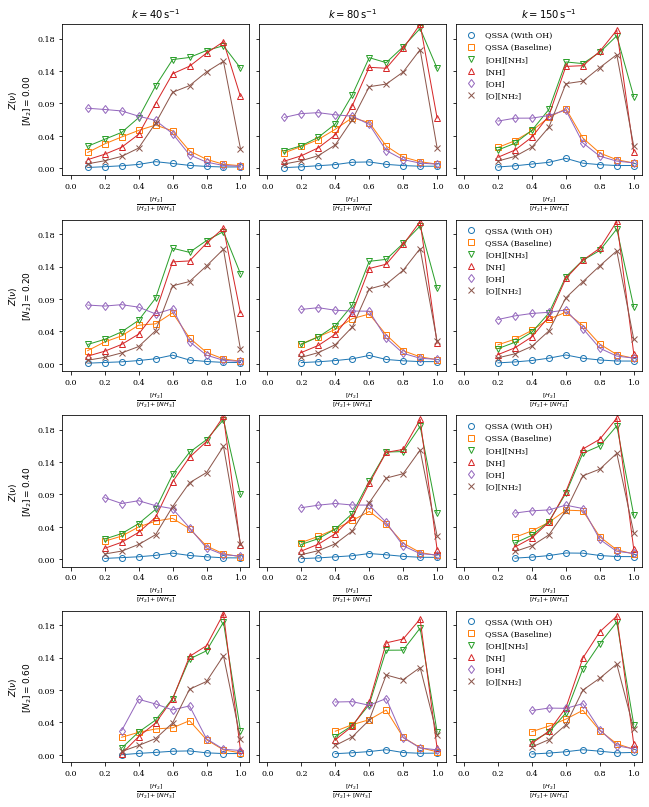

→ Saved NMSE‐blend figure at: figs/validation/fig10_Z_vs_H2blend_by_k_and_N2_Han_35s177r.pdf


In [61]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FormatStrFormatter

# ─── Configuration ────────────────────────────────────────────────────────────
root_base     = "cases/NH3_nonpremixed_matrix_1bar"
k_values      = [40, 80, 150]                 # now go on COLUMNS
mech          = "Han_35s177r"                 # mechanism subfolder present under each root
marker_stride = 1                             # mark every N points (1 => all)

# Colors & styles
labels     = [
    "QSSA (With OH)",
    "QSSA (Baseline)",
    "[OH][NH₃]",
    "[NH]",
    "[OH]",
    "[O][NH₂]",
]
linestyles = ["-"] * len(labels)
markers    = ["o", "s", "v", "^", "d", "x"]
tab10 = plt.get_cmap("tab10").colors
method_colors = {
    "QSSA (With OH)":   tab10[0],
    "QSSA (Baseline)":  tab10[1],
    "[OH][NH₃]":        tab10[2],
    "[NH]":             tab10[3],
    "[OH]":             tab10[4],
    "[O][NH₂]":         tab10[5],
}

# ─── Helpers ──────────────────────────────────────────────────────────────────
def norm(arr):
    arr = np.asarray(arr, dtype=float)
    if arr.size == 0:
        return arr
    m = np.nanmax(arr)
    return arr / m if m and np.isfinite(m) and m > 0 else arr

def nmse(a, b):
    """Normalized MSE between two already-normalized vectors; returns np.nan if missing."""
    if a is None or b is None:
        return np.nan
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    if a.size == 0 or b.size == 0 or a.shape != b.shape:
        return np.nan
    return np.nanmean((a - b) ** 2)

def method_errors(sim_df, qssa_df, qssa_oh_df):
    """Compute all method NMSEs for one case (vectors normalized internally)."""
    if "HRR" not in sim_df.columns:
        return {k: np.nan for k in labels}
    sim_hrr = norm(sim_df["HRR"].to_numpy())

    Tmax = pd.to_numeric(sim_df.get("T", pd.Series([np.inf])), errors="coerce").max(skipna=True)
    if pd.notna(Tmax) and Tmax < 400:
        return {k: np.nan for k in labels}

    qssa_norm    = norm(qssa_df["HRR"].to_numpy())    if (qssa_df is not None and "HRR" in qssa_df.columns) else None
    qssa_oh_norm = norm(qssa_oh_df["HRR"].to_numpy()) if (qssa_oh_df is not None and "HRR" in qssa_oh_df.columns) else None

    def col(name):
        return sim_df[name].to_numpy() if name in sim_df.columns else None

    X_OH  = col("X_OH")
    X_NH3 = col("X_NH3")
    X_NH  = col("X_NH")
    X_O   = col("X_O")
    X_NH2 = col("X_NH2")

    oh_nh3 = norm(X_OH * X_NH3) if (X_OH is not None and X_NH3 is not None) else None
    nh     = norm(X_NH)         if (X_NH is not None) else None
    oh     = norm(X_OH)         if (X_OH is not None) else None
    o_nh2  = norm(X_O * X_NH2)  if (X_O  is not None and X_NH2 is not None) else None

    return {
        "QSSA (With OH)":  nmse(sim_hrr, qssa_oh_norm),
        "QSSA (Baseline)": nmse(sim_hrr, qssa_norm),
        "[OH][NH₃]":       nmse(sim_hrr, oh_nh3),
        "[NH]":            nmse(sim_hrr, nh),
        "[OH]":            nmse(sim_hrr, oh),
        "[O][NH₂]":        nmse(sim_hrr, o_nh2),
    }

def load_dataframe_for_k(k):
    """Read all cases for a given k and return (df, h2_vals, n2_vals)."""
    sim_root     = os.path.join(root_base, f"Sim_DD_k{k}")
    qssa_root    = os.path.join(root_base, f"Sim_DD_QSSA_k{k}")
    qssa_oh_root = os.path.join(root_base, f"Sim_DD_QSSA_k{k}_withOH")

    sim_dir     = os.path.join(sim_root, mech)
    qssa_dir    = os.path.join(qssa_root, mech)
    qssa_oh_dir = os.path.join(qssa_oh_root, mech)

    if not os.path.isdir(sim_dir):
        raise FileNotFoundError(f"[k={k}] SIM directory not found: {sim_dir}")
    if not os.path.isdir(qssa_dir):
        print(f"[k={k}] [warn] QSSA directory not found: {qssa_dir}")
    if not os.path.isdir(qssa_oh_dir):
        print(f"[k={k}] [warn] QSSA (with OH) directory not found: {qssa_oh_dir}")

    pat = re.compile(
        r"^N_CF_"
        r"NH3_(?P<nh3>[0-9.]+)_"
        r"H2_(?P<h2>[0-9.]+)_"
        r"N2_(?P<n2>[0-9.]+)\.csv$"
    )

    records = []
    for fn in os.listdir(sim_dir):
        m = pat.match(fn)
        if not m:
            continue
        nh3 = float(m.group("nh3"))
        h2  = float(m.group("h2"))
        n2  = float(m.group("n2"))
        total = nh3 + h2 + n2
        if total <= 0:
            continue
        denom = h2 + nh3
        if denom <= 0:
            continue
        h2b = h2 / denom
        n2b = n2

        case = fn[:-4]
        records.append({
            "case":    case,
            "sim":     os.path.join(sim_dir, fn),
            "h2b":     h2b,
            "n2b":     n2b,
            "qssa":    os.path.join(qssa_dir, case, "predicted_X.csv"),
            "qssa_oh": os.path.join(qssa_oh_dir, case, "predicted_X.csv"),
        })

    df = pd.DataFrame(records)
    if df.empty:
        raise RuntimeError(f"[k={k}] No matrix files matched in {sim_dir}.")
    h2_vals = sorted(set(np.round(df["h2b"].to_numpy(), 6)))
    n2_vals = sorted(set(np.round(df["n2b"].to_numpy(), 6)))
    return df, h2_vals, n2_vals

# ─── Load grids for all k and check compatibility ─────────────────────────────
dfs = {}
h2_grids = []
n2_grids = []
for k in k_values:
    df_k, h2_k, n2_k = load_dataframe_for_k(k)
    dfs[k] = (df_k, h2_k, n2_k)
    h2_grids.append(h2_k)
    n2_grids.append(n2_k)

# Check that all k have the same grids (warn if not)
h2_ref = h2_grids[0]
n2_ref = n2_grids[0]
for idx, (h2_k, n2_k) in enumerate(zip(h2_grids, n2_grids), start=1):
    if h2_k != h2_ref or n2_k != n2_ref:
        print(f"[warn] Blend grids differ across k values; some panels may be blank.")
h2_vals = h2_ref
n2_vals = n2_ref

# ─── TABLES: per-N2 summary for each k value ─────────────────────────────────
TABLE_MODE = "nmse_max"  # or "Zmax" for Z(ν)=1−min(NMSE)

def _n2_label(n2b):
    return rf"$[N_2] = {n2b:.2f}$"

def build_summary_table_for_k(k, metric_mode="nmse_max"):
    """
    Build a table for one k:
      rows  = N2 blends (n2b)
      cols  = methods in `labels`
      cells = max(NMSE over h2b) if 'nmse_max'
              1 - min(NMSE over h2b) if 'Zmax'
    """
    df_k, h2_k, n2_k = dfs[k]

    rows = []
    index_labels = []
    for n2b in n2_k:
        # collect series of NMSE(h2b) for each label
        collector = {lab: [] for lab in labels}
        for h2b in h2_k:
            sub = df_k[np.isclose(df_k["h2b"], h2b) & np.isclose(df_k["n2b"], n2b)]
            if sub.empty:
                for lab in labels:
                    collector[lab].append(np.nan)
                continue

            row = sub.iloc[0]
            sim_df     = pd.read_csv(row["sim"], comment="#")
            qssa_df    = pd.read_csv(row["qssa"], comment="#")    if os.path.isfile(row["qssa"])    else None
            qssa_oh_df = pd.read_csv(row["qssa_oh"], comment="#") if os.path.isfile(row["qssa_oh"]) else None

            errs = method_errors(sim_df, qssa_df, qssa_oh_df)
            for lab in labels:
                collector[lab].append(errs[lab])

        # reduce over h2b according to metric_mode
        row_vals = {}
        for lab in labels:
            arr = np.asarray(collector[lab], dtype=float)
            if arr.size == 0 or np.all(np.isnan(arr)):
                row_vals[lab] = np.nan
            else:
                if metric_mode == "nmse_max":
                    row_vals[lab] = np.nanmax(arr)
                elif metric_mode == "Zmax":
                    row_vals[lab] = 1.0 - np.nanmin(arr)
                else:
                    raise ValueError("metric_mode must be 'nmse_max' or 'Zmax'")
        rows.append(row_vals)
        index_labels.append(_n2_label(n2b))

    df_tbl = pd.DataFrame(rows, index=index_labels, columns=labels)

    # Column display names for LaTeX
    df_tbl = df_tbl.rename(columns={
        "QSSA (With OH)" : r"QSSA (with OH)",
        "QSSA (Baseline)": r"QSSA (baseline)",
        "[OH][NH₃]"      : r"$[\mathrm{OH}][\mathrm{NH_3}]$",
        "[NH]"           : r"$[\mathrm{NH}]$",
        "[OH]"           : r"$[\mathrm{OH}]$",
        "[O][NH₂]"       : r"$[\mathrm{O}][\mathrm{NH_2}]$",
    })
    return df_tbl

# Build & save tables for each k
os.makedirs("figs/tables", exist_ok=True)
for k in k_values:
    df_summary_k = build_summary_table_for_k(k, metric_mode=TABLE_MODE)
    print(f"\nSummary table for k={k} s^-1 ({TABLE_MODE} over H2-blend):")
    print(df_summary_k.round(3))

    latex_path = f"figs/tables/nonpremixed_k{k}_{TABLE_MODE}_table.tex"
    with open(latex_path, "w", encoding="utf-8") as f:
        f.write(df_summary_k.to_latex(
            na_rep="--",
            float_format=lambda x: f"{x:.3f}",
            escape=False,
            column_format="l" + "c"*df_summary_k.shape[1]
        ))
    print(f"→ wrote LaTeX table to: {latex_path}")

# ─── Build a panel with ROWS = N2 blends, COLS = k values (plot) ─────────────
n_rows = len(n2_vals)          # ← N2 on vertical
n_cols = len(k_values)         # ← k on horizontal
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.0*n_cols, 2.8*n_rows), sharex=False, sharey=True)
if n_rows == 1:
    axes = np.array([axes])
if n_cols == 1:
    axes = axes.reshape(n_rows, 1)

for r, n2b in enumerate(n2_vals):
    for c, k in enumerate(k_values):
        ax = axes[r, c]
        df, h2_vals_k, n2_vals_k = dfs[k]

        # Pre-compute NMSE per method vs H2-blend for this (N2 blend, k)
        curves = {label: [] for label in labels}
        for h2b in h2_vals:
            sub = df[np.isclose(df["h2b"], h2b) & np.isclose(df["n2b"], n2b)]
            if sub.empty:
                for klabel in curves: curves[klabel].append(np.nan)
                continue

            row = sub.iloc[0]
            sim_path     = row["sim"]
            qssa_path    = row["qssa"]
            qssa_oh_path = row["qssa_oh"]

            sim_df     = pd.read_csv(sim_path, comment="#")
            qssa_df    = pd.read_csv(qssa_path, comment="#")    if os.path.isfile(qssa_path)    else None
            qssa_oh_df = pd.read_csv(qssa_oh_path, comment="#") if os.path.isfile(qssa_oh_path) else None

            errs = method_errors(sim_df, qssa_df, qssa_oh_df)
            for klabel in curves:
                curves[klabel].append(errs[klabel])

        # Plot each method
        x = np.array(h2_vals, dtype=float)
        for label, ls, mk in zip(labels, linestyles, markers):
            y = np.array(curves[label], dtype=float)
            col = method_colors[label]
            ax.plot(x, y, linestyle=ls, color=col, linewidth=1.0)
            # thinned markers
            if marker_stride and marker_stride > 1:
                mi = np.arange(0, len(x), int(marker_stride))
            else:
                mi = np.arange(len(x))
            ax.plot(x[mi], y[mi], linestyle="none", marker=mk, markersize=6,
                    markerfacecolor='none', markeredgecolor=col, color=col,
                    label=label)

        # Column titles = k values
        if r == 0:
            ax.set_title(rf"$k = {k}\,\mathrm{{s^{{-1}}}}$", fontsize=10)

        if c == 0:
            ax.set_ylabel(
                r"$Z(\nu)$""\n" + rf"$[N_2] = {n2b:.2f}$",
                fontsize=9
            )
        # Axes formatting
        ax.set_xlabel(r"$\frac{[H_2]}{[H_2]+[NH_3]}$", fontsize=9)
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.01, 0.20)
        ax.xaxis.set_major_locator(FixedLocator(np.linspace(0, 1, 6)))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.set_yticks(np.linspace(0, 0.18, 5))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.tick_params(axis='both', which='major', labelsize=8)

        # Legend only on the last column of each row (rightmost panel)
        if c == n_cols - 1:
            ax.legend(loc="upper left", frameon=False, fontsize=8)

plt.tight_layout()
out_dir = "figs/validation"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, f"fig10_Z_vs_H2blend_by_k_and_N2_{mech}.pdf")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"→ Saved NMSE‐blend figure at: {out_path}")

# Figure 11 Adding species for Non-premixed flames

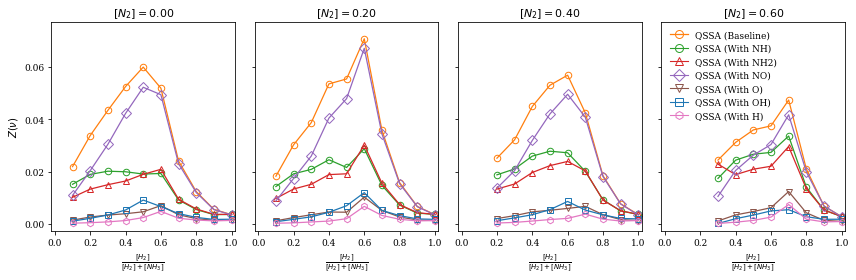

→ Saved NMSE‐blend figure at: figs/validation/fig11_Z_vs_H2blend_by_N2blend_Han_35s177r.pdf


In [17]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FormatStrFormatter, MaxNLocator
from collections import OrderedDict
from itertools import cycle
from matplotlib.lines import Line2D

# ─── Settings ─────────────────────────────────────────────────────────────────
sim_root  = "cases/NH3_nonpremixed_matrix_1bar/Sim_DD_k40"
qssa_root = "cases/NH3_nonpremixed_matrix_1bar/Sim_DD_QSSA_k40"
qssa_roots_with = {
    # "HO2": "cases/NH3_nonpremixed_matrix_1bar/Sim_DD_QSSA_k40_withHO2",
    # "HNO": "cases/NH3_nonpremixed_matrix_1bar/Sim_DD_QSSA_k40_withHNO",
    "NH":  "cases/NH3_nonpremixed_matrix_1bar/Sim_DD_QSSA_k40_withNH",
    "NH2": "cases/NH3_nonpremixed_matrix_1bar/Sim_DD_QSSA_k40_withNH2",
    "NO":  "cases/NH3_nonpremixed_matrix_1bar/Sim_DD_QSSA_k40_withNO",
    "O":   "cases/NH3_nonpremixed_matrix_1bar/Sim_DD_QSSA_k40_withO",
    "OH":  "cases/NH3_nonpremixed_matrix_1bar/Sim_DD_QSSA_k40_withOH",
    "H":   "cases/NH3_nonpremixed_matrix_1bar/Sim_DD_QSSA_k40_withH",
}
mech = "Han_35s177r"

marker_stride = 1   # show markers on every point (set >1 to thin markers)

# Order controls plot & legend order — follow dict insertion order automatically
species_order = list(qssa_roots_with.keys())

# ─── Paths ────────────────────────────────────────────────────────────────────
sim_dir   = os.path.join(sim_root, mech)
qssa_dir  = os.path.join(qssa_root, mech)
with_dirs = {sp: os.path.join(root, mech) for sp, root in qssa_roots_with.items()}

# ─── Read files & blend ratios ────────────────────────────────────────────────
pat = re.compile(r"^N_CF_NH3_(?P<nh3>[0-9.]+)_H2_(?P<h2>[0-9.]+)_N2_(?P<n2>[0-9.]+)\.csv$")
records = []
for fn in os.listdir(sim_dir):
    m = pat.match(fn)
    if not m:
        continue
    nh3 = float(m.group("nh3"))
    h2  = float(m.group("h2"))
    n2  = float(m.group("n2"))
    if nh3 + h2 + n2 <= 0:
        continue
    denom = h2 + nh3
    if denom <= 0:
        continue
    h2b = h2 / denom          # x-axis: H2 / (H2 + NH3)
    n2b = n2                  # panel grouping by N2 fraction (as provided)
    case = fn[:-4]
    rec = {
        "case": case,
        "sim": os.path.join(sim_dir, fn),
        "h2b": h2b,
        "n2b": n2b,
        "qssa_baseline": os.path.join(qssa_dir, case, "predicted_X.csv"),
    }
    for sp, d in with_dirs.items():
        rec[f"qssa_with_{sp}"] = os.path.join(d, case, "predicted_X.csv")
    records.append(rec)

df = pd.DataFrame(records)
h2_vals = sorted(set(np.round(df["h2b"], 6)))
n2_vals = sorted(set(np.round(df["n2b"], 6)))

# ─── Helpers ──────────────────────────────────────────────────────────────────
def norm(a):
    a = np.asarray(a, float)
    if a.size == 0:
        return a
    m = np.nanmax(a)
    return a / m if m and np.isfinite(m) and m > 0 else a

def nmse(a, b):
    if a is None or b is None:
        return np.nan
    a = np.asarray(a, float); b = np.asarray(b, float)
    if a.size == 0 or b.size == 0 or a.shape != b.shape:
        return np.nan
    return np.nanmean((a - b) ** 2)

def safe_read_csv(p):
    try:
        return pd.read_csv(p, comment="#")
    except Exception:
        return None

def compute_scores(sim_df, qssa_base_df, qssa_with_dfs):
    if sim_df is None or "HRR" not in sim_df.columns:
        return None
    # extinction guard
    Tmax = pd.to_numeric(sim_df.get("T", pd.Series([np.inf])), errors="coerce").max(skipna=True)
    if pd.notna(Tmax) and Tmax < 400:
        return None

    sim_hrr = norm(sim_df["HRR"].to_numpy())
    scores = OrderedDict()

    qnorm_base = norm(qssa_base_df["HRR"].to_numpy()) if (qssa_base_df is not None and "HRR" in qssa_base_df.columns) else None
    scores["QSSA (Baseline)"] = nmse(sim_hrr, qnorm_base)

    for sp in species_order:
        qdf = qssa_with_dfs.get(sp)
        qnorm = norm(qdf["HRR"].to_numpy()) if (qdf is not None and "HRR" in qdf.columns) else None
        scores[f"QSSA (With {sp})"] = nmse(sim_hrr, qnorm)

    return scores

# ─── Style (baseline = tab10[1] orange, With OH = tab10[0] blue) ─────────────
tab10 = plt.get_cmap("tab10").colors

def build_colors():
    colors = {"QSSA (Baseline)": tab10[1]}  # orange
    # assign OH explicitly to tab10[0] (blue), others get remaining [2..9] in order
    remaining = [2, 3, 4, 5, 6, 7, 8, 9]
    for sp in species_order:
        label = f"QSSA (With {sp})"
        if sp == "OH":
            colors[label] = tab10[0]  # blue
        else:
            idx = remaining.pop(0) if remaining else (species_order.index(sp) % 10)
            colors[label] = tab10[idx]
    return colors

method_colors = build_colors()

# Give every species a fixed marker (no fallback cycle)
species_marker_map = {
    "OH":  "s",
    "HNO": "P",
    "NH2": "^",
    "NO":  "D",
    "O":   "v",
    "H":   "h",
    "HO2": "X",
    "NH":  "o",
}

def marker_for(label):
    if label == "QSSA (Baseline)":
        return "o"
    if label.startswith("QSSA (With "):
        sp = label[len("QSSA (With "):-1]
        return species_marker_map.get(sp, "o")  # stable default
    return "o"

def linestyle_for(label):
    # keep both solid; change here if you want variants dashed:
    # return "-" if label == "QSSA (Baseline)" else "--"
    return "-"

# ─── Plot ─────────────────────────────────────────────────────────────────────
plot_labels = ["QSSA (Baseline)"] + [f"QSSA (With {sp})" for sp in species_order]

fig, axes = plt.subplots(
    1, len(n2_vals),
    figsize=(3 * len(n2_vals), 4),
    sharey=True
)
if len(n2_vals) == 1:
    axes = [axes]

for col_idx, (ax, n2b) in enumerate(zip(axes, n2_vals)):
    curves = {lbl: [] for lbl in plot_labels}
    for h2b in h2_vals:
        sub = df[np.isclose(df["h2b"], h2b) & np.isclose(df["n2b"], n2b)]
        if sub.empty:
            for k in curves: curves[k].append(np.nan)
            continue
        row = sub.iloc[0]

        sim_df     = safe_read_csv(row["sim"])
        qssa_b_df  = safe_read_csv(row["qssa_baseline"])
        qssa_w_dfs = {sp: safe_read_csv(row[f"qssa_with_{sp}"]) for sp in species_order}

        scores = compute_scores(sim_df, qssa_b_df, qssa_w_dfs)
        if scores is None:
            for k in curves: curves[k].append(np.nan)
            continue
        for lbl in plot_labels:
            curves[lbl].append(scores[lbl])

    x = np.array(h2_vals, float)

    # draw lines + markers
    for label in plot_labels:
        y = np.array(curves[label], float)
        col = method_colors[label]
        ax.plot(x, y, linestyle=linestyle_for(label), color=col, linewidth=1.25)
        mi = np.arange(0, len(x), marker_stride)
        ax.plot(
            x[mi], y[mi],
            linestyle="none",
            marker=marker_for(label),
            markersize=6.5,
            markerfacecolor="none",
            markeredgecolor=col,
            color=col,
            label=label
        )

    # Panel styling
    ax.set_title(rf"$[N_2] = {n2b:.2f}$", fontsize=11)
    ax.set_xlabel(r"$\frac{[H_2]}{[H_2]+[NH_3]}$", fontsize=10)
    ax.xaxis.set_major_locator(FixedLocator(np.linspace(0, 1, 6)))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_xlim(-0.02, 1.02)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.tick_params(axis='both', which='major', labelsize=9)

    # Add a bit of headroom so the legend/markers don't crowd
    ymin, ymax = ax.get_ylim()
    if np.isfinite(ymin) and np.isfinite(ymax) and ymax > ymin:
        pad = (ymax - ymin) * 0.05
        ax.set_ylim(ymin, ymax + pad)

    # (optional) put a legend somewhere specific
    if col_idx == 3:
        handles = [
            Line2D([0], [0],
                   linestyle=linestyle_for(name),
                   marker=marker_for(name),
                   color=method_colors[name],
                   markerfacecolor='none',
                   markeredgecolor=method_colors[name],
                   linewidth=1.25 if name == "QSSA (Baseline)" else 1.1,
                   markersize=8)
            for name in plot_labels
        ]
        ax.legend(
            handles, plot_labels,
            loc="upper left", ncol=1,
            frameon=False, fontsize=9
        )

axes[0].set_ylabel(r"$Z(\nu)$", fontsize=10)

plt.tight_layout()
out_dir = "figs/validation"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, f"fig11_Z_vs_H2blend_by_N2blend_{mech}.pdf")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"→ Saved NMSE‐blend figure at: {out_path}")

# Influence of Noise?  Guassian process?

figure saved → figs/NH3_NP_CF/fig10_Non_Premixed_Sim_EXP_QSSA.png


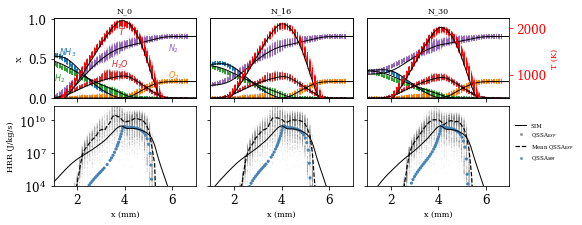

In [22]:
import re
from pathlib import Path
from typing import Sequence, Optional, Union, List, Dict, Tuple

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

def _as_list(x, length):
    """Ensure that x is a list of given length."""
    if isinstance(x, (list, tuple)):
        if len(x) == length:
            return list(x)
        elif len(x) == 1:
            return list(x) * length
        else:
            raise ValueError(f"Length mismatch: expected {length}, got {len(x)}")
    else:
        return [x] * length


def plot_counterflow_noise_full(
    mechanism:  str,
    exp_case_dir: str,
    exp_recon_dir: str,
    sim_case_dir: str,
    sim_recon_dir: str,
    fig_dir: str,
    target_cases: Sequence[str],
    #
    exp_shift: Union[float, Sequence[float]] = 0.0,
    sim_shift: Union[float, Sequence[float]] = 0.0,
    # figure sizing
    figsize: Optional[Tuple[float, float]] = None,
    fig_width: float = 8.73,
    row_height: float = 1.5,
    #
    top_species: Sequence[str] = ("X_NH3", "X_O2", "X_H2", "X_H2O", "X_N2"),
    data_species: Sequence[str] = ("X_OH", "X_O", "X_H", "X_NH2", "X_NO", "HRR"),
    #
    x_ranges: Optional[Sequence[Sequence[float]]] = None,
    t_range: Sequence[float] = (500, 2200),
    pdf_name: str = "1D_compact.pdf",
    #
    exp_color: str = "red",
    recon_color: str = "steelblue",
    sim_color: str = "black",
    #
    linewidth: float = 1.0,
    marker_size: float = 4,            # (deprecated) kept for compatibility
    font_size: int = 8,
    legend_font_size: int = 8,
    #
    exp_marker: str = "o",
    qssa_marker: str = "o",
    species_axis: Optional[Dict[str, Dict[str, Union[str, Sequence[float]]]]] = None,
    top_adjust: float = 0.85,
    # Top-row labels instead of legend
    show_top_species_text: bool = True,
    top_species_text_pos: Optional[Dict[str, Tuple[float, float]]] = None,
    top_text_axes_coords: bool = True,
    top_species_text_kwargs: Optional[Dict] = None,
    # tab colors for top EXP markers & labels
    top_species_colors: Optional[Sequence[str]] = None,
    # “T” text on first subplot
    show_top_T_text: bool = True,
    top_T_text_pos: Tuple[float, float] = (0.93, 0.88),
    top_T_text_kwargs: Optional[Dict] = None,
    # legend on 2nd row, built from that subplot but drawn OUTSIDE the figure
    outside_legend: bool = True,
    legend_rows: int = 3,
    legend_loc: str = "center left",
    legend_bbox: Tuple[float, float] = (1.02, 0.5),
    legend_frameon: bool = False,
    right_adjust: float = 0.78,
    marker_alpha: float = 0.5,
    # QSSA_EXP markers
    qssa_exp_color: str = "gray",
    qssa_exp_alpha: Optional[float] = None,      # if None → min(0.15, marker_alpha)
    # separate marker sizes
    top_marker_size: float = 3.0,
    qssa_exp_marker_size: float = 2.0,
    qssa_sim_marker_size: float = 6.0,
    # EXP-QSSA mean(x) line only (no band)
    show_exp_mean: bool = True,
    exp_mean_color: str = "black",
    exp_mean_linestyle: str = "--",               # dotted mean line
    exp_mean_linewidth: float = 1.2,
    # Toggle SIM-QSSA markers
    show_qssa_sim: bool = True,
    # Robust grouping of EXP-QSSA by x before averaging
    exp_group_mode: str = "round",     # "round" or "bin"
    exp_round_decimals: int = 3,       # used when exp_group_mode="round"
    exp_bin_width: float = 0.01,       # mm, used when exp_group_mode="bin"
) -> None:
    import matplotlib.pyplot as plt
    from pathlib import Path
    import pandas as pd

    def _nice_label(sp: str) -> str:
        return sp.split('_', 1)[1] if sp.startswith('X_') else sp

    def _latex_label(raw: str) -> str:
        def repl(m):
            letter = m.group(1)
            digits = m.group(2)
            return f"{letter}_{{{digits}}}" if len(digits) > 1 else f"{letter}_{digits}"
        s = re.sub(r'([A-Za-z])(\d+)', repl, raw)
        return f"${s}$"

    if species_axis is None:
        species_axis = {"HRR": {"yscale": "log", "ylim": (1e6, 1e11)}}

    default_tab_colors = [
        "tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple",
        "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"
    ]
    if top_species_colors is None:
        top_species_colors = [default_tab_colors[i % len(default_tab_colors)] for i in range(len(top_species))]
    else:
        if len(top_species_colors) < len(top_species):
            raise ValueError("top_species_colors length must be >= len(top_species)")

    top_label_colors: Dict[str, str] = {}
    for i, sp in enumerate(top_species):
        lab_plain = _nice_label(sp)
        top_label_colors[lab_plain] = top_species_colors[i]

    if top_species_text_pos is None:
        labels = [_nice_label(sp) for sp in top_species]
        y0, dy = 0.92, 0.10
        top_species_text_pos = {lab: (0.05, y0 - i * dy) for i, lab in enumerate(labels)}
    if top_species_text_kwargs is None:
        top_species_text_kwargs = {"fontsize": font_size + 1, "weight": "bold"}

    if top_T_text_kwargs is None:
        top_T_text_kwargs = {"fontsize": font_size + 1, "weight": "bold", "color": "tab:red"}

    qssa_exp_alpha_eff = (min(0.15, marker_alpha) if qssa_exp_alpha is None else qssa_exp_alpha)

    # precompute y-lims
    ymins = {sp: float('inf') for sp in top_species + list(data_species)}
    ymaxs = {sp: -float('inf') for sp in top_species + list(data_species)}
    for case in target_cases:
        sim_csv = Path(sim_case_dir) / mechanism / f"{case}.csv"
        exp_csv = Path(exp_case_dir) / f"{case}.csv"
        df_sim = pd.read_csv(sim_csv)
        df_exp = pd.read_csv(exp_csv)
        if exp_recon_dir:
            exp_recon_csv = Path(exp_recon_dir) / mechanism / case / "predicted_X.csv"
            df_exp_recon = pd.read_csv(exp_recon_csv) if exp_recon_csv.is_file() else None
        else:
            df_exp_recon = None
        if sim_recon_dir:
            sim_recon_csv = Path(sim_recon_dir) / mechanism / case / "predicted_X.csv"
            df_sim_recon = pd.read_csv(sim_recon_csv) if sim_recon_csv.is_file() else None
        else:
            df_sim_recon = None

        for sp in ymins:
            if sp in df_sim:
                arr = df_sim[sp].to_numpy()
                ymins[sp] = min(ymins[sp], float(np.nanmin(arr)))
                ymaxs[sp] = max(ymaxs[sp], float(np.nanmax(arr) * 1.01))
            if sp in df_exp:
                arr = df_exp[sp].to_numpy()
                if sp == "X_NO":
                    arr = arr / 1e6
                ymins[sp] = min(ymins[sp], float(np.nanmin(arr)))
                ymaxs[sp] = max(ymaxs[sp], float(np.nanmax(arr) * 1.01))
            if df_exp_recon is not None and sp in df_exp_recon.columns:
                arr = pd.to_numeric(df_exp_recon[sp], errors="coerce").to_numpy()
                ymins[sp] = min(ymins[sp], float(np.nanmin(arr)))
                ymaxs[sp] = max(ymaxs[sp], float(np.nanmax(arr) * 1.01))

    n_cols = len(target_cases)
    exp_shift_l = _as_list(exp_shift, n_cols)
    sim_shift_l = _as_list(sim_shift, n_cols)
    n_rows = len(data_species) + 1

    if x_ranges is None:
        x_ranges = [[None, None]] * n_cols
    elif len(x_ranges) != n_cols:
        if len(x_ranges) == 1 and isinstance(x_ranges[0], (list, tuple)):
            x_ranges = [list(x_ranges[0])] * n_cols
        else:
            raise ValueError(f"x_ranges length ({len(x_ranges)}) must match n_cols ({n_cols})")

    plt.rcParams.update({"font.size": font_size})
    if figsize is None:
        figsize = (fig_width, row_height * n_rows)

    fig, axs = plt.subplots(
        n_rows, n_cols, figsize=figsize, sharex=True, sharey=False
    )

    for col_idx, case in enumerate(target_cases):
        sim_csv = Path(sim_case_dir) / mechanism / f"{case}.csv"
        exp_csv = Path(exp_case_dir) / f"{case}.csv"
        df_sim = pd.read_csv(sim_csv)
        df_exp = pd.read_csv(exp_csv)
        if 'T' in df_sim.columns:
            Tmax = pd.to_numeric(df_sim['T'], errors='coerce').max(skipna=True)
            if pd.notna(Tmax) and Tmax < 500:
                print(f"case extinction!  [{case}] max(T)={Tmax:.1f} K")
                
        if exp_recon_dir:
            exp_recon_csv = Path(exp_recon_dir) / mechanism / case / "predicted_X.csv"
            df_exp_recon = pd.read_csv(exp_recon_csv) if exp_recon_csv.is_file() else None
        else:
            df_exp_recon = None
        if sim_recon_dir:
            sim_recon_csv = Path(sim_recon_dir) / mechanism / case / "predicted_X.csv"
            df_sim_recon = pd.read_csv(sim_recon_csv) if sim_recon_csv.is_file() else None
        else:
            df_sim_recon = None

        # x coords (prefer grid)
        if "grid" in df_sim.columns:
            x_sim = df_sim["grid"].to_numpy() * 1000 + sim_shift_l[col_idx]
        else:
            x_sim = df_sim["x"].to_numpy() * 1000 + sim_shift_l[col_idx]
        x_exp = df_exp.get("x", df_exp.columns[1]).to_numpy() + exp_shift_l[col_idx]

        # ---------------- Top row ----------------
        ax_top = axs[0, col_idx]
        for sp in top_species:
            lab_plain = _nice_label(sp)
            color = top_label_colors[lab_plain]
            ax_top.plot(x_sim, df_sim[sp].to_numpy(), '-', lw=linewidth, color=sim_color)
            ax_top.scatter(
                x_exp, df_exp[sp].to_numpy(),
                s=top_marker_size, marker=exp_marker,
                facecolors=color, edgecolors='none',
                alpha=marker_alpha
            )
        ax_top.set_ylim(0, 1.01)
        ax_top.set_title(case, fontsize=8)
        if col_idx == 0:
            ax_top.set_ylabel('X')
        else:
            ax_top.set_yticks([])
        if x_ranges[col_idx][0] is not None:
            ax_top.set_xlim(*x_ranges[col_idx])

        # Temperature on top row (right axis)
        if 'T' in df_sim.columns:
            ax_top_t = ax_top.twinx()
            ax_top_t.plot(x_sim, df_sim['T'].to_numpy(), '-', lw=linewidth, color='black')
            if 'T' in df_exp.columns:
                ax_top_t.scatter(
                    x_exp, df_exp['T'].to_numpy(),
                    s=top_marker_size, marker=exp_marker,
                    facecolors='red', edgecolors='none',
                    alpha=marker_alpha
                )
            ax_top_t.set_ylim(t_range)
            if col_idx == n_cols - 1:
                ax_top_t.set_ylabel('T (K)', color='red')
                ax_top_t.spines['right'].set_color('red')
                ax_top_t.tick_params(axis='y', colors='red')
            else:
                ax_top_t.set_yticks([])

        # top species text on first subplot + "T" text
        if col_idx == 0 and show_top_species_text:
            if not top_text_axes_coords:
                ax_top.set_ylim(0, 1.01)
            for sp in top_species:
                lab_plain = _nice_label(sp)
                lab_tex = _latex_label(lab_plain)
                if lab_plain in top_species_text_pos:
                    x_pos, y_pos = top_species_text_pos[lab_plain]
                    text_kwargs = dict(top_species_text_kwargs)
                    text_kwargs.setdefault("color", top_label_colors[lab_plain])
                    if top_text_axes_coords:
                        ax_top.text(x_pos, y_pos, lab_tex, transform=ax_top.transAxes, **text_kwargs)
                    else:
                        ax_top.text(x_pos, y_pos, lab_tex, **text_kwargs)
            if show_top_T_text:
                t_kwargs = dict(top_T_text_kwargs)
                t_kwargs.setdefault("color", "tab:red")
                ax_top.text(top_T_text_pos[0], top_T_text_pos[1], f"$T$",
                            transform=ax_top.transAxes, **t_kwargs)

        # ---------------- Data rows ----------------
        for r, sp in enumerate(data_species, start=1):
            ax = axs[r, col_idx]

            # SIM line
            if sp in df_sim:
                y_sim = df_sim[sp].to_numpy()
                ax.plot(
                    x_sim, y_sim, '-', lw=linewidth, color=sim_color,
                    label=('SIM' if (r == 1 and col_idx == 0) else '')
                )

            # EXP-QSSA scatter
            exp_x_raw = None
            exp_y_rec = None
            if df_exp_recon is not None and sp in df_exp_recon:
                exp_x_raw = pd.to_numeric(df_exp_recon["x"], errors="coerce").to_numpy()
                exp_y_rec = pd.to_numeric(df_exp_recon[sp], errors="coerce").to_numpy()
                ax.scatter(
                    (exp_x_raw + exp_shift_l[col_idx])[::2], exp_y_rec[::2],
                    s=qssa_exp_marker_size, marker=exp_marker,
                    facecolors=qssa_exp_color, edgecolors='none',
                    alpha=qssa_exp_alpha_eff,
                    label=('QSSA$_{EXP}$' if (r == 1 and col_idx == 0) else '')
                )

            # EXP-QSSA mean(x) line (no band)
            if show_exp_mean and (exp_x_raw is not None) and (exp_y_rec is not None):
                exp_df = pd.DataFrame({"x": exp_x_raw, "y": exp_y_rec})
                exp_df = exp_df.replace([np.inf, -np.inf], np.nan).dropna(subset=["x", "y"])
                if not exp_df.empty:
                    # group x robustly
                    if exp_group_mode == "bin":
                        x_min, x_max = np.nanmin(exp_df["x"]), np.nanmax(exp_df["x"])
                        if np.isfinite(x_min) and np.isfinite(x_max):
                            bins = np.arange(x_min, x_max + exp_bin_width, exp_bin_width)
                            labels = 0.5 * (bins[:-1] + bins[1:])
                            exp_df["x_bin"] = pd.cut(exp_df["x"], bins=bins, labels=labels, include_lowest=True)
                            grp_key = "x_bin"
                        else:
                            grp_key = None
                    else:
                        exp_df["x_round"] = exp_df["x"].round(exp_round_decimals)
                        grp_key = "x_round"

                    if grp_key is not None:
                        g = exp_df.groupby(grp_key)["y"].mean()
                        x_mu = g.index.to_numpy(dtype=float) + exp_shift_l[col_idx]
                        y_mu = g.to_numpy()
                        ax.plot(
                            x_mu, y_mu,
                            linestyle=exp_mean_linestyle,
                            linewidth=exp_mean_linewidth,
                            color=exp_mean_color,
                            label=('EXP mean(x)' if (r == 1 and col_idx == 0) else '')
                        )

                        

            # SIM-QSSA scatter (optional)
            if show_qssa_sim and (df_sim_recon is not None) and (sp in df_sim_recon):
                if "grid" in df_sim_recon.columns:
                    sim_x_rec = pd.to_numeric(df_sim_recon["grid"], errors="coerce").to_numpy() * 1000 + sim_shift_l[col_idx]
                else:
                    sim_x_rec = pd.to_numeric(df_sim_recon["x"], errors="coerce").to_numpy() * 1000 + sim_shift_l[col_idx]
                sim_y_rec = pd.to_numeric(df_sim_recon[sp], errors="coerce").to_numpy()
                ax.scatter(
                    sim_x_rec[::2], sim_y_rec[::2],
                    s=qssa_sim_marker_size, marker=qssa_marker,
                    facecolors=recon_color, edgecolors='none',
                    alpha=1,
                    label=('QSSA$_{SIM}$' if (r == 1 and col_idx == 0) else '')
                )

            # axis scales/limits
            cfg = (species_axis or {}).get(sp, {})
            ax.set_yscale("log" if cfg.get("yscale", "linear") == "log" else "linear")
            ylim = cfg.get("ylim", None)
            if ylim is not None:
                ax.set_ylim(*ylim)
            else:
                ax.set_ylim(ymins[sp], ymaxs[sp])

            # T overlay on X_OH row
            if sp == 'X_OH' and 'T' in df_sim.columns:
                ax_t = ax.twinx()
                ax_t.plot(x_sim, df_sim['T'], ':', color='tab:red')
                ax_t.set_ylim(t_range)
                if col_idx == n_cols - 1:
                    ax_t.set_ylabel('T (K)', color='tab:red')
                else:
                    ax_t.set_yticks([])
                ax_t.spines['right'].set_color('tab:red')
                ax_t.tick_params(axis='y', colors='tab:red')

            # labels
            if col_idx == 0:
                if sp == 'HRR':
                    ax.set_ylabel('HRR (J/kg/s)', fontsize=font_size)
                elif sp.startswith('X_'):
                    sub = sp.split('_', 1)[1]
                    ax.set_ylabel(f"$X_{{{sub}}}$", fontsize=font_size)
                else:
                    ax.set_ylabel(sp, fontsize=font_size)
            else:
                ax.set_yticklabels([])

            if r == len(data_species):
                ax.set_xlabel('x (mm)')
                ax.tick_params(labelbottom=True)
            else:
                ax.tick_params(labelbottom=False)

    # ---- Single, figure-level legend built from proxies ----
    if outside_legend and len(data_species) >= 1:
        from matplotlib.lines import Line2D
        proxies = []
        labels  = []
        # SIM line
        proxies.append(Line2D([0], [0], color=sim_color, lw=linewidth))
        labels.append("SIM")

        # EXP-QSSA (scatter)
        proxies.append(Line2D([0], [0], marker=exp_marker, linestyle='None',
                              markerfacecolor=qssa_exp_color, markeredgecolor='none',
                              alpha=0.8,
                              markersize=3))  # size in points
        labels.append("QSSA$_{EXP}$")
                # EXP mean(x) line
        if show_exp_mean:
            proxies.append(Line2D([0], [0],
                                  color=exp_mean_color,
                                  lw=exp_mean_linewidth,
                                  linestyle=exp_mean_linestyle))
            labels.append("Mean QSSA$_{EXP}$")
            
        # SIM-QSSA (scatter) – only if shown
        if show_qssa_sim:
            proxies.append(Line2D([0], [0], marker=qssa_marker, linestyle='None',
                                  markerfacecolor=recon_color, markeredgecolor='none',
                                  alpha=0.8,
                                  markersize=3))
            labels.append("QSSA$_{SIM}$")



    fig.legend(
        proxies, labels,
        loc=legend_loc,
        bbox_to_anchor=legend_bbox,
        ncol=1 if len(labels) <= legend_rows else int(np.ceil(len(labels) / legend_rows)),
        fontsize=legend_font_size,
        frameon=legend_frameon,
    )

    fig.subplots_adjust(top=top_adjust, right=0.85, wspace=0.1, hspace=0.1)
    Path(fig_dir).mkdir(parents=True, exist_ok=True)
    out = Path(fig_dir) / pdf_name
    fig.savefig(out, dpi=300, bbox_inches='tight')
    print(f"figure saved → {out}")


# ---- Example call ----
plot_counterflow_noise_full(
    mechanism="Han_35s177r",#"Otomo_32s213r",
    exp_case_dir="cases/NH3_KAUST_raw_data/Exp",
    exp_recon_dir="cases/NH3_KAUST_raw_data/Exp_QSSA",
    sim_case_dir="cases/NH3_KAUST_NP_1bar/Sim",
    sim_recon_dir="cases/NH3_KAUST_NP_1bar/Sim_QSSA",
    fig_dir="figs/NH3_NP_CF",
    target_cases=["N_0", "N_16", "N_30"],
    exp_shift=[3.57, 3.62, 3.62],
    sim_shift=[-2.0, -2.0, -2.0],

    top_species=["X_NH3", "X_O2", "X_H2", "X_H2O", "X_N2"],
    data_species=["HRR"],
    x_ranges=[[1, 7]] * 3,
    pdf_name="fig10_Non_Premixed_Sim_EXP_QSSA.png",
    exp_marker="o",
    qssa_marker="o",
    species_axis={"HRR": {"yscale": "log", "ylim": (1e4, 2e11)}},
    top_adjust=0.90,
    t_range=(500, 2200),
    fig_width=8.73,
    row_height=1.5,

    show_top_species_text=True,
    top_text_axes_coords=True,
    top_species_text_pos={
        "NH3": (0.04, 0.55),
        "O2":  (0.8, 0.25),
        "H2":  (0, 0.22),
        "H2O": (0.4, 0.4),
        "N2":  (0.8, 0.6),
    },
    top_species_text_kwargs={"fontsize": 8, "weight": "bold"},

    legend_rows=5,
    legend_loc="center right",
    legend_bbox=(0.96, 0.325),
    right_adjust=0.78,
    legend_font_size=5.5,

    marker_alpha=0.4,
    qssa_exp_color="gray",
    qssa_exp_alpha=None,

    top_T_text_pos=(0.45, 0.8),

    top_marker_size=1,
    qssa_exp_marker_size=1.0,
    qssa_sim_marker_size=10.0,

    show_qssa_sim=True,           # toggle SIM-QSSA markers on/off
    exp_group_mode="round",       # or "bin"
    exp_round_decimals=3,         # rounding precision for x before mean
    # exp_bin_width=0.01,         # if using binning
    exp_mean_color="black",
    exp_mean_linestyle="--",
    exp_mean_linewidth=1.2,
)